In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [5]:
import sys; sys.executable

'/home/aholdobin/anaconda3/envs/semsegm/bin/python'

In [6]:
import os
import cv2

In [3]:
os.listdir('/home/aholdobin/faces')

['masks', 'images']

In [4]:
path_to_dataset = '/home/aholdobin/faces'

In [5]:
gpus = tf.config.list_physical_devices('GPU'); gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.__version__

'2.1.0'

In [5]:
!python --version

Python 3.7.9


In [10]:
os.chdir('/home/aholdobin/ar-video-conf-mobile-demo/')

In [8]:
import glob
import os
import random

import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.models import custom_unet
from keras_unet.utils import get_augmented
from keras_unet.utils import plot_imgs
from sklearn.model_selection import train_test_split
from tqdm import tqdm

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [6]:
model_filename = 'segm_model_v17_updated_ds.h5'
checkpoint_path = "training_17/weights_updated_ds.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# From [TensorFlow guide][1]https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        first_gpu = gpus[0]
        tf.config.experimental.set_virtual_device_configuration(first_gpu,
                                                                [tf.config.experimental.VirtualDeviceConfiguration(
                                                                    memory_limit=7000)])
    except RuntimeError as e:
        print(e)

shape = (32, 32)

# model = vanilla_unet(input_shape=(196, 196, 3))

model = custom_unet(
    (32, 32, 3),
    use_batch_norm=True,
    num_classes=1,
    filters=8,
    use_attention=True,
    dropout=0.2,
    output_activation='sigmoid'
)

model.compile(
    optimizer=Adam(),
    # optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    # loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

model.summary()

Virtual devices cannot be modified after being initialized
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 32, 32, 8)    216         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 32, 32, 8)    32          conv2d_62[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_10 (SpatialDr (None, 32, 32, 8)    0           batch_normalization_36[0][0]     
_________________________________

In [ ]:

if os.path.exists(model_filename):
    print("Loading model from checkpoint {}".format(model_filename))
    model.load_weights(model_filename)


masks = glob.glob(os.path.join("faces", "masks", "*.png"))
orgs = list(map(lambda x: x.replace(".png", ".jpg").replace("masks", "images"), masks))

imgs_list = []
masks_list = []
for image, mask in tqdm(zip(orgs, masks)):
    if os.path.exists(image):
        imgs_list.append(np.array(Image.open(image).resize(shape)))
        masks_list.append(np.array(Image.open(mask).resize(shape))[:, :, -1])

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

# plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=10, figsize=6)
x = np.asarray(imgs_np, dtype=np.float32) / 255
y = np.asarray(masks_np, dtype=np.float32) / 255
print(x.max(), y.max())
del imgs_np
del masks_np

y = np.reshape(y, (y.shape[0], y.shape[1], y.shape[2], 1))
print(x.shape, y.shape)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.30, random_state=0)

del x
del y

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

train_gen = get_augmented(
    x_train, y_train, batch_size=1024,
    data_gen_args=dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

callback_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
)

history = model.fit(
    train_gen,
    steps_per_epoch=35,
    epochs=15150,
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

# plot_segm_history(history)
#
# model.load_weights(model_filename)
# y_pred = model.predict(x_val)
#
# plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)


In [12]:
%matplotlib inline

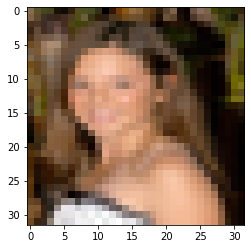

In [106]:
%matplotlib inline
plt.imshow(Image.open('/home/aholdobin/faces/images/1803151818-00000003.jpg').resize(shape))
plt.show()

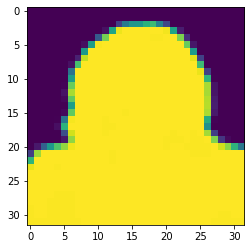

In [107]:
plt.imshow(np.array(Image.open('/home/aholdobin/faces/masks/1803151818-00000118.png').resize(shape))[:,:,-1])
plt.show()

In [82]:
img_1= np.array(Image.open('/home/aholdobin/faces/images/1803151818-00000003.jpg'))

img_1.shape

(800, 600, 3)

In [76]:
msk_2 = np.array(Image.open('/home/aholdobin/faces/masks/1803151818-00000118.png'))

msk_2.shape

(800, 600, 4)

In [25]:
os.path.sep

'/'

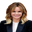

In [108]:
img = Image.open('/home/aholdobin/faces/masks/1803151818-00000118.png'); img.resize(shape)

In [31]:
type([1, 4]) is list

True

In [36]:
plt.figure(figsize=(3,3))
plt.show()

<Figure size 216x216 with 0 Axes>

In [69]:
def show_images_grid(size, path):
    """Plots images in the grid (size * 2 by size), from files in the *path*/images and *path*/masks"""
    masks_path = path + "/masks/"
    images_path = path + "/images/"
    files = os.listdir(images_path)
    chosen = np.random.choice(files, size * size, replace=False)
    chosen_masks = list(map(lambda x: x[:-3]+'png', chosen))
    plt.figure(figsize=(5,15))#(figsize=(size*3*2, size*3))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0.025, hspace=0.05) 
    for i in range(size):
        for j in range(size):
            plt.subplot(size*2, size, size*i*2 + j + 1)
            plt.imshow(Image.open(images_path+chosen[i*size+j])); 
            plt.axis('off')
            plt.subplot(size*2, size, size*(i*2 + 1) + j + 1)
            plt.imshow(Image.open(masks_path+chosen_masks[i*size+j]))
            plt.axis('off')


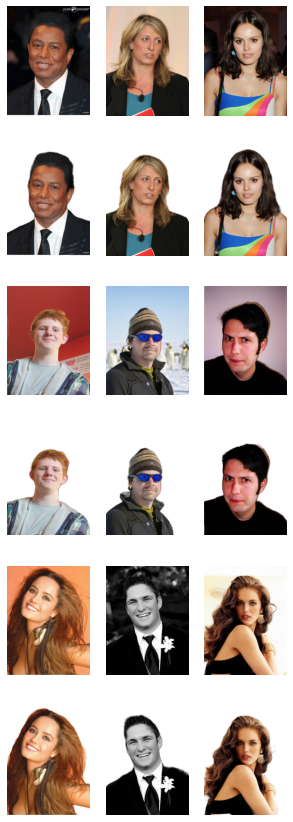

In [70]:
show_images_grid(3, '/home/aholdobin/faces/')

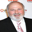

In [109]:
Image.open('/home/aholdobin/faces/images/1803151818-00000048.jpg').resize(shape)

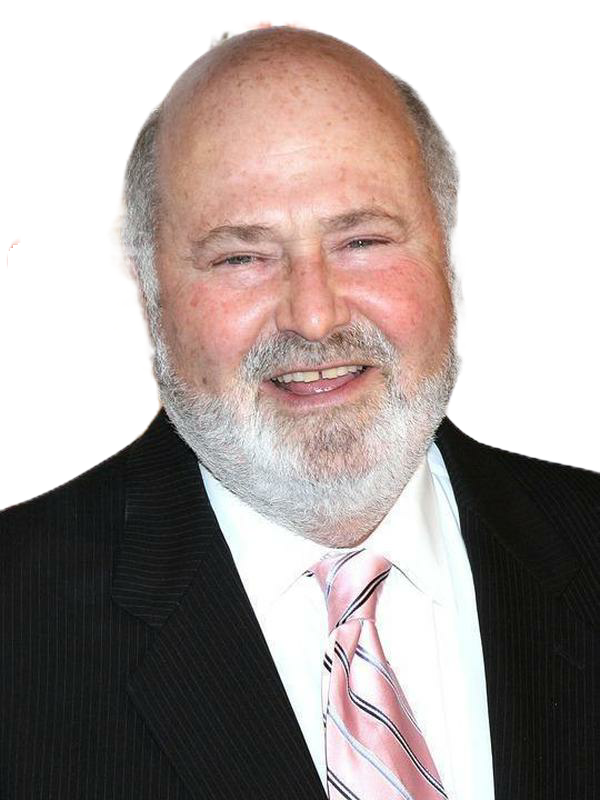

In [85]:
Image.open('/home/aholdobin/faces/masks/1803151818-00000048.png')

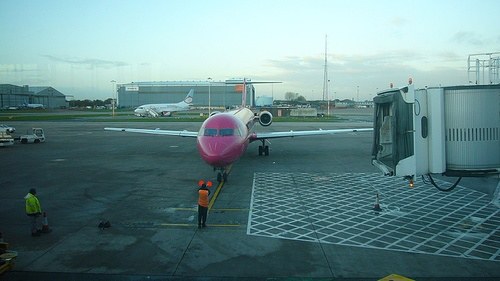

In [89]:
Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg')

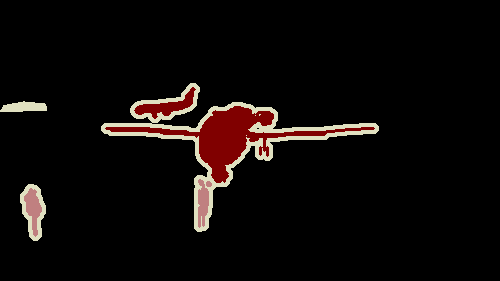

In [88]:
Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png')

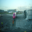

In [111]:
Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg').resize(shape)

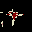

In [110]:
Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png').resize(shape)

In [91]:
mask_200732 = Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png')

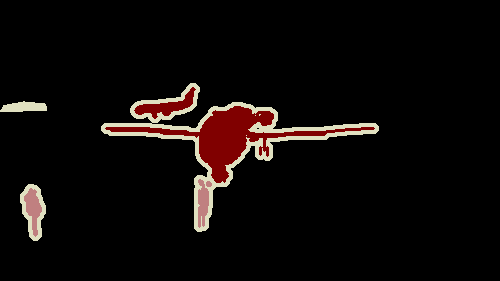

In [92]:
mask_200732

In [93]:
type(mask_200732)

PIL.PngImagePlugin.PngImageFile

In [90]:
msk_2 = np.array(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png'))

msk_2.shape

(281, 500)

In [96]:
msk_2[140:200,230:280]

array([[  1,   1,   1, ..., 255, 255, 255],
       [  1,   1,   1, ..., 255, 255, 255],
       [  1,   1,   1, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

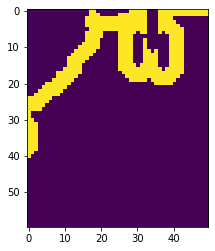

In [112]:
plt.imshow(msk_2[140:200, 230:280])

In [103]:
pascal_voc_home = '/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/' 
segmentation_meta_path =  pascal_voc_home + 'ImageSets/Segmentation/trainval.txt'
with open(segmentation_meta_path) as f:
    segmentation_files = f.read().split('\n')

SyntaxError: invalid syntax (<ipython-input-104-1ca5879492b8>, line 1)

In [115]:
msk_2[160:240,180:240]

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

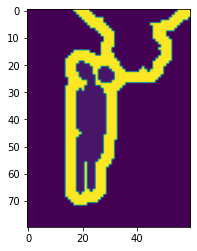

In [114]:
plt.imshow(msk_2[160:240, 180:240])

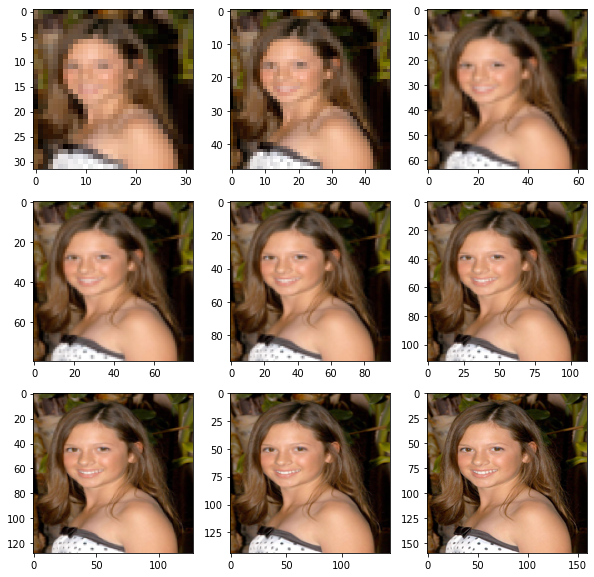

In [129]:
img_shapes = Image.open('/home/aholdobin/faces/images/1803151818-00000003.jpg')
plt.figure(figsize=(10,10))
i = 0
for size in range(32,161,16):
    plt.subplot(3, 3, i+1)
    plt.imshow(img_shapes.resize((size, size)))
    i+=1
plt.show()

In [117]:
list(range(32,64,4))

[32, 36, 40, 44, 48, 52, 56, 60]

In [126]:
for shp in range(32, 97, 16):
    model_tmp = custom_unet(
        (shp, shp, 3),
        use_batch_norm=True,
        num_classes=1,
        filters=8,
        use_attention=True,
        dropout=0.2,
        output_activation='sigmoid'
    )

    model_tmp.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=[iou, iou_thresholded]
    )
    print('#'*100+f"\nParameters in model (shape: {shp} x {shp} x 3)")
    model_tmp.summary()
    del model_tmp


####################################################################################################
Parameters in model (shape: 32 x 32 x 3)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_267 (Conv2D)             (None, 32, 32, 8)    216         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_156 (BatchN (None, 32, 32, 8)    32          conv2d_267[0][0]                 
__________________________________________________________________________________________________
spatial_dropout2d_45 (SpatialDr (None, 32, 32, 8)

####################################################################################################
Parameters in model (shape: 48 x 48 x 3)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_298 (Conv2D)             (None, 48, 48, 8)    216         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_174 (BatchN (None, 48, 48, 8)    32          conv2d_298[0][0]                 
__________________________________________________________________________________________________
spatial_dropout2d_50 (SpatialDr (None, 48, 48, 8)

####################################################################################################
Parameters in model (shape: 64 x 64 x 3)
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_329 (Conv2D)             (None, 64, 64, 8)    216         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_192 (BatchN (None, 64, 64, 8)    32          conv2d_329[0][0]                 
__________________________________________________________________________________________________
spatial_dropout2d_55 (SpatialDr (None, 64, 64, 8)

####################################################################################################
Parameters in model (shape: 80 x 80 x 3)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_360 (Conv2D)             (None, 80, 80, 8)    216         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_210 (BatchN (None, 80, 80, 8)    32          conv2d_360[0][0]                 
__________________________________________________________________________________________________
spatial_dropout2d_60 (SpatialDr (None, 80, 80, 8)

####################################################################################################
Parameters in model (shape: 96 x 96 x 3)
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_391 (Conv2D)             (None, 96, 96, 8)    216         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_228 (BatchN (None, 96, 96, 8)    32          conv2d_391[0][0]                 
__________________________________________________________________________________________________
spatial_dropout2d_65 (SpatialDr (None, 96, 96, 8

In [3]:
model_tmp = custom_unet(
    (1024, 1024, 3),
    use_batch_norm=True,
    num_classes=1,
    filters=8,
    use_attention=True,
    dropout=0.2,
    output_activation='sigmoid'
)

model_tmp.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)
#print('#'*100+f"\nParameters in model (shape: {shp} x {shp} x 3)")
model_tmp.summary()
del model_tmp

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 1024, 1024, 8 216         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 1024, 1024, 8 32          conv2d_31[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_5 (SpatialDro (None, 1024, 1024, 8 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

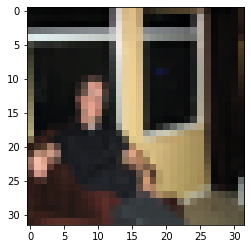

In [8]:
plt.imshow(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/JPEGImages/2007_003530.jpg').resize(shape))

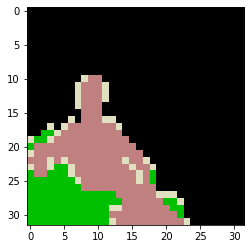

In [10]:
plt.imshow(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_003530.png').resize(shape))

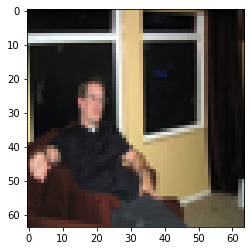

In [12]:
plt.imshow(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/JPEGImages/2007_003530.jpg').resize((64, 64)))

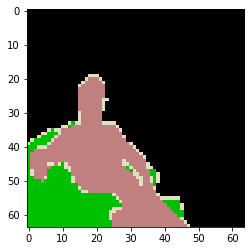

In [11]:
plt.imshow(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_003530.png').resize((64,64)))

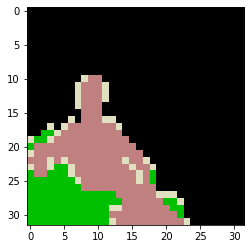

In [10]:
plt.imshow(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_003530.png').resize(shape))

In [14]:
mask_tmp = np.array(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_003530.png').resize(shape))

In [15]:
mask_tmp[10, 10]

15

In [16]:
PASCAL_VOC_PERSON_CLASS_ID = 15

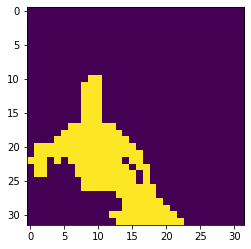

In [17]:
plt.imshow(mask_tmp == 15)

In [24]:
%time
(mask_tmp == PASCAL_VOC_PERSON_CLASS_ID).astype('uint8')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [26]:
(mask_tmp == PASCAL_VOC_PERSON_CLASS_ID).mean()

0.1708984375

In [ ]:
model.fit()

In [28]:
(np.array(Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/SegmentationClass/2007_005988.png').resize(shape)) == PASCAL_VOC_PERSON_CLASS_ID).mean()

0.07421875

In [48]:
tmp = np.random.randint(2, size=[10000,32,32])

In [49]:
len(tmp)

10000

In [50]:
%time
tmp2 = (tmp == 1).astype('uint8')
right = []
for i in range(len(tmp)):
    right.append(tmp2[i].mean() > 0.15)
tmp2 = tmp2[np.array(right, dtype=bool)]
    

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.29 µs


In [ ]:
size(right

In [47]:
all(right)

True

In [39]:
tmp[0]

array([[0, 1, 1, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 1, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 1, 0, 1]])

In [ ]:
def show_pv(name, path='/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/', shape=(32, 32)):
    
    
    

In [ ]:
img1 = Image.open('/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/')

In [125]:
y_train.max()

1.0

In [62]:
pascal_voc_home = '/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/' 
segmentation_meta_path =  pascal_voc_home + 'ImageSets/Segmentation/trainval.txt'
main_meta_path =  pascal_voc_home + 'ImageSets/Main/person_trainval.txt'
segmentation_folder = pascal_voc_home + 'SegmentationClass/'
images_folder = pascal_voc_home + 'JPEGImages/'

In [67]:
with open(segmentation_meta_path) as f:
    segmentation_files = f.read().split('\n')[:-1]
with open(main_meta_path) as f:
    person_files = f.read().split('\n')

In [60]:
len(segmentation_files), len(person_files), len(set(person_files)-set(segmentation_files))

(2914, 11541, 11540)

In [11]:
shape = (32, 32)
images = []
masks = []
for file in segmentation_files:
    images.append(np.array(Image.open(images_folder + file + '.jpg').resize(shape)))
    masks.append(np.array(Image.open(segmentation_folder + file + '.png').resize(shape)) 
                 == PASCAL_VOC_PERSON_CLASS_ID)
# !!! ^^^ wrong: firts we need to get 0-1 for background/human second we need to resize !!!
X = np.array(images)/255.
y = np.array(masks, dtype='float16')

right = np.reshape(y, [y.shape[0], shape[0]*shape[1]]).mean(axis=1)
right = (right >.15) | (right == .0)
print(sum(right))

X = X[right]
y = y[right]

y = np.reshape(y, (y.shape[0], y.shape[1], y.shape[2], 1))
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0)

# del X
# del y

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

NameError: name 'segmentation_files' is not defined

In [92]:
# y = np.concatenate([y_train, y_val])
# X = np.concatenate([x_train, x_val])

1680

In [97]:
ls = os.listdir('/home/aholdobin/faces/images/')

In [101]:
all(list(map(lambda x: x.endswith('jpg'), ls)))

False

In [10]:
import gc
gc.collect()

2616

In [9]:
PASCAL_VOC_PERSON_CLASS_ID = 15

In [10]:
def prepare_pascal_voc_dataset(pascal_voc_home='/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/',
                               coco_home='/home/aholdobin/faces/',
                               shape=(32, 32),
                               verbose=False):
    gc.collect()
    # LOADING PASCAL_VOC DATA IF PROVIDED
    
    images = []
    masks = []
    
    if pascal_voc_home and os.path.exists(pascal_voc_home):
        segmentation_meta_path =  pascal_voc_home + 'ImageSets/Segmentation/trainval.txt'
        segmentation_folder = pascal_voc_home + 'SegmentationClass/'
        images_folder = pascal_voc_home + 'JPEGImages/'

        with open(segmentation_meta_path) as f:
            segmentation_files = f.read().split('\n')[:-1]

        for file in tqdm(segmentation_files):
            if os.path.exists(images_folder + file + '.jpg'):
                images.append(np.array(Image.open(images_folder + file + '.jpg').resize(shape)))
                masks.append(np.array(Image.open(segmentation_folder + file + '.png').resize(shape)) 
                             == PASCAL_VOC_PERSON_CLASS_ID)

        X_pv = np.array(images)/255.
        y_pv = np.array(masks, dtype='float16')

        right = np.reshape(y_pv, [y_pv.shape[0], shape[0]*shape[1]]).mean(axis=1)
        right = (right >.15) | (right == .0)
        if verbose:
            print(sum(right))
        X_pv = X_pv[right]
        y_pv = y_pv[right]
        
        if verbose:
            print("x_pv: ", X_pv.shape)
            print("y_pv: ", y_pv.shape)
        
    del images
    del masks
    gc.collect()
    # LOADING COCO DATA IF PROVIDED
    images = []
    masks = []
    if coco_home and os.path.exists(coco_home):
        files = os.listdir(coco_home+'images/')
        if verbose: print('files len', len(files))
        files = list(map(lambda x: x[:-4] if x.endswith('jpg') else None, files))
        i=0
        for file in tqdm(files):
            i+=1
            if i<30: print(os.path.exists(coco_home + f'images/{file}.jpg'))
            if file and os.path.exists(coco_home + f'images/{file}.jpg'):
                
                images.append(np.array(Image.open(coco_home + f'images/{file}.jpg').resize(shape)))
                masks.append(np.array(Image.open(coco_home + f'masks/{file}.png').resize(shape))[:, :, -1])
        
        X_c = np.asarray(images, dtype=np.float32) / 255
        y_c = np.asarray(masks, dtype='float16') / 255
        
    X = np.concatenate([X_pv, X_c])
    y = np.concatenate([y_pv, y_c])
    y = np.reshape(y, (y.shape[0], y.shape[1], y.shape[2], 1))
    
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0)

    # del X
    # del y
    if verbose:
        print("x_train: ", x_train.shape)
        print("y_train: ", y_train.shape)
        print("x_val: ", x_val.shape)
        print("y_val: ", y_val.shape)
        
    return x_train, y_train, x_val, y_val
    

In [11]:
x_train, y_train, x_val, y_val = prepare_pascal_voc_dataset(verbose=True)

  0%|          | 0/34426 [00:00<?, ?it/s]

2396
x_pv:  (2396, 32, 32, 3)
y_pv:  (2396, 32, 32)
files len 34426
True
True
True
True
True


  0%|          | 10/34426 [00:00<11:32, 49.73it/s]

True
True
True
True
True
True
True
True
True
True
True


  0%|          | 21/34426 [00:00<11:36, 49.39it/s]

True
True
True
True
True
True
True
True
True
True
True


  0%|          | 32/34426 [00:00<11:29, 49.88it/s]

True
True


100%|██████████| 34426/34426 [11:11<00:00, 51.25it/s]


x_train:  (25774, 32, 32, 3)
y_train:  (25774, 32, 32, 1)
x_val:  (11047, 32, 32, 3)
y_val:  (11047, 32, 32, 1)


In [12]:
gc.collect()

20

In [13]:
model_filename = 'segm_model_v17_updated_ds.h5'
checkpoint_path = "training_17/weights_updated_ds.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# From [TensorFlow guide][1]https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        first_gpu = gpus[0]
        tf.config.experimental.set_virtual_device_configuration(first_gpu,
                                                                [tf.config.experimental.VirtualDeviceConfiguration(
                                                                    memory_limit=7000)])
    except RuntimeError as e:
        print(e)

shape = (32, 32)

# model = vanilla_unet(input_shape=(196, 196, 3))

model = custom_unet(
    (32, 32, 3),
    use_batch_norm=True,
    num_classes=1,
    filters=8,
    use_attention=True,
    dropout=0.2,
    output_activation='sigmoid'
)

model.compile(
    optimizer=Adam(),
    # optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    # loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 8)    216         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 32, 32, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
gc.collect()
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor='val_loss',
                           patience=10,
                           verbose=1,
                           )

train_gen = get_augmented(
    x_train, y_train, batch_size=1024,
    data_gen_args=dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

callback_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
)

history = model.fit(
    train_gen,
    steps_per_epoch=25,
    epochs=1000,
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint
              # , es_callback
              ]
)

  ...
    to  
  ['...']
Train for 25 steps, validate on 11047 samples
Epoch 1/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.6793 - iou: 0.3937 - iou_thresholded: 0.4339
Epoch 00001: val_loss improved from inf to 0.78594, saving model to training_17/weights_updated_ds.01-0.79.hdf5
25/25 [==============================] - 13s 521ms/step - loss: 0.6732 - iou: 0.3969 - iou_thresholded: 0.4396 - val_loss: 0.7859 - val_iou: 0.4558 - val_iou_thresholded: 0.5742
Epoch 2/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.4808 - iou: 0.5186 - iou_thresholded: 0.6284
Epoch 00002: val_loss improved from 0.78594 to 0.58384, saving model to training_17/weights_updated_ds.02-0.58.hdf5
25/25 [==============================] - 10s 389ms/step - loss: 0.4789 - iou: 0.5200 - iou_thresholded: 0.6300 - val_loss: 0.5838 - val_iou: 0.4509 - val_iou_thresholded: 0.6243
Epoch 3/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.4081 - iou: 0.5769 - iou_thresholded: 0

Epoch 21/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.2194 - iou: 0.7575 - iou_thresholded: 0.8277
Epoch 00021: val_loss improved from 0.20816 to 0.20029, saving model to training_17/weights_updated_ds.21-0.20.hdf5
25/25 [==============================] - 10s 409ms/step - loss: 0.2192 - iou: 0.7577 - iou_thresholded: 0.8279 - val_loss: 0.2003 - val_iou: 0.8016 - val_iou_thresholded: 0.8537
Epoch 22/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.2173 - iou: 0.7603 - iou_thresholded: 0.8293
Epoch 00022: val_loss improved from 0.20029 to 0.19779, saving model to training_17/weights_updated_ds.22-0.20.hdf5
25/25 [==============================] - 10s 408ms/step - loss: 0.2172 - iou: 0.7603 - iou_thresholded: 0.8294 - val_loss: 0.1978 - val_iou: 0.8011 - val_iou_thresholded: 0.8545
Epoch 23/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.2166 - iou: 0.7609 - iou_thresholded: 0.8299
Epoch 00023: val_loss improved from 0.19779 to 0.19629, sa

Epoch 64/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1743 - iou: 0.8046 - iou_thresholded: 0.8619
Epoch 00064: val_loss improved from 0.15341 to 0.15317, saving model to training_17/weights_updated_ds.64-0.15.hdf5
25/25 [==============================] - 10s 416ms/step - loss: 0.1743 - iou: 0.8045 - iou_thresholded: 0.8617 - val_loss: 0.1532 - val_iou: 0.8389 - val_iou_thresholded: 0.8846
Epoch 65/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1729 - iou: 0.8071 - iou_thresholded: 0.8636
Epoch 00065: val_loss did not improve from 0.15317
25/25 [==============================] - 10s 402ms/step - loss: 0.1728 - iou: 0.8071 - iou_thresholded: 0.8636 - val_loss: 0.1561 - val_iou: 0.8367 - val_iou_thresholded: 0.8837
Epoch 66/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1736 - iou: 0.8060 - iou_thresholded: 0.8625
Epoch 00066: val_loss improved from 0.15317 to 0.15015, saving model to training_17/weights_updated_ds.66-0.15.hdf5
25/25 [

Epoch 108/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1584 - iou: 0.8223 - iou_thresholded: 0.8746
Epoch 00108: val_loss did not improve from 0.13350
25/25 [==============================] - 10s 404ms/step - loss: 0.1585 - iou: 0.8222 - iou_thresholded: 0.8745 - val_loss: 0.1360 - val_iou: 0.8482 - val_iou_thresholded: 0.8979
Epoch 109/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1596 - iou: 0.8203 - iou_thresholded: 0.8729
Epoch 00109: val_loss did not improve from 0.13350
25/25 [==============================] - 10s 403ms/step - loss: 0.1593 - iou: 0.8205 - iou_thresholded: 0.8731 - val_loss: 0.1372 - val_iou: 0.8485 - val_iou_thresholded: 0.8968
Epoch 110/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1578 - iou: 0.8227 - iou_thresholded: 0.8743
Epoch 00110: val_loss improved from 0.13350 to 0.13314, saving model to training_17/weights_updated_ds.110-0.13.hdf5
25/25 [==============================] - 10s 416ms/step - loss: 0.15

Epoch 153/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1499 - iou: 0.8312 - iou_thresholded: 0.8804
Epoch 00153: val_loss did not improve from 0.12497
25/25 [==============================] - 10s 402ms/step - loss: 0.1500 - iou: 0.8312 - iou_thresholded: 0.8805 - val_loss: 0.1343 - val_iou: 0.8545 - val_iou_thresholded: 0.8987
Epoch 154/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1490 - iou: 0.8328 - iou_thresholded: 0.8817
Epoch 00154: val_loss did not improve from 0.12497
25/25 [==============================] - 10s 406ms/step - loss: 0.1489 - iou: 0.8328 - iou_thresholded: 0.8818 - val_loss: 0.1276 - val_iou: 0.8587 - val_iou_thresholded: 0.9039
Epoch 155/1000
23/25 [==========================>...] - ETA: 0s - loss: 0.1480 - iou: 0.8323 - iou_thresholded: 0.8819
Epoch 00155: val_loss did not improve from 0.12497
25/25 [==============================] - 10s 405ms/step - loss: 0.1481 - iou: 0.8320 - iou_thresholded: 0.8818 - val_loss: 0.1250 - va

Epoch 176/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1443 - iou: 0.8364 - iou_thresholded: 0.8842
Epoch 00176: val_loss did not improve from 0.12242
25/25 [==============================] - 10s 406ms/step - loss: 0.1442 - iou: 0.8364 - iou_thresholded: 0.8843 - val_loss: 0.1244 - val_iou: 0.8646 - val_iou_thresholded: 0.9071
Epoch 177/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1449 - iou: 0.8364 - iou_thresholded: 0.8840
Epoch 00177: val_loss did not improve from 0.12242
25/25 [==============================] - 10s 408ms/step - loss: 0.1445 - iou: 0.8367 - iou_thresholded: 0.8843 - val_loss: 0.1225 - val_iou: 0.8633 - val_iou_thresholded: 0.9073
Epoch 178/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1440 - iou: 0.8364 - iou_thresholded: 0.8846
Epoch 00178: val_loss did not improve from 0.12242
25/25 [==============================] - 10s 404ms/step - loss: 0.1441 - iou: 0.8364 - iou_thresholded: 0.8845 - val_loss: 0.1239 - va

Epoch 222/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1390 - iou: 0.8415 - iou_thresholded: 0.8881
Epoch 00222: val_loss did not improve from 0.11793
25/25 [==============================] - 10s 405ms/step - loss: 0.1390 - iou: 0.8417 - iou_thresholded: 0.8881 - val_loss: 0.1206 - val_iou: 0.8685 - val_iou_thresholded: 0.9098
Epoch 223/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1386 - iou: 0.8424 - iou_thresholded: 0.8889
Epoch 00223: val_loss did not improve from 0.11793
25/25 [==============================] - 10s 400ms/step - loss: 0.1385 - iou: 0.8425 - iou_thresholded: 0.8890 - val_loss: 0.1210 - val_iou: 0.8661 - val_iou_thresholded: 0.9093
Epoch 224/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1402 - iou: 0.8413 - iou_thresholded: 0.8880
Epoch 00224: val_loss did not improve from 0.11793
25/25 [==============================] - 10s 408ms/step - loss: 0.1402 - iou: 0.8411 - iou_thresholded: 0.8879 - val_loss: 0.1205 - va

Epoch 246/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1366 - iou: 0.8442 - iou_thresholded: 0.8902
Epoch 00246: val_loss did not improve from 0.11690
25/25 [==============================] - 10s 405ms/step - loss: 0.1368 - iou: 0.8443 - iou_thresholded: 0.8902 - val_loss: 0.1174 - val_iou: 0.8695 - val_iou_thresholded: 0.9117
Epoch 247/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1364 - iou: 0.8451 - iou_thresholded: 0.8908
Epoch 00247: val_loss did not improve from 0.11690
25/25 [==============================] - 10s 405ms/step - loss: 0.1368 - iou: 0.8449 - iou_thresholded: 0.8904 - val_loss: 0.1203 - val_iou: 0.8645 - val_iou_thresholded: 0.9102
Epoch 248/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1367 - iou: 0.8443 - iou_thresholded: 0.8904
Epoch 00248: val_loss did not improve from 0.11690
25/25 [==============================] - 10s 408ms/step - loss: 0.1367 - iou: 0.8443 - iou_thresholded: 0.8904 - val_loss: 0.1170 - va

24/25 [===========================>..] - ETA: 0s - loss: 0.1333 - iou: 0.8478 - iou_thresholded: 0.8928
Epoch 00292: val_loss did not improve from 0.11373
25/25 [==============================] - 10s 406ms/step - loss: 0.1333 - iou: 0.8477 - iou_thresholded: 0.8928 - val_loss: 0.1147 - val_iou: 0.8698 - val_iou_thresholded: 0.9142
Epoch 293/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1366 - iou: 0.8450 - iou_thresholded: 0.8908
Epoch 00293: val_loss did not improve from 0.11373
25/25 [==============================] - 10s 406ms/step - loss: 0.1365 - iou: 0.8451 - iou_thresholded: 0.8908 - val_loss: 0.1142 - val_iou: 0.8729 - val_iou_thresholded: 0.9142
Epoch 294/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1317 - iou: 0.8498 - iou_thresholded: 0.8941
Epoch 00294: val_loss did not improve from 0.11373
25/25 [==============================] - 10s 409ms/step - loss: 0.1317 - iou: 0.8497 - iou_thresholded: 0.8941 - val_loss: 0.1148 - val_iou: 0.8692 -

Epoch 339/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1321 - iou: 0.8495 - iou_thresholded: 0.8940
Epoch 00339: val_loss improved from 0.11286 to 0.11220, saving model to training_17/weights_updated_ds.339-0.11.hdf5
25/25 [==============================] - 11s 432ms/step - loss: 0.1319 - iou: 0.8496 - iou_thresholded: 0.8942 - val_loss: 0.1122 - val_iou: 0.8739 - val_iou_thresholded: 0.9154
Epoch 340/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1324 - iou: 0.8493 - iou_thresholded: 0.8934
Epoch 00340: val_loss did not improve from 0.11220
25/25 [==============================] - 10s 402ms/step - loss: 0.1323 - iou: 0.8492 - iou_thresholded: 0.8934 - val_loss: 0.1145 - val_iou: 0.8714 - val_iou_thresholded: 0.9141
Epoch 341/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1351 - iou: 0.8471 - iou_thresholded: 0.8922
Epoch 00341: val_loss did not improve from 0.11220
25/25 [==============================] - 10s 406ms/step - loss: 0.13

Epoch 362/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1314 - iou: 0.8500 - iou_thresholded: 0.8941
Epoch 00362: val_loss did not improve from 0.11122
25/25 [==============================] - 10s 402ms/step - loss: 0.1314 - iou: 0.8500 - iou_thresholded: 0.8943 - val_loss: 0.1121 - val_iou: 0.8712 - val_iou_thresholded: 0.9158
Epoch 363/1000
23/25 [==========================>...] - ETA: 0s - loss: 0.1305 - iou: 0.8506 - iou_thresholded: 0.8950
Epoch 00363: val_loss did not improve from 0.11122
25/25 [==============================] - 10s 402ms/step - loss: 0.1305 - iou: 0.8506 - iou_thresholded: 0.8951 - val_loss: 0.1127 - val_iou: 0.8738 - val_iou_thresholded: 0.9151
Epoch 364/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1306 - iou: 0.8515 - iou_thresholded: 0.8955
Epoch 00364: val_loss did not improve from 0.11122
25/25 [==============================] - 10s 403ms/step - loss: 0.1302 - iou: 0.8517 - iou_thresholded: 0.8958 - val_loss: 0.1122 - va

Epoch 386/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1287 - iou: 0.8531 - iou_thresholded: 0.8964
Epoch 00386: val_loss did not improve from 0.11083
25/25 [==============================] - 10s 407ms/step - loss: 0.1289 - iou: 0.8530 - iou_thresholded: 0.8963 - val_loss: 0.1125 - val_iou: 0.8746 - val_iou_thresholded: 0.9159
Epoch 387/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1296 - iou: 0.8520 - iou_thresholded: 0.8960
Epoch 00387: val_loss did not improve from 0.11083
25/25 [==============================] - 10s 404ms/step - loss: 0.1296 - iou: 0.8520 - iou_thresholded: 0.8959 - val_loss: 0.1120 - val_iou: 0.8749 - val_iou_thresholded: 0.9154
Epoch 388/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1292 - iou: 0.8524 - iou_thresholded: 0.8960
Epoch 00388: val_loss did not improve from 0.11083
25/25 [==============================] - 10s 401ms/step - loss: 0.1296 - iou: 0.8523 - iou_thresholded: 0.8957 - val_loss: 0.1124 - va

Epoch 410/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1287 - iou: 0.8526 - iou_thresholded: 0.8964
Epoch 00410: val_loss improved from 0.11063 to 0.11043, saving model to training_17/weights_updated_ds.410-0.11.hdf5
25/25 [==============================] - 10s 411ms/step - loss: 0.1288 - iou: 0.8526 - iou_thresholded: 0.8963 - val_loss: 0.1104 - val_iou: 0.8766 - val_iou_thresholded: 0.9169
Epoch 411/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1291 - iou: 0.8535 - iou_thresholded: 0.8965
Epoch 00411: val_loss did not improve from 0.11043
25/25 [==============================] - 10s 407ms/step - loss: 0.1292 - iou: 0.8535 - iou_thresholded: 0.8965 - val_loss: 0.1116 - val_iou: 0.8759 - val_iou_thresholded: 0.9161
Epoch 412/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1300 - iou: 0.8516 - iou_thresholded: 0.8955
Epoch 00412: val_loss improved from 0.11043 to 0.10976, saving model to training_17/weights_updated_ds.412-0.11.hdf5
25

Epoch 433/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1278 - iou: 0.8536 - iou_thresholded: 0.8970
Epoch 00433: val_loss did not improve from 0.10915
25/25 [==============================] - 10s 404ms/step - loss: 0.1279 - iou: 0.8535 - iou_thresholded: 0.8970 - val_loss: 0.1104 - val_iou: 0.8754 - val_iou_thresholded: 0.9167
Epoch 434/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1290 - iou: 0.8532 - iou_thresholded: 0.8964
Epoch 00434: val_loss did not improve from 0.10915
25/25 [==============================] - 10s 403ms/step - loss: 0.1289 - iou: 0.8533 - iou_thresholded: 0.8965 - val_loss: 0.1109 - val_iou: 0.8786 - val_iou_thresholded: 0.9174
Epoch 435/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1291 - iou: 0.8534 - iou_thresholded: 0.8964
Epoch 00435: val_loss did not improve from 0.10915
25/25 [==============================] - 10s 403ms/step - loss: 0.1289 - iou: 0.8535 - iou_thresholded: 0.8965 - val_loss: 0.1097 - va

Epoch 457/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1274 - iou: 0.8541 - iou_thresholded: 0.8971
Epoch 00457: val_loss did not improve from 0.10915
25/25 [==============================] - 10s 407ms/step - loss: 0.1275 - iou: 0.8539 - iou_thresholded: 0.8970 - val_loss: 0.1098 - val_iou: 0.8771 - val_iou_thresholded: 0.9174
Epoch 458/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1282 - iou: 0.8545 - iou_thresholded: 0.8975
Epoch 00458: val_loss improved from 0.10915 to 0.10902, saving model to training_17/weights_updated_ds.458-0.11.hdf5
25/25 [==============================] - 10s 409ms/step - loss: 0.1281 - iou: 0.8546 - iou_thresholded: 0.8975 - val_loss: 0.1090 - val_iou: 0.8793 - val_iou_thresholded: 0.9182
Epoch 459/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1284 - iou: 0.8531 - iou_thresholded: 0.8967
Epoch 00459: val_loss did not improve from 0.10902
25/25 [==============================] - 10s 400ms/step - loss: 0.12

Epoch 480/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1263 - iou: 0.8561 - iou_thresholded: 0.8982
Epoch 00480: val_loss did not improve from 0.10790
25/25 [==============================] - 10s 404ms/step - loss: 0.1263 - iou: 0.8560 - iou_thresholded: 0.8982 - val_loss: 0.1092 - val_iou: 0.8757 - val_iou_thresholded: 0.9176
Epoch 481/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1266 - iou: 0.8553 - iou_thresholded: 0.8983
Epoch 00481: val_loss did not improve from 0.10790
25/25 [==============================] - 10s 404ms/step - loss: 0.1269 - iou: 0.8551 - iou_thresholded: 0.8980 - val_loss: 0.1083 - val_iou: 0.8774 - val_iou_thresholded: 0.9188
Epoch 482/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1262 - iou: 0.8556 - iou_thresholded: 0.8982
Epoch 00482: val_loss did not improve from 0.10790
25/25 [==============================] - 10s 403ms/step - loss: 0.1260 - iou: 0.8558 - iou_thresholded: 0.8984 - val_loss: 0.1095 - va

Epoch 504/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1250 - iou: 0.8572 - iou_thresholded: 0.8995
Epoch 00504: val_loss did not improve from 0.10790
25/25 [==============================] - 10s 403ms/step - loss: 0.1252 - iou: 0.8572 - iou_thresholded: 0.8994 - val_loss: 0.1092 - val_iou: 0.8767 - val_iou_thresholded: 0.9182
Epoch 505/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1259 - iou: 0.8560 - iou_thresholded: 0.8986
Epoch 00505: val_loss did not improve from 0.10790
25/25 [==============================] - 10s 406ms/step - loss: 0.1260 - iou: 0.8560 - iou_thresholded: 0.8985 - val_loss: 0.1092 - val_iou: 0.8784 - val_iou_thresholded: 0.9188
Epoch 506/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1257 - iou: 0.8571 - iou_thresholded: 0.8994
Epoch 00506: val_loss did not improve from 0.10790
25/25 [==============================] - 10s 404ms/step - loss: 0.1260 - iou: 0.8568 - iou_thresholded: 0.8991 - val_loss: 0.1106 - va

Epoch 551/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1257 - iou: 0.8567 - iou_thresholded: 0.8989
Epoch 00551: val_loss did not improve from 0.10702
25/25 [==============================] - 10s 405ms/step - loss: 0.1260 - iou: 0.8566 - iou_thresholded: 0.8988 - val_loss: 0.1098 - val_iou: 0.8796 - val_iou_thresholded: 0.9178
Epoch 552/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1265 - iou: 0.8556 - iou_thresholded: 0.8976
Epoch 00552: val_loss did not improve from 0.10702
25/25 [==============================] - 10s 403ms/step - loss: 0.1265 - iou: 0.8556 - iou_thresholded: 0.8977 - val_loss: 0.1126 - val_iou: 0.8744 - val_iou_thresholded: 0.9164
Epoch 553/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1252 - iou: 0.8564 - iou_thresholded: 0.8990
Epoch 00553: val_loss did not improve from 0.10702
25/25 [==============================] - 10s 404ms/step - loss: 0.1250 - iou: 0.8566 - iou_thresholded: 0.8991 - val_loss: 0.1080 - va

Epoch 575/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1254 - iou: 0.8568 - iou_thresholded: 0.8990
Epoch 00575: val_loss did not improve from 0.10702
25/25 [==============================] - 10s 401ms/step - loss: 0.1252 - iou: 0.8569 - iou_thresholded: 0.8992 - val_loss: 0.1083 - val_iou: 0.8786 - val_iou_thresholded: 0.9187
Epoch 576/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1232 - iou: 0.8588 - iou_thresholded: 0.9005
Epoch 00576: val_loss did not improve from 0.10702
25/25 [==============================] - 10s 405ms/step - loss: 0.1233 - iou: 0.8586 - iou_thresholded: 0.9004 - val_loss: 0.1082 - val_iou: 0.8815 - val_iou_thresholded: 0.9186
Epoch 577/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1248 - iou: 0.8575 - iou_thresholded: 0.8993
Epoch 00577: val_loss did not improve from 0.10702
25/25 [==============================] - 10s 405ms/step - loss: 0.1246 - iou: 0.8577 - iou_thresholded: 0.8995 - val_loss: 0.1093 - va

Epoch 598/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1243 - iou: 0.8581 - iou_thresholded: 0.8999
Epoch 00598: val_loss did not improve from 0.10638
25/25 [==============================] - 10s 403ms/step - loss: 0.1249 - iou: 0.8579 - iou_thresholded: 0.8995 - val_loss: 0.1075 - val_iou: 0.8798 - val_iou_thresholded: 0.9195
Epoch 599/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1242 - iou: 0.8572 - iou_thresholded: 0.8996
Epoch 00599: val_loss did not improve from 0.10638
25/25 [==============================] - 10s 419ms/step - loss: 0.1243 - iou: 0.8572 - iou_thresholded: 0.8996 - val_loss: 0.1070 - val_iou: 0.8794 - val_iou_thresholded: 0.9194
Epoch 600/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1249 - iou: 0.8570 - iou_thresholded: 0.8996
Epoch 00600: val_loss did not improve from 0.10638
25/25 [==============================] - 10s 404ms/step - loss: 0.1249 - iou: 0.8571 - iou_thresholded: 0.8996 - val_loss: 0.1072 - va

Epoch 622/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1225 - iou: 0.8597 - iou_thresholded: 0.9015
Epoch 00622: val_loss did not improve from 0.10604
25/25 [==============================] - 10s 403ms/step - loss: 0.1229 - iou: 0.8595 - iou_thresholded: 0.9012 - val_loss: 0.1086 - val_iou: 0.8787 - val_iou_thresholded: 0.9188
Epoch 623/1000
23/25 [==========================>...] - ETA: 0s - loss: 0.1231 - iou: 0.8591 - iou_thresholded: 0.9010
Epoch 00623: val_loss did not improve from 0.10604
25/25 [==============================] - 10s 411ms/step - loss: 0.1233 - iou: 0.8589 - iou_thresholded: 0.9007 - val_loss: 0.1074 - val_iou: 0.8801 - val_iou_thresholded: 0.9199
Epoch 624/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1230 - iou: 0.8590 - iou_thresholded: 0.9006
Epoch 00624: val_loss did not improve from 0.10604
25/25 [==============================] - 10s 408ms/step - loss: 0.1231 - iou: 0.8589 - iou_thresholded: 0.9006 - val_loss: 0.1087 - va

24/25 [===========================>..] - ETA: 0s - loss: 0.1220 - iou: 0.8604 - iou_thresholded: 0.9019
Epoch 00668: val_loss did not improve from 0.10511
25/25 [==============================] - 10s 402ms/step - loss: 0.1220 - iou: 0.8605 - iou_thresholded: 0.9018 - val_loss: 0.1072 - val_iou: 0.8818 - val_iou_thresholded: 0.9194
Epoch 669/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1243 - iou: 0.8582 - iou_thresholded: 0.8999
Epoch 00669: val_loss did not improve from 0.10511
25/25 [==============================] - 10s 402ms/step - loss: 0.1242 - iou: 0.8582 - iou_thresholded: 0.8999 - val_loss: 0.1063 - val_iou: 0.8823 - val_iou_thresholded: 0.9198
Epoch 670/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1229 - iou: 0.8594 - iou_thresholded: 0.9007
Epoch 00670: val_loss did not improve from 0.10511
25/25 [==============================] - 10s 411ms/step - loss: 0.1228 - iou: 0.8595 - iou_thresholded: 0.9008 - val_loss: 0.1070 - val_iou: 0.8807 -

Epoch 692/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1230 - iou: 0.8588 - iou_thresholded: 0.9006
Epoch 00692: val_loss did not improve from 0.10511
25/25 [==============================] - 10s 400ms/step - loss: 0.1229 - iou: 0.8589 - iou_thresholded: 0.9006 - val_loss: 0.1088 - val_iou: 0.8771 - val_iou_thresholded: 0.9186
Epoch 693/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1230 - iou: 0.8590 - iou_thresholded: 0.9008
Epoch 00693: val_loss did not improve from 0.10511
25/25 [==============================] - 10s 403ms/step - loss: 0.1231 - iou: 0.8591 - iou_thresholded: 0.9008 - val_loss: 0.1061 - val_iou: 0.8822 - val_iou_thresholded: 0.9201
Epoch 694/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1232 - iou: 0.8595 - iou_thresholded: 0.9008
Epoch 00694: val_loss did not improve from 0.10511
25/25 [==============================] - 10s 408ms/step - loss: 0.1232 - iou: 0.8594 - iou_thresholded: 0.9008 - val_loss: 0.1053 - va

Epoch 716/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1215 - iou: 0.8606 - iou_thresholded: 0.9020
Epoch 00716: val_loss did not improve from 0.10511
25/25 [==============================] - 10s 406ms/step - loss: 0.1215 - iou: 0.8606 - iou_thresholded: 0.9021 - val_loss: 0.1057 - val_iou: 0.8816 - val_iou_thresholded: 0.9206
Epoch 717/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1223 - iou: 0.8601 - iou_thresholded: 0.9015
Epoch 00717: val_loss did not improve from 0.10511
25/25 [==============================] - 10s 404ms/step - loss: 0.1222 - iou: 0.8601 - iou_thresholded: 0.9016 - val_loss: 0.1060 - val_iou: 0.8803 - val_iou_thresholded: 0.9204
Epoch 718/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1210 - iou: 0.8615 - iou_thresholded: 0.9021
Epoch 00718: val_loss did not improve from 0.10511
25/25 [==============================] - 10s 405ms/step - loss: 0.1210 - iou: 0.8615 - iou_thresholded: 0.9021 - val_loss: 0.1057 - va

Epoch 763/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1202 - iou: 0.8625 - iou_thresholded: 0.9031
Epoch 00763: val_loss did not improve from 0.10425
25/25 [==============================] - 10s 406ms/step - loss: 0.1203 - iou: 0.8624 - iou_thresholded: 0.9030 - val_loss: 0.1078 - val_iou: 0.8820 - val_iou_thresholded: 0.9194
Epoch 764/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1218 - iou: 0.8609 - iou_thresholded: 0.9019
Epoch 00764: val_loss did not improve from 0.10425
25/25 [==============================] - 10s 409ms/step - loss: 0.1217 - iou: 0.8610 - iou_thresholded: 0.9020 - val_loss: 0.1057 - val_iou: 0.8794 - val_iou_thresholded: 0.9210
Epoch 765/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1213 - iou: 0.8612 - iou_thresholded: 0.9019
Epoch 00765: val_loss did not improve from 0.10425
25/25 [==============================] - 10s 408ms/step - loss: 0.1214 - iou: 0.8609 - iou_thresholded: 0.9017 - val_loss: 0.1061 - va

Epoch 810/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1207 - iou: 0.8620 - iou_thresholded: 0.9025
Epoch 00810: val_loss did not improve from 0.10312
25/25 [==============================] - 10s 401ms/step - loss: 0.1204 - iou: 0.8621 - iou_thresholded: 0.9027 - val_loss: 0.1040 - val_iou: 0.8841 - val_iou_thresholded: 0.9224
Epoch 811/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1203 - iou: 0.8620 - iou_thresholded: 0.9025
Epoch 00811: val_loss did not improve from 0.10312
25/25 [==============================] - 10s 406ms/step - loss: 0.1204 - iou: 0.8619 - iou_thresholded: 0.9026 - val_loss: 0.1045 - val_iou: 0.8795 - val_iou_thresholded: 0.9215
Epoch 812/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1201 - iou: 0.8618 - iou_thresholded: 0.9027
Epoch 00812: val_loss did not improve from 0.10312
25/25 [==============================] - 10s 404ms/step - loss: 0.1202 - iou: 0.8617 - iou_thresholded: 0.9026 - val_loss: 0.1053 - va

Epoch 834/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1199 - iou: 0.8625 - iou_thresholded: 0.9033
Epoch 00834: val_loss did not improve from 0.10312
25/25 [==============================] - 10s 405ms/step - loss: 0.1201 - iou: 0.8624 - iou_thresholded: 0.9031 - val_loss: 0.1048 - val_iou: 0.8835 - val_iou_thresholded: 0.9211
Epoch 835/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1217 - iou: 0.8609 - iou_thresholded: 0.9018
Epoch 00835: val_loss did not improve from 0.10312
25/25 [==============================] - 10s 406ms/step - loss: 0.1218 - iou: 0.8608 - iou_thresholded: 0.9017 - val_loss: 0.1047 - val_iou: 0.8835 - val_iou_thresholded: 0.9214
Epoch 836/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1203 - iou: 0.8619 - iou_thresholded: 0.9026
Epoch 00836: val_loss did not improve from 0.10312
25/25 [==============================] - 10s 405ms/step - loss: 0.1203 - iou: 0.8620 - iou_thresholded: 0.9027 - val_loss: 0.1042 - va

Epoch 858/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1192 - iou: 0.8632 - iou_thresholded: 0.9038
Epoch 00858: val_loss did not improve from 0.10312
25/25 [==============================] - 10s 403ms/step - loss: 0.1199 - iou: 0.8627 - iou_thresholded: 0.9034 - val_loss: 0.1043 - val_iou: 0.8834 - val_iou_thresholded: 0.9218
Epoch 859/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1203 - iou: 0.8625 - iou_thresholded: 0.9031
Epoch 00859: val_loss did not improve from 0.10312
25/25 [==============================] - 11s 425ms/step - loss: 0.1203 - iou: 0.8625 - iou_thresholded: 0.9031 - val_loss: 0.1044 - val_iou: 0.8837 - val_iou_thresholded: 0.9220
Epoch 860/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1205 - iou: 0.8617 - iou_thresholded: 0.9027
Epoch 00860: val_loss did not improve from 0.10312
25/25 [==============================] - 10s 407ms/step - loss: 0.1206 - iou: 0.8617 - iou_thresholded: 0.9027 - val_loss: 0.1047 - va

Epoch 882/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1189 - iou: 0.8633 - iou_thresholded: 0.9036
Epoch 00882: val_loss did not improve from 0.10312
25/25 [==============================] - 10s 406ms/step - loss: 0.1190 - iou: 0.8632 - iou_thresholded: 0.9035 - val_loss: 0.1044 - val_iou: 0.8832 - val_iou_thresholded: 0.9217
Epoch 883/1000
23/25 [==========================>...] - ETA: 0s - loss: 0.1197 - iou: 0.8629 - iou_thresholded: 0.9036
Epoch 00883: val_loss improved from 0.10312 to 0.10307, saving model to training_17/weights_updated_ds.883-0.10.hdf5
25/25 [==============================] - 10s 414ms/step - loss: 0.1195 - iou: 0.8628 - iou_thresholded: 0.9036 - val_loss: 0.1031 - val_iou: 0.8865 - val_iou_thresholded: 0.9226
Epoch 884/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1196 - iou: 0.8635 - iou_thresholded: 0.9034
Epoch 00884: val_loss did not improve from 0.10307
25/25 [==============================] - 10s 402ms/step - loss: 0.11

Epoch 906/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1205 - iou: 0.8620 - iou_thresholded: 0.9025
Epoch 00906: val_loss did not improve from 0.10307
25/25 [==============================] - 10s 405ms/step - loss: 0.1205 - iou: 0.8619 - iou_thresholded: 0.9026 - val_loss: 0.1054 - val_iou: 0.8798 - val_iou_thresholded: 0.9213
Epoch 907/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1201 - iou: 0.8622 - iou_thresholded: 0.9030
Epoch 00907: val_loss did not improve from 0.10307
25/25 [==============================] - 10s 406ms/step - loss: 0.1201 - iou: 0.8623 - iou_thresholded: 0.9031 - val_loss: 0.1070 - val_iou: 0.8801 - val_iou_thresholded: 0.9200
Epoch 908/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1192 - iou: 0.8628 - iou_thresholded: 0.9034
Epoch 00908: val_loss did not improve from 0.10307
25/25 [==============================] - 10s 408ms/step - loss: 0.1193 - iou: 0.8627 - iou_thresholded: 0.9034 - val_loss: 0.1055 - va

Epoch 953/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1188 - iou: 0.8641 - iou_thresholded: 0.9042
Epoch 00953: val_loss did not improve from 0.10279
25/25 [==============================] - 10s 408ms/step - loss: 0.1187 - iou: 0.8642 - iou_thresholded: 0.9042 - val_loss: 0.1047 - val_iou: 0.8850 - val_iou_thresholded: 0.9219
Epoch 954/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1181 - iou: 0.8645 - iou_thresholded: 0.9047
Epoch 00954: val_loss did not improve from 0.10279
25/25 [==============================] - 10s 411ms/step - loss: 0.1183 - iou: 0.8645 - iou_thresholded: 0.9047 - val_loss: 0.1038 - val_iou: 0.8841 - val_iou_thresholded: 0.9223
Epoch 955/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1195 - iou: 0.8626 - iou_thresholded: 0.9028
Epoch 00955: val_loss did not improve from 0.10279
25/25 [==============================] - 10s 409ms/step - loss: 0.1194 - iou: 0.8626 - iou_thresholded: 0.9029 - val_loss: 0.1045 - va

Epoch 977/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1185 - iou: 0.8637 - iou_thresholded: 0.9040
Epoch 00977: val_loss did not improve from 0.10279
25/25 [==============================] - 10s 413ms/step - loss: 0.1186 - iou: 0.8636 - iou_thresholded: 0.9039 - val_loss: 0.1066 - val_iou: 0.8814 - val_iou_thresholded: 0.9206
Epoch 978/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1187 - iou: 0.8641 - iou_thresholded: 0.9043
Epoch 00978: val_loss did not improve from 0.10279
25/25 [==============================] - 10s 410ms/step - loss: 0.1187 - iou: 0.8640 - iou_thresholded: 0.9042 - val_loss: 0.1033 - val_iou: 0.8855 - val_iou_thresholded: 0.9226
Epoch 979/1000
24/25 [===========================>..] - ETA: 0s - loss: 0.1190 - iou: 0.8635 - iou_thresholded: 0.9040
Epoch 00979: val_loss did not improve from 0.10279
25/25 [==============================] - 10s 408ms/step - loss: 0.1190 - iou: 0.8634 - iou_thresholded: 0.9040 - val_loss: 0.1048 - va

In [15]:
import pickle
with open('data_dict.p','wb') as f:
    pickle.dump({'x_train':x_train, "y_train":y_train,'x_val':x_val, "y_val":y_val,}, f)

In [16]:
gc.collect()

524

In [17]:
history2 = model.fit(
    train_gen,
    steps_per_epoch=25,
    epochs=8000,
    initial_epoch=1000,
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint
              # , es_callback
              ]
)

  ...
    to  
  ['...']
Train for 25 steps, validate on 11047 samples
Epoch 1001/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1172 - iou: 0.8656 - iou_thresholded: 0.9052
Epoch 01001: val_loss did not improve from 0.10279
25/25 [==============================] - 10s 393ms/step - loss: 0.1171 - iou: 0.8657 - iou_thresholded: 0.9053 - val_loss: 0.1045 - val_iou: 0.8842 - val_iou_thresholded: 0.9219
Epoch 1002/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1175 - iou: 0.8645 - iou_thresholded: 0.9049
Epoch 01002: val_loss did not improve from 0.10279
25/25 [==============================] - 10s 401ms/step - loss: 0.1175 - iou: 0.8646 - iou_thresholded: 0.9049 - val_loss: 0.1045 - val_iou: 0.8841 - val_iou_thresholded: 0.9217
Epoch 1003/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1198 - iou: 0.8627 - iou_thresholded: 0.9030
Epoch 01003: val_loss did not improve from 0.10279
25/25 [==============================] - 10s 398ms/step - lo

24/25 [===========================>..] - ETA: 0s - loss: 0.1185 - iou: 0.8647 - iou_thresholded: 0.9046
Epoch 01047: val_loss did not improve from 0.10258
25/25 [==============================] - 10s 404ms/step - loss: 0.1188 - iou: 0.8644 - iou_thresholded: 0.9043 - val_loss: 0.1035 - val_iou: 0.8870 - val_iou_thresholded: 0.9230
Epoch 1048/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1185 - iou: 0.8637 - iou_thresholded: 0.9040
Epoch 01048: val_loss did not improve from 0.10258
25/25 [==============================] - 10s 404ms/step - loss: 0.1187 - iou: 0.8635 - iou_thresholded: 0.9037 - val_loss: 0.1068 - val_iou: 0.8843 - val_iou_thresholded: 0.9205
Epoch 1049/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1173 - iou: 0.8648 - iou_thresholded: 0.9048
Epoch 01049: val_loss did not improve from 0.10258
25/25 [==============================] - 10s 402ms/step - loss: 0.1171 - iou: 0.8650 - iou_thresholded: 0.9050 - val_loss: 0.1045 - val_iou: 0.8857

Epoch 1094/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1171 - iou: 0.8652 - iou_thresholded: 0.9050
Epoch 01094: val_loss did not improve from 0.10246
25/25 [==============================] - 11s 425ms/step - loss: 0.1172 - iou: 0.8651 - iou_thresholded: 0.9050 - val_loss: 0.1042 - val_iou: 0.8804 - val_iou_thresholded: 0.9221
Epoch 1095/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1174 - iou: 0.8646 - iou_thresholded: 0.9045
Epoch 01095: val_loss did not improve from 0.10246
25/25 [==============================] - 10s 406ms/step - loss: 0.1173 - iou: 0.8645 - iou_thresholded: 0.9045 - val_loss: 0.1039 - val_iou: 0.8844 - val_iou_thresholded: 0.9224
Epoch 1096/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1170 - iou: 0.8659 - iou_thresholded: 0.9053
Epoch 01096: val_loss did not improve from 0.10246
25/25 [==============================] - 10s 406ms/step - loss: 0.1172 - iou: 0.8658 - iou_thresholded: 0.9052 - val_loss: 0.1039 -

Epoch 1118/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1171 - iou: 0.8652 - iou_thresholded: 0.9053
Epoch 01118: val_loss did not improve from 0.10246
25/25 [==============================] - 10s 403ms/step - loss: 0.1173 - iou: 0.8653 - iou_thresholded: 0.9054 - val_loss: 0.1037 - val_iou: 0.8851 - val_iou_thresholded: 0.9226
Epoch 1119/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1174 - iou: 0.8652 - iou_thresholded: 0.9050
Epoch 01119: val_loss did not improve from 0.10246
25/25 [==============================] - 10s 401ms/step - loss: 0.1171 - iou: 0.8653 - iou_thresholded: 0.9052 - val_loss: 0.1043 - val_iou: 0.8851 - val_iou_thresholded: 0.9222
Epoch 1120/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1177 - iou: 0.8652 - iou_thresholded: 0.9051
Epoch 01120: val_loss did not improve from 0.10246
25/25 [==============================] - 11s 422ms/step - loss: 0.1176 - iou: 0.8653 - iou_thresholded: 0.9052 - val_loss: 0.1046 -

Epoch 1165/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1172 - iou: 0.8656 - iou_thresholded: 0.9051
Epoch 01165: val_loss did not improve from 0.10165
25/25 [==============================] - 10s 404ms/step - loss: 0.1173 - iou: 0.8656 - iou_thresholded: 0.9051 - val_loss: 0.1044 - val_iou: 0.8826 - val_iou_thresholded: 0.9219
Epoch 1166/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1165 - iou: 0.8663 - iou_thresholded: 0.9059
Epoch 01166: val_loss did not improve from 0.10165
25/25 [==============================] - 10s 405ms/step - loss: 0.1165 - iou: 0.8662 - iou_thresholded: 0.9059 - val_loss: 0.1060 - val_iou: 0.8804 - val_iou_thresholded: 0.9209
Epoch 1167/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1172 - iou: 0.8655 - iou_thresholded: 0.9052
Epoch 01167: val_loss did not improve from 0.10165
25/25 [==============================] - 10s 404ms/step - loss: 0.1171 - iou: 0.8655 - iou_thresholded: 0.9053 - val_loss: 0.1039 -

Epoch 1189/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1174 - iou: 0.8650 - iou_thresholded: 0.9048
Epoch 01189: val_loss did not improve from 0.10165
25/25 [==============================] - 10s 407ms/step - loss: 0.1173 - iou: 0.8652 - iou_thresholded: 0.9049 - val_loss: 0.1064 - val_iou: 0.8836 - val_iou_thresholded: 0.9208
Epoch 1190/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1163 - iou: 0.8660 - iou_thresholded: 0.9058
Epoch 01190: val_loss did not improve from 0.10165
25/25 [==============================] - 10s 406ms/step - loss: 0.1164 - iou: 0.8660 - iou_thresholded: 0.9057 - val_loss: 0.1050 - val_iou: 0.8872 - val_iou_thresholded: 0.9226
Epoch 1191/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1164 - iou: 0.8660 - iou_thresholded: 0.9056
Epoch 01191: val_loss did not improve from 0.10165
25/25 [==============================] - 10s 404ms/step - loss: 0.1165 - iou: 0.8659 - iou_thresholded: 0.9055 - val_loss: 0.1033 -

24/25 [===========================>..] - ETA: 0s - loss: 0.1165 - iou: 0.8652 - iou_thresholded: 0.9051
Epoch 01235: val_loss did not improve from 0.10140
25/25 [==============================] - 10s 404ms/step - loss: 0.1164 - iou: 0.8653 - iou_thresholded: 0.9052 - val_loss: 0.1029 - val_iou: 0.8887 - val_iou_thresholded: 0.9235
Epoch 1236/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1157 - iou: 0.8670 - iou_thresholded: 0.9062
Epoch 01236: val_loss did not improve from 0.10140
25/25 [==============================] - 10s 404ms/step - loss: 0.1159 - iou: 0.8668 - iou_thresholded: 0.9060 - val_loss: 0.1037 - val_iou: 0.8847 - val_iou_thresholded: 0.9229
Epoch 1237/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1159 - iou: 0.8671 - iou_thresholded: 0.9062
Epoch 01237: val_loss did not improve from 0.10140
25/25 [==============================] - 10s 406ms/step - loss: 0.1159 - iou: 0.8671 - iou_thresholded: 0.9062 - val_loss: 0.1046 - val_iou: 0.8846

Epoch 1259/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1158 - iou: 0.8670 - iou_thresholded: 0.9062
Epoch 01259: val_loss did not improve from 0.10140
25/25 [==============================] - 10s 412ms/step - loss: 0.1159 - iou: 0.8669 - iou_thresholded: 0.9061 - val_loss: 0.1021 - val_iou: 0.8861 - val_iou_thresholded: 0.9237
Epoch 1260/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1173 - iou: 0.8656 - iou_thresholded: 0.9052
Epoch 01260: val_loss did not improve from 0.10140
25/25 [==============================] - 10s 410ms/step - loss: 0.1171 - iou: 0.8658 - iou_thresholded: 0.9053 - val_loss: 0.1031 - val_iou: 0.8849 - val_iou_thresholded: 0.9234
Epoch 1261/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1162 - iou: 0.8660 - iou_thresholded: 0.9059
Epoch 01261: val_loss did not improve from 0.10140
25/25 [==============================] - 10s 408ms/step - loss: 0.1163 - iou: 0.8660 - iou_thresholded: 0.9059 - val_loss: 0.1058 -

Epoch 1283/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1154 - iou: 0.8671 - iou_thresholded: 0.9066
Epoch 01283: val_loss did not improve from 0.10140
25/25 [==============================] - 10s 406ms/step - loss: 0.1155 - iou: 0.8670 - iou_thresholded: 0.9065 - val_loss: 0.1025 - val_iou: 0.8871 - val_iou_thresholded: 0.9232
Epoch 1284/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1153 - iou: 0.8671 - iou_thresholded: 0.9065
Epoch 01284: val_loss did not improve from 0.10140
25/25 [==============================] - 10s 407ms/step - loss: 0.1154 - iou: 0.8671 - iou_thresholded: 0.9064 - val_loss: 0.1029 - val_iou: 0.8870 - val_iou_thresholded: 0.9236
Epoch 1285/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1168 - iou: 0.8665 - iou_thresholded: 0.9061
Epoch 01285: val_loss did not improve from 0.10140
25/25 [==============================] - 10s 410ms/step - loss: 0.1165 - iou: 0.8666 - iou_thresholded: 0.9062 - val_loss: 0.1022 -

Epoch 1330/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1159 - iou: 0.8663 - iou_thresholded: 0.9059
Epoch 01330: val_loss did not improve from 0.10131
25/25 [==============================] - 10s 406ms/step - loss: 0.1157 - iou: 0.8665 - iou_thresholded: 0.9061 - val_loss: 0.1026 - val_iou: 0.8870 - val_iou_thresholded: 0.9233
Epoch 1331/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1149 - iou: 0.8682 - iou_thresholded: 0.9069
Epoch 01331: val_loss did not improve from 0.10131
25/25 [==============================] - 10s 409ms/step - loss: 0.1149 - iou: 0.8682 - iou_thresholded: 0.9069 - val_loss: 0.1023 - val_iou: 0.8857 - val_iou_thresholded: 0.9243
Epoch 1332/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1167 - iou: 0.8662 - iou_thresholded: 0.9059
Epoch 01332: val_loss did not improve from 0.10131
25/25 [==============================] - 10s 401ms/step - loss: 0.1169 - iou: 0.8661 - iou_thresholded: 0.9056 - val_loss: 0.1028 -

24/25 [===========================>..] - ETA: 0s - loss: 0.1155 - iou: 0.8672 - iou_thresholded: 0.9062
Epoch 01376: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 403ms/step - loss: 0.1154 - iou: 0.8673 - iou_thresholded: 0.9063 - val_loss: 0.1048 - val_iou: 0.8828 - val_iou_thresholded: 0.9217
Epoch 1377/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1159 - iou: 0.8667 - iou_thresholded: 0.9059
Epoch 01377: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 403ms/step - loss: 0.1159 - iou: 0.8668 - iou_thresholded: 0.9059 - val_loss: 0.1028 - val_iou: 0.8832 - val_iou_thresholded: 0.9233
Epoch 1378/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1152 - iou: 0.8672 - iou_thresholded: 0.9063
Epoch 01378: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 400ms/step - loss: 0.1158 - iou: 0.8669 - iou_thresholded: 0.9060 - val_loss: 0.1022 - val_iou: 0.8852

Epoch 1400/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1152 - iou: 0.8669 - iou_thresholded: 0.9064
Epoch 01400: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 406ms/step - loss: 0.1152 - iou: 0.8670 - iou_thresholded: 0.9064 - val_loss: 0.1065 - val_iou: 0.8854 - val_iou_thresholded: 0.9211
Epoch 1401/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1149 - iou: 0.8676 - iou_thresholded: 0.9066
Epoch 01401: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 404ms/step - loss: 0.1149 - iou: 0.8677 - iou_thresholded: 0.9066 - val_loss: 0.1029 - val_iou: 0.8846 - val_iou_thresholded: 0.9230
Epoch 1402/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1158 - iou: 0.8668 - iou_thresholded: 0.9061
Epoch 01402: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 406ms/step - loss: 0.1158 - iou: 0.8669 - iou_thresholded: 0.9061 - val_loss: 0.1028 -

Epoch 1424/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1135 - iou: 0.8697 - iou_thresholded: 0.9081
Epoch 01424: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 408ms/step - loss: 0.1134 - iou: 0.8697 - iou_thresholded: 0.9080 - val_loss: 0.1031 - val_iou: 0.8871 - val_iou_thresholded: 0.9236
Epoch 1425/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1149 - iou: 0.8677 - iou_thresholded: 0.9069
Epoch 01425: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 409ms/step - loss: 0.1148 - iou: 0.8678 - iou_thresholded: 0.9070 - val_loss: 0.1037 - val_iou: 0.8841 - val_iou_thresholded: 0.9234
Epoch 1426/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1154 - iou: 0.8673 - iou_thresholded: 0.9066
Epoch 01426: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 404ms/step - loss: 0.1152 - iou: 0.8675 - iou_thresholded: 0.9068 - val_loss: 0.1031 -

Epoch 1448/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1150 - iou: 0.8681 - iou_thresholded: 0.9070
Epoch 01448: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 403ms/step - loss: 0.1150 - iou: 0.8682 - iou_thresholded: 0.9071 - val_loss: 0.1027 - val_iou: 0.8869 - val_iou_thresholded: 0.9235
Epoch 1449/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1155 - iou: 0.8672 - iou_thresholded: 0.9067
Epoch 01449: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 405ms/step - loss: 0.1155 - iou: 0.8672 - iou_thresholded: 0.9067 - val_loss: 0.1033 - val_iou: 0.8852 - val_iou_thresholded: 0.9233
Epoch 1450/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1153 - iou: 0.8673 - iou_thresholded: 0.9064
Epoch 01450: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 407ms/step - loss: 0.1152 - iou: 0.8674 - iou_thresholded: 0.9065 - val_loss: 0.1026 -

Epoch 1472/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1147 - iou: 0.8672 - iou_thresholded: 0.9064
Epoch 01472: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 407ms/step - loss: 0.1148 - iou: 0.8672 - iou_thresholded: 0.9063 - val_loss: 0.1030 - val_iou: 0.8873 - val_iou_thresholded: 0.9231
Epoch 1473/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1150 - iou: 0.8679 - iou_thresholded: 0.9069
Epoch 01473: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 406ms/step - loss: 0.1153 - iou: 0.8677 - iou_thresholded: 0.9067 - val_loss: 0.1021 - val_iou: 0.8879 - val_iou_thresholded: 0.9240
Epoch 1474/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1164 - iou: 0.8665 - iou_thresholded: 0.9062
Epoch 01474: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 402ms/step - loss: 0.1164 - iou: 0.8665 - iou_thresholded: 0.9061 - val_loss: 0.1024 -

Epoch 1496/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1147 - iou: 0.8684 - iou_thresholded: 0.9071
Epoch 01496: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 404ms/step - loss: 0.1146 - iou: 0.8683 - iou_thresholded: 0.9071 - val_loss: 0.1021 - val_iou: 0.8837 - val_iou_thresholded: 0.9239
Epoch 1497/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1155 - iou: 0.8668 - iou_thresholded: 0.9060
Epoch 01497: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 402ms/step - loss: 0.1157 - iou: 0.8667 - iou_thresholded: 0.9058 - val_loss: 0.1009 - val_iou: 0.8846 - val_iou_thresholded: 0.9245
Epoch 1498/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1150 - iou: 0.8671 - iou_thresholded: 0.9065
Epoch 01498: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 406ms/step - loss: 0.1150 - iou: 0.8672 - iou_thresholded: 0.9065 - val_loss: 0.1025 -

Epoch 1520/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1163 - iou: 0.8665 - iou_thresholded: 0.9058
Epoch 01520: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 405ms/step - loss: 0.1162 - iou: 0.8665 - iou_thresholded: 0.9059 - val_loss: 0.1028 - val_iou: 0.8874 - val_iou_thresholded: 0.9232
Epoch 1521/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1151 - iou: 0.8673 - iou_thresholded: 0.9062
Epoch 01521: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 404ms/step - loss: 0.1150 - iou: 0.8675 - iou_thresholded: 0.9064 - val_loss: 0.1023 - val_iou: 0.8892 - val_iou_thresholded: 0.9242
Epoch 1522/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1161 - iou: 0.8665 - iou_thresholded: 0.9061
Epoch 01522: val_loss did not improve from 0.10079
25/25 [==============================] - 10s 402ms/step - loss: 0.1159 - iou: 0.8666 - iou_thresholded: 0.9062 - val_loss: 0.1025 -

Epoch 1567/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1149 - iou: 0.8682 - iou_thresholded: 0.9071
Epoch 01567: val_loss did not improve from 0.10055
25/25 [==============================] - 10s 409ms/step - loss: 0.1149 - iou: 0.8681 - iou_thresholded: 0.9071 - val_loss: 0.1028 - val_iou: 0.8851 - val_iou_thresholded: 0.9236
Epoch 1568/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1146 - iou: 0.8683 - iou_thresholded: 0.9071
Epoch 01568: val_loss did not improve from 0.10055
25/25 [==============================] - 10s 405ms/step - loss: 0.1144 - iou: 0.8684 - iou_thresholded: 0.9072 - val_loss: 0.1028 - val_iou: 0.8865 - val_iou_thresholded: 0.9238
Epoch 1569/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1145 - iou: 0.8683 - iou_thresholded: 0.9073
Epoch 01569: val_loss did not improve from 0.10055
25/25 [==============================] - 10s 404ms/step - loss: 0.1143 - iou: 0.8685 - iou_thresholded: 0.9074 - val_loss: 0.1018 -

Epoch 1591/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1140 - iou: 0.8692 - iou_thresholded: 0.9079
Epoch 01591: val_loss did not improve from 0.10055
25/25 [==============================] - 10s 405ms/step - loss: 0.1141 - iou: 0.8691 - iou_thresholded: 0.9078 - val_loss: 0.1016 - val_iou: 0.8857 - val_iou_thresholded: 0.9247
Epoch 1592/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1137 - iou: 0.8686 - iou_thresholded: 0.9075
Epoch 01592: val_loss did not improve from 0.10055
25/25 [==============================] - 10s 404ms/step - loss: 0.1137 - iou: 0.8686 - iou_thresholded: 0.9075 - val_loss: 0.1026 - val_iou: 0.8854 - val_iou_thresholded: 0.9239
Epoch 1593/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1138 - iou: 0.8692 - iou_thresholded: 0.9077
Epoch 01593: val_loss did not improve from 0.10055
25/25 [==============================] - 10s 404ms/step - loss: 0.1137 - iou: 0.8692 - iou_thresholded: 0.9077 - val_loss: 0.1031 -

Epoch 1638/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1134 - iou: 0.8695 - iou_thresholded: 0.9082
Epoch 01638: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 407ms/step - loss: 0.1133 - iou: 0.8695 - iou_thresholded: 0.9082 - val_loss: 0.1014 - val_iou: 0.8871 - val_iou_thresholded: 0.9246
Epoch 1639/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1132 - iou: 0.8696 - iou_thresholded: 0.9080
Epoch 01639: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 405ms/step - loss: 0.1133 - iou: 0.8695 - iou_thresholded: 0.9078 - val_loss: 0.1008 - val_iou: 0.8878 - val_iou_thresholded: 0.9252
Epoch 1640/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1151 - iou: 0.8678 - iou_thresholded: 0.9069
Epoch 01640: val_loss did not improve from 0.09999
25/25 [==============================] - 11s 423ms/step - loss: 0.1152 - iou: 0.8677 - iou_thresholded: 0.9067 - val_loss: 0.1012 -

Epoch 1662/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1131 - iou: 0.8696 - iou_thresholded: 0.9082
Epoch 01662: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 408ms/step - loss: 0.1131 - iou: 0.8695 - iou_thresholded: 0.9081 - val_loss: 0.1009 - val_iou: 0.8878 - val_iou_thresholded: 0.9245
Epoch 1663/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1130 - iou: 0.8697 - iou_thresholded: 0.9083
Epoch 01663: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 409ms/step - loss: 0.1128 - iou: 0.8698 - iou_thresholded: 0.9084 - val_loss: 0.1022 - val_iou: 0.8878 - val_iou_thresholded: 0.9239
Epoch 1664/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1132 - iou: 0.8700 - iou_thresholded: 0.9081
Epoch 01664: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 407ms/step - loss: 0.1131 - iou: 0.8700 - iou_thresholded: 0.9083 - val_loss: 0.1009 -

Epoch 1686/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1136 - iou: 0.8694 - iou_thresholded: 0.9076
Epoch 01686: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 404ms/step - loss: 0.1134 - iou: 0.8695 - iou_thresholded: 0.9077 - val_loss: 0.1018 - val_iou: 0.8911 - val_iou_thresholded: 0.9252
Epoch 1687/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1137 - iou: 0.8692 - iou_thresholded: 0.9078
Epoch 01687: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 406ms/step - loss: 0.1137 - iou: 0.8693 - iou_thresholded: 0.9078 - val_loss: 0.1005 - val_iou: 0.8883 - val_iou_thresholded: 0.9250
Epoch 1688/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1140 - iou: 0.8689 - iou_thresholded: 0.9077
Epoch 01688: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 402ms/step - loss: 0.1139 - iou: 0.8690 - iou_thresholded: 0.9077 - val_loss: 0.1016 -

Epoch 1710/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1126 - iou: 0.8698 - iou_thresholded: 0.9085
Epoch 01710: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 406ms/step - loss: 0.1126 - iou: 0.8698 - iou_thresholded: 0.9085 - val_loss: 0.1023 - val_iou: 0.8885 - val_iou_thresholded: 0.9238
Epoch 1711/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1145 - iou: 0.8683 - iou_thresholded: 0.9071
Epoch 01711: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 404ms/step - loss: 0.1146 - iou: 0.8682 - iou_thresholded: 0.9071 - val_loss: 0.1011 - val_iou: 0.8871 - val_iou_thresholded: 0.9250
Epoch 1712/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1141 - iou: 0.8688 - iou_thresholded: 0.9076
Epoch 01712: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 405ms/step - loss: 0.1141 - iou: 0.8687 - iou_thresholded: 0.9075 - val_loss: 0.1041 -

Epoch 1734/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1144 - iou: 0.8686 - iou_thresholded: 0.9071
Epoch 01734: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 403ms/step - loss: 0.1144 - iou: 0.8685 - iou_thresholded: 0.9071 - val_loss: 0.1016 - val_iou: 0.8847 - val_iou_thresholded: 0.9243
Epoch 1735/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1141 - iou: 0.8685 - iou_thresholded: 0.9072
Epoch 01735: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 408ms/step - loss: 0.1143 - iou: 0.8683 - iou_thresholded: 0.9070 - val_loss: 0.1048 - val_iou: 0.8845 - val_iou_thresholded: 0.9228
Epoch 1736/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1139 - iou: 0.8688 - iou_thresholded: 0.9076
Epoch 01736: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 404ms/step - loss: 0.1140 - iou: 0.8689 - iou_thresholded: 0.9076 - val_loss: 0.1012 -

Epoch 1758/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1132 - iou: 0.8694 - iou_thresholded: 0.9081
Epoch 01758: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 401ms/step - loss: 0.1132 - iou: 0.8695 - iou_thresholded: 0.9080 - val_loss: 0.1008 - val_iou: 0.8889 - val_iou_thresholded: 0.9252
Epoch 1759/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1123 - iou: 0.8702 - iou_thresholded: 0.9084
Epoch 01759: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 407ms/step - loss: 0.1122 - iou: 0.8703 - iou_thresholded: 0.9085 - val_loss: 0.1007 - val_iou: 0.8864 - val_iou_thresholded: 0.9250
Epoch 1760/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1140 - iou: 0.8700 - iou_thresholded: 0.9083
Epoch 01760: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 404ms/step - loss: 0.1140 - iou: 0.8698 - iou_thresholded: 0.9082 - val_loss: 0.1019 -

Epoch 1782/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1128 - iou: 0.8703 - iou_thresholded: 0.9088
Epoch 01782: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 410ms/step - loss: 0.1127 - iou: 0.8704 - iou_thresholded: 0.9088 - val_loss: 0.1012 - val_iou: 0.8897 - val_iou_thresholded: 0.9253
Epoch 1783/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1141 - iou: 0.8688 - iou_thresholded: 0.9071
Epoch 01783: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 404ms/step - loss: 0.1143 - iou: 0.8687 - iou_thresholded: 0.9070 - val_loss: 0.1008 - val_iou: 0.8887 - val_iou_thresholded: 0.9250
Epoch 1784/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1139 - iou: 0.8687 - iou_thresholded: 0.9077
Epoch 01784: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 403ms/step - loss: 0.1139 - iou: 0.8688 - iou_thresholded: 0.9077 - val_loss: 0.1007 -

Epoch 1806/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1127 - iou: 0.8701 - iou_thresholded: 0.9085
Epoch 01806: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 403ms/step - loss: 0.1128 - iou: 0.8701 - iou_thresholded: 0.9085 - val_loss: 0.1025 - val_iou: 0.8855 - val_iou_thresholded: 0.9233
Epoch 1807/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1127 - iou: 0.8701 - iou_thresholded: 0.9086
Epoch 01807: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 404ms/step - loss: 0.1127 - iou: 0.8700 - iou_thresholded: 0.9085 - val_loss: 0.1004 - val_iou: 0.8878 - val_iou_thresholded: 0.9252
Epoch 1808/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1128 - iou: 0.8704 - iou_thresholded: 0.9085
Epoch 01808: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 402ms/step - loss: 0.1129 - iou: 0.8704 - iou_thresholded: 0.9085 - val_loss: 0.1040 -

Epoch 1830/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1123 - iou: 0.8709 - iou_thresholded: 0.9092
Epoch 01830: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 404ms/step - loss: 0.1124 - iou: 0.8709 - iou_thresholded: 0.9092 - val_loss: 0.1016 - val_iou: 0.8898 - val_iou_thresholded: 0.9248
Epoch 1831/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1134 - iou: 0.8694 - iou_thresholded: 0.9079
Epoch 01831: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 405ms/step - loss: 0.1136 - iou: 0.8694 - iou_thresholded: 0.9078 - val_loss: 0.1014 - val_iou: 0.8879 - val_iou_thresholded: 0.9244
Epoch 1832/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1130 - iou: 0.8700 - iou_thresholded: 0.9082
Epoch 01832: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 402ms/step - loss: 0.1130 - iou: 0.8700 - iou_thresholded: 0.9081 - val_loss: 0.1039 -

Epoch 1854/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1158 - iou: 0.8669 - iou_thresholded: 0.9058
Epoch 01854: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 404ms/step - loss: 0.1159 - iou: 0.8669 - iou_thresholded: 0.9057 - val_loss: 0.1029 - val_iou: 0.8875 - val_iou_thresholded: 0.9234
Epoch 1855/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1134 - iou: 0.8693 - iou_thresholded: 0.9082
Epoch 01855: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 407ms/step - loss: 0.1134 - iou: 0.8694 - iou_thresholded: 0.9083 - val_loss: 0.1014 - val_iou: 0.8884 - val_iou_thresholded: 0.9244
Epoch 1856/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1124 - iou: 0.8700 - iou_thresholded: 0.9084
Epoch 01856: val_loss did not improve from 0.09999
25/25 [==============================] - 10s 407ms/step - loss: 0.1127 - iou: 0.8699 - iou_thresholded: 0.9082 - val_loss: 0.1011 -

Epoch 1901/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1129 - iou: 0.8705 - iou_thresholded: 0.9085
Epoch 01901: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 411ms/step - loss: 0.1129 - iou: 0.8705 - iou_thresholded: 0.9085 - val_loss: 0.1007 - val_iou: 0.8883 - val_iou_thresholded: 0.9256
Epoch 1902/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1115 - iou: 0.8716 - iou_thresholded: 0.9095
Epoch 01902: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 406ms/step - loss: 0.1114 - iou: 0.8716 - iou_thresholded: 0.9095 - val_loss: 0.1003 - val_iou: 0.8889 - val_iou_thresholded: 0.9260
Epoch 1903/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1130 - iou: 0.8699 - iou_thresholded: 0.9082
Epoch 01903: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 406ms/step - loss: 0.1130 - iou: 0.8699 - iou_thresholded: 0.9083 - val_loss: 0.1028 -

Epoch 1925/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1129 - iou: 0.8697 - iou_thresholded: 0.9082
Epoch 01925: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 406ms/step - loss: 0.1133 - iou: 0.8692 - iou_thresholded: 0.9077 - val_loss: 0.1031 - val_iou: 0.8852 - val_iou_thresholded: 0.9233
Epoch 1926/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1130 - iou: 0.8701 - iou_thresholded: 0.9087
Epoch 01926: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 419ms/step - loss: 0.1129 - iou: 0.8702 - iou_thresholded: 0.9087 - val_loss: 0.1012 - val_iou: 0.8884 - val_iou_thresholded: 0.9246
Epoch 1927/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1135 - iou: 0.8694 - iou_thresholded: 0.9078
Epoch 01927: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 411ms/step - loss: 0.1135 - iou: 0.8693 - iou_thresholded: 0.9078 - val_loss: 0.1015 -

Epoch 1949/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1122 - iou: 0.8705 - iou_thresholded: 0.9089
Epoch 01949: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 408ms/step - loss: 0.1123 - iou: 0.8704 - iou_thresholded: 0.9089 - val_loss: 0.1007 - val_iou: 0.8877 - val_iou_thresholded: 0.9252
Epoch 1950/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1121 - iou: 0.8712 - iou_thresholded: 0.9091
Epoch 01950: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 409ms/step - loss: 0.1126 - iou: 0.8709 - iou_thresholded: 0.9089 - val_loss: 0.1028 - val_iou: 0.8859 - val_iou_thresholded: 0.9234
Epoch 1951/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1127 - iou: 0.8695 - iou_thresholded: 0.9081
Epoch 01951: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 402ms/step - loss: 0.1125 - iou: 0.8696 - iou_thresholded: 0.9082 - val_loss: 0.1006 -

Epoch 1973/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1124 - iou: 0.8703 - iou_thresholded: 0.9087
Epoch 01973: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 404ms/step - loss: 0.1124 - iou: 0.8703 - iou_thresholded: 0.9086 - val_loss: 0.1010 - val_iou: 0.8904 - val_iou_thresholded: 0.9252
Epoch 1974/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1127 - iou: 0.8707 - iou_thresholded: 0.9086
Epoch 01974: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 405ms/step - loss: 0.1126 - iou: 0.8707 - iou_thresholded: 0.9086 - val_loss: 0.1020 - val_iou: 0.8855 - val_iou_thresholded: 0.9245
Epoch 1975/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1129 - iou: 0.8696 - iou_thresholded: 0.9081
Epoch 01975: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 405ms/step - loss: 0.1129 - iou: 0.8696 - iou_thresholded: 0.9080 - val_loss: 0.1019 -

Epoch 1997/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1118 - iou: 0.8709 - iou_thresholded: 0.9090
Epoch 01997: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 408ms/step - loss: 0.1117 - iou: 0.8710 - iou_thresholded: 0.9091 - val_loss: 0.1012 - val_iou: 0.8890 - val_iou_thresholded: 0.9248
Epoch 1998/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1122 - iou: 0.8709 - iou_thresholded: 0.9090
Epoch 01998: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 404ms/step - loss: 0.1121 - iou: 0.8709 - iou_thresholded: 0.9090 - val_loss: 0.1012 - val_iou: 0.8886 - val_iou_thresholded: 0.9253
Epoch 1999/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1129 - iou: 0.8700 - iou_thresholded: 0.9082
Epoch 01999: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 404ms/step - loss: 0.1130 - iou: 0.8699 - iou_thresholded: 0.9081 - val_loss: 0.1007 -

Epoch 2021/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1135 - iou: 0.8693 - iou_thresholded: 0.9080
Epoch 02021: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 403ms/step - loss: 0.1134 - iou: 0.8694 - iou_thresholded: 0.9081 - val_loss: 0.1016 - val_iou: 0.8887 - val_iou_thresholded: 0.9252
Epoch 2022/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1121 - iou: 0.8706 - iou_thresholded: 0.9089
Epoch 02022: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 405ms/step - loss: 0.1120 - iou: 0.8706 - iou_thresholded: 0.9089 - val_loss: 0.1012 - val_iou: 0.8882 - val_iou_thresholded: 0.9255
Epoch 2023/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1122 - iou: 0.8706 - iou_thresholded: 0.9088
Epoch 02023: val_loss did not improve from 0.09981
25/25 [==============================] - 10s 408ms/step - loss: 0.1121 - iou: 0.8707 - iou_thresholded: 0.9088 - val_loss: 0.1030 -

Epoch 2068/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1117 - iou: 0.8707 - iou_thresholded: 0.9085
Epoch 02068: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 405ms/step - loss: 0.1119 - iou: 0.8707 - iou_thresholded: 0.9085 - val_loss: 0.1010 - val_iou: 0.8909 - val_iou_thresholded: 0.9257
Epoch 2069/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1115 - iou: 0.8711 - iou_thresholded: 0.9093
Epoch 02069: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 403ms/step - loss: 0.1113 - iou: 0.8713 - iou_thresholded: 0.9095 - val_loss: 0.1012 - val_iou: 0.8875 - val_iou_thresholded: 0.9252
Epoch 2070/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1126 - iou: 0.8704 - iou_thresholded: 0.9081
Epoch 02070: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 409ms/step - loss: 0.1129 - iou: 0.8701 - iou_thresholded: 0.9078 - val_loss: 0.1027 -

Epoch 2092/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1116 - iou: 0.8709 - iou_thresholded: 0.9090
Epoch 02092: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 407ms/step - loss: 0.1116 - iou: 0.8708 - iou_thresholded: 0.9090 - val_loss: 0.1005 - val_iou: 0.8864 - val_iou_thresholded: 0.9249
Epoch 2093/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1120 - iou: 0.8712 - iou_thresholded: 0.9093
Epoch 02093: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 408ms/step - loss: 0.1120 - iou: 0.8711 - iou_thresholded: 0.9092 - val_loss: 0.1012 - val_iou: 0.8860 - val_iou_thresholded: 0.9242
Epoch 2094/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1117 - iou: 0.8715 - iou_thresholded: 0.9093
Epoch 02094: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 406ms/step - loss: 0.1115 - iou: 0.8715 - iou_thresholded: 0.9094 - val_loss: 0.1014 -

Epoch 2116/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1105 - iou: 0.8720 - iou_thresholded: 0.9100
Epoch 02116: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 405ms/step - loss: 0.1106 - iou: 0.8720 - iou_thresholded: 0.9099 - val_loss: 0.1026 - val_iou: 0.8887 - val_iou_thresholded: 0.9243
Epoch 2117/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1116 - iou: 0.8715 - iou_thresholded: 0.9094
Epoch 02117: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 405ms/step - loss: 0.1115 - iou: 0.8716 - iou_thresholded: 0.9096 - val_loss: 0.1010 - val_iou: 0.8898 - val_iou_thresholded: 0.9253
Epoch 2118/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1131 - iou: 0.8692 - iou_thresholded: 0.9078
Epoch 02118: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 406ms/step - loss: 0.1129 - iou: 0.8694 - iou_thresholded: 0.9079 - val_loss: 0.1011 -

Epoch 2140/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1114 - iou: 0.8713 - iou_thresholded: 0.9091
Epoch 02140: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 408ms/step - loss: 0.1114 - iou: 0.8713 - iou_thresholded: 0.9091 - val_loss: 0.1013 - val_iou: 0.8873 - val_iou_thresholded: 0.9248
Epoch 2141/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1109 - iou: 0.8723 - iou_thresholded: 0.9102
Epoch 02141: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 403ms/step - loss: 0.1110 - iou: 0.8722 - iou_thresholded: 0.9101 - val_loss: 0.1039 - val_iou: 0.8846 - val_iou_thresholded: 0.9231
Epoch 2142/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1118 - iou: 0.8708 - iou_thresholded: 0.9088
Epoch 02142: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 405ms/step - loss: 0.1118 - iou: 0.8708 - iou_thresholded: 0.9088 - val_loss: 0.1016 -

Epoch 2164/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1116 - iou: 0.8709 - iou_thresholded: 0.9091
Epoch 02164: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 405ms/step - loss: 0.1117 - iou: 0.8709 - iou_thresholded: 0.9091 - val_loss: 0.1019 - val_iou: 0.8855 - val_iou_thresholded: 0.9248
Epoch 2165/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1116 - iou: 0.8715 - iou_thresholded: 0.9093
Epoch 02165: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 408ms/step - loss: 0.1114 - iou: 0.8716 - iou_thresholded: 0.9095 - val_loss: 0.1006 - val_iou: 0.8858 - val_iou_thresholded: 0.9254
Epoch 2166/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1113 - iou: 0.8721 - iou_thresholded: 0.9096
Epoch 02166: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 402ms/step - loss: 0.1116 - iou: 0.8718 - iou_thresholded: 0.9093 - val_loss: 0.1025 -

Epoch 2188/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1108 - iou: 0.8722 - iou_thresholded: 0.9099
Epoch 02188: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 410ms/step - loss: 0.1109 - iou: 0.8720 - iou_thresholded: 0.9097 - val_loss: 0.1015 - val_iou: 0.8858 - val_iou_thresholded: 0.9245
Epoch 2189/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1108 - iou: 0.8719 - iou_thresholded: 0.9097
Epoch 02189: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 404ms/step - loss: 0.1108 - iou: 0.8719 - iou_thresholded: 0.9098 - val_loss: 0.1007 - val_iou: 0.8885 - val_iou_thresholded: 0.9255
Epoch 2190/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1125 - iou: 0.8700 - iou_thresholded: 0.9081
Epoch 02190: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 403ms/step - loss: 0.1126 - iou: 0.8699 - iou_thresholded: 0.9080 - val_loss: 0.1001 -

Epoch 2212/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1109 - iou: 0.8723 - iou_thresholded: 0.9097
Epoch 02212: val_loss did not improve from 0.09949
25/25 [==============================] - 11s 429ms/step - loss: 0.1109 - iou: 0.8723 - iou_thresholded: 0.9097 - val_loss: 0.1010 - val_iou: 0.8873 - val_iou_thresholded: 0.9250
Epoch 2213/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1113 - iou: 0.8715 - iou_thresholded: 0.9095
Epoch 02213: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 402ms/step - loss: 0.1113 - iou: 0.8716 - iou_thresholded: 0.9095 - val_loss: 0.1023 - val_iou: 0.8898 - val_iou_thresholded: 0.9244
Epoch 2214/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1122 - iou: 0.8706 - iou_thresholded: 0.9088
Epoch 02214: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 404ms/step - loss: 0.1123 - iou: 0.8706 - iou_thresholded: 0.9087 - val_loss: 0.1006 -

Epoch 2236/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1116 - iou: 0.8711 - iou_thresholded: 0.9091
Epoch 02236: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 406ms/step - loss: 0.1113 - iou: 0.8713 - iou_thresholded: 0.9093 - val_loss: 0.1020 - val_iou: 0.8893 - val_iou_thresholded: 0.9247
Epoch 2237/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1120 - iou: 0.8707 - iou_thresholded: 0.9088
Epoch 02237: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 403ms/step - loss: 0.1119 - iou: 0.8708 - iou_thresholded: 0.9088 - val_loss: 0.1013 - val_iou: 0.8922 - val_iou_thresholded: 0.9249
Epoch 2238/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1125 - iou: 0.8701 - iou_thresholded: 0.9082
Epoch 02238: val_loss did not improve from 0.09949
25/25 [==============================] - 11s 422ms/step - loss: 0.1125 - iou: 0.8700 - iou_thresholded: 0.9082 - val_loss: 0.1019 -

Epoch 2260/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1112 - iou: 0.8718 - iou_thresholded: 0.9098
Epoch 02260: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 409ms/step - loss: 0.1111 - iou: 0.8719 - iou_thresholded: 0.9099 - val_loss: 0.1039 - val_iou: 0.8887 - val_iou_thresholded: 0.9232
Epoch 2261/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1109 - iou: 0.8724 - iou_thresholded: 0.9098
Epoch 02261: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 405ms/step - loss: 0.1109 - iou: 0.8724 - iou_thresholded: 0.9099 - val_loss: 0.1012 - val_iou: 0.8880 - val_iou_thresholded: 0.9252
Epoch 2262/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1099 - iou: 0.8725 - iou_thresholded: 0.9101
Epoch 02262: val_loss did not improve from 0.09949
25/25 [==============================] - 10s 405ms/step - loss: 0.1102 - iou: 0.8725 - iou_thresholded: 0.9100 - val_loss: 0.1014 -

Epoch 2307/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1114 - iou: 0.8710 - iou_thresholded: 0.9095
Epoch 02307: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 403ms/step - loss: 0.1114 - iou: 0.8711 - iou_thresholded: 0.9094 - val_loss: 0.1002 - val_iou: 0.8862 - val_iou_thresholded: 0.9254
Epoch 2308/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1110 - iou: 0.8720 - iou_thresholded: 0.9098
Epoch 02308: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 405ms/step - loss: 0.1110 - iou: 0.8720 - iou_thresholded: 0.9097 - val_loss: 0.0998 - val_iou: 0.8886 - val_iou_thresholded: 0.9259
Epoch 2309/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1121 - iou: 0.8714 - iou_thresholded: 0.9090
Epoch 02309: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 408ms/step - loss: 0.1120 - iou: 0.8714 - iou_thresholded: 0.9090 - val_loss: 0.1015 -

Epoch 2331/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1125 - iou: 0.8702 - iou_thresholded: 0.9086
Epoch 02331: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 403ms/step - loss: 0.1124 - iou: 0.8702 - iou_thresholded: 0.9087 - val_loss: 0.1015 - val_iou: 0.8866 - val_iou_thresholded: 0.9243
Epoch 2332/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1114 - iou: 0.8716 - iou_thresholded: 0.9093
Epoch 02332: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 409ms/step - loss: 0.1114 - iou: 0.8715 - iou_thresholded: 0.9094 - val_loss: 0.1016 - val_iou: 0.8853 - val_iou_thresholded: 0.9245
Epoch 2333/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1120 - iou: 0.8711 - iou_thresholded: 0.9091
Epoch 02333: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 407ms/step - loss: 0.1123 - iou: 0.8710 - iou_thresholded: 0.9090 - val_loss: 0.1006 -

Epoch 2355/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1116 - iou: 0.8716 - iou_thresholded: 0.9094
Epoch 02355: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 407ms/step - loss: 0.1116 - iou: 0.8716 - iou_thresholded: 0.9094 - val_loss: 0.1014 - val_iou: 0.8887 - val_iou_thresholded: 0.9250
Epoch 2356/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1111 - iou: 0.8719 - iou_thresholded: 0.9095
Epoch 02356: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 406ms/step - loss: 0.1111 - iou: 0.8718 - iou_thresholded: 0.9095 - val_loss: 0.1016 - val_iou: 0.8887 - val_iou_thresholded: 0.9254
Epoch 2357/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1103 - iou: 0.8732 - iou_thresholded: 0.9105
Epoch 02357: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 408ms/step - loss: 0.1103 - iou: 0.8731 - iou_thresholded: 0.9105 - val_loss: 0.1016 -

Epoch 2379/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1120 - iou: 0.8711 - iou_thresholded: 0.9091
Epoch 02379: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 405ms/step - loss: 0.1118 - iou: 0.8712 - iou_thresholded: 0.9093 - val_loss: 0.1016 - val_iou: 0.8892 - val_iou_thresholded: 0.9251
Epoch 2380/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1100 - iou: 0.8732 - iou_thresholded: 0.9107
Epoch 02380: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 404ms/step - loss: 0.1101 - iou: 0.8731 - iou_thresholded: 0.9107 - val_loss: 0.1010 - val_iou: 0.8873 - val_iou_thresholded: 0.9251
Epoch 2381/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1121 - iou: 0.8716 - iou_thresholded: 0.9093
Epoch 02381: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 403ms/step - loss: 0.1122 - iou: 0.8714 - iou_thresholded: 0.9092 - val_loss: 0.1020 -

Epoch 2403/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1114 - iou: 0.8721 - iou_thresholded: 0.9097
Epoch 02403: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 402ms/step - loss: 0.1114 - iou: 0.8720 - iou_thresholded: 0.9096 - val_loss: 0.1006 - val_iou: 0.8915 - val_iou_thresholded: 0.9256
Epoch 2404/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1112 - iou: 0.8717 - iou_thresholded: 0.9095
Epoch 02404: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 404ms/step - loss: 0.1110 - iou: 0.8718 - iou_thresholded: 0.9096 - val_loss: 0.1004 - val_iou: 0.8894 - val_iou_thresholded: 0.9257
Epoch 2405/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1101 - iou: 0.8727 - iou_thresholded: 0.9101
Epoch 02405: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 406ms/step - loss: 0.1102 - iou: 0.8726 - iou_thresholded: 0.9100 - val_loss: 0.1022 -

Epoch 2427/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1100 - iou: 0.8730 - iou_thresholded: 0.9102
Epoch 02427: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 412ms/step - loss: 0.1101 - iou: 0.8729 - iou_thresholded: 0.9102 - val_loss: 0.1032 - val_iou: 0.8860 - val_iou_thresholded: 0.9228
Epoch 2428/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1106 - iou: 0.8724 - iou_thresholded: 0.9102
Epoch 02428: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 407ms/step - loss: 0.1105 - iou: 0.8725 - iou_thresholded: 0.9103 - val_loss: 0.1015 - val_iou: 0.8870 - val_iou_thresholded: 0.9247
Epoch 2429/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1110 - iou: 0.8715 - iou_thresholded: 0.9093
Epoch 02429: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 403ms/step - loss: 0.1110 - iou: 0.8716 - iou_thresholded: 0.9094 - val_loss: 0.1017 -

Epoch 2451/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1110 - iou: 0.8717 - iou_thresholded: 0.9096
Epoch 02451: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 407ms/step - loss: 0.1110 - iou: 0.8717 - iou_thresholded: 0.9096 - val_loss: 0.1014 - val_iou: 0.8874 - val_iou_thresholded: 0.9249
Epoch 2452/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1110 - iou: 0.8720 - iou_thresholded: 0.9098
Epoch 02452: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 405ms/step - loss: 0.1110 - iou: 0.8720 - iou_thresholded: 0.9097 - val_loss: 0.1018 - val_iou: 0.8870 - val_iou_thresholded: 0.9245
Epoch 2453/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1098 - iou: 0.8728 - iou_thresholded: 0.9103
Epoch 02453: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 402ms/step - loss: 0.1097 - iou: 0.8728 - iou_thresholded: 0.9103 - val_loss: 0.1005 -

Epoch 2475/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1099 - iou: 0.8732 - iou_thresholded: 0.9106
Epoch 02475: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 401ms/step - loss: 0.1099 - iou: 0.8733 - iou_thresholded: 0.9106 - val_loss: 0.1011 - val_iou: 0.8881 - val_iou_thresholded: 0.9249
Epoch 2476/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1102 - iou: 0.8724 - iou_thresholded: 0.9099
Epoch 02476: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 407ms/step - loss: 0.1102 - iou: 0.8725 - iou_thresholded: 0.9099 - val_loss: 0.1001 - val_iou: 0.8899 - val_iou_thresholded: 0.9262
Epoch 2477/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1107 - iou: 0.8723 - iou_thresholded: 0.9098
Epoch 02477: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 405ms/step - loss: 0.1106 - iou: 0.8723 - iou_thresholded: 0.9098 - val_loss: 0.1004 -

Epoch 2499/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1095 - iou: 0.8737 - iou_thresholded: 0.9111
Epoch 02499: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 409ms/step - loss: 0.1094 - iou: 0.8738 - iou_thresholded: 0.9112 - val_loss: 0.1008 - val_iou: 0.8887 - val_iou_thresholded: 0.9254
Epoch 2500/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1103 - iou: 0.8725 - iou_thresholded: 0.9100
Epoch 02500: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 405ms/step - loss: 0.1105 - iou: 0.8723 - iou_thresholded: 0.9099 - val_loss: 0.1001 - val_iou: 0.8868 - val_iou_thresholded: 0.9253
Epoch 2501/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1094 - iou: 0.8740 - iou_thresholded: 0.9114
Epoch 02501: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 405ms/step - loss: 0.1095 - iou: 0.8739 - iou_thresholded: 0.9113 - val_loss: 0.1003 -

Epoch 2523/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1104 - iou: 0.8726 - iou_thresholded: 0.9102
Epoch 02523: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 401ms/step - loss: 0.1105 - iou: 0.8724 - iou_thresholded: 0.9100 - val_loss: 0.1009 - val_iou: 0.8866 - val_iou_thresholded: 0.9250
Epoch 2524/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1104 - iou: 0.8729 - iou_thresholded: 0.9103
Epoch 02524: val_loss did not improve from 0.09920
25/25 [==============================] - 11s 422ms/step - loss: 0.1105 - iou: 0.8728 - iou_thresholded: 0.9101 - val_loss: 0.1004 - val_iou: 0.8871 - val_iou_thresholded: 0.9249
Epoch 2525/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1110 - iou: 0.8719 - iou_thresholded: 0.9097
Epoch 02525: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 405ms/step - loss: 0.1108 - iou: 0.8720 - iou_thresholded: 0.9098 - val_loss: 0.1023 -

Epoch 2547/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1106 - iou: 0.8721 - iou_thresholded: 0.9100
Epoch 02547: val_loss did not improve from 0.09920
25/25 [==============================] - 10s 402ms/step - loss: 0.1105 - iou: 0.8721 - iou_thresholded: 0.9100 - val_loss: 0.1011 - val_iou: 0.8893 - val_iou_thresholded: 0.9254
Epoch 2548/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1106 - iou: 0.8724 - iou_thresholded: 0.9099
Epoch 02548: val_loss improved from 0.09920 to 0.09908, saving model to training_17/weights_updated_ds.2548-0.10.hdf5
25/25 [==============================] - 10s 411ms/step - loss: 0.1107 - iou: 0.8724 - iou_thresholded: 0.9099 - val_loss: 0.0991 - val_iou: 0.8893 - val_iou_thresholded: 0.9264
Epoch 2549/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1104 - iou: 0.8726 - iou_thresholded: 0.9101
Epoch 02549: val_loss did not improve from 0.09908
25/25 [==============================] - 10s 400ms/step - loss: 

Epoch 2594/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1108 - iou: 0.8719 - iou_thresholded: 0.9098
Epoch 02594: val_loss did not improve from 0.09908
25/25 [==============================] - 10s 404ms/step - loss: 0.1109 - iou: 0.8719 - iou_thresholded: 0.9098 - val_loss: 0.1040 - val_iou: 0.8879 - val_iou_thresholded: 0.9240
Epoch 2595/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1103 - iou: 0.8725 - iou_thresholded: 0.9099
Epoch 02595: val_loss did not improve from 0.09908
25/25 [==============================] - 10s 403ms/step - loss: 0.1103 - iou: 0.8725 - iou_thresholded: 0.9099 - val_loss: 0.0996 - val_iou: 0.8892 - val_iou_thresholded: 0.9260
Epoch 2596/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1101 - iou: 0.8730 - iou_thresholded: 0.9103
Epoch 02596: val_loss did not improve from 0.09908
25/25 [==============================] - 10s 400ms/step - loss: 0.1099 - iou: 0.8730 - iou_thresholded: 0.9103 - val_loss: 0.1006 -

Epoch 2618/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1095 - iou: 0.8736 - iou_thresholded: 0.9109
Epoch 02618: val_loss did not improve from 0.09908
25/25 [==============================] - 10s 407ms/step - loss: 0.1096 - iou: 0.8735 - iou_thresholded: 0.9109 - val_loss: 0.1013 - val_iou: 0.8873 - val_iou_thresholded: 0.9253
Epoch 2619/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1099 - iou: 0.8730 - iou_thresholded: 0.9103
Epoch 02619: val_loss did not improve from 0.09908
25/25 [==============================] - 10s 404ms/step - loss: 0.1099 - iou: 0.8731 - iou_thresholded: 0.9103 - val_loss: 0.1019 - val_iou: 0.8896 - val_iou_thresholded: 0.9249
Epoch 2620/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1113 - iou: 0.8711 - iou_thresholded: 0.9090
Epoch 02620: val_loss did not improve from 0.09908
25/25 [==============================] - 10s 411ms/step - loss: 0.1112 - iou: 0.8711 - iou_thresholded: 0.9089 - val_loss: 0.1014 -

Epoch 2642/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1096 - iou: 0.8740 - iou_thresholded: 0.9110
Epoch 02642: val_loss did not improve from 0.09908
25/25 [==============================] - 10s 409ms/step - loss: 0.1097 - iou: 0.8740 - iou_thresholded: 0.9111 - val_loss: 0.1004 - val_iou: 0.8883 - val_iou_thresholded: 0.9256
Epoch 2643/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1093 - iou: 0.8742 - iou_thresholded: 0.9115
Epoch 02643: val_loss did not improve from 0.09908
25/25 [==============================] - 10s 409ms/step - loss: 0.1093 - iou: 0.8741 - iou_thresholded: 0.9114 - val_loss: 0.1010 - val_iou: 0.8877 - val_iou_thresholded: 0.9246
Epoch 2644/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1101 - iou: 0.8727 - iou_thresholded: 0.9104
Epoch 02644: val_loss did not improve from 0.09908
25/25 [==============================] - 10s 407ms/step - loss: 0.1099 - iou: 0.8728 - iou_thresholded: 0.9105 - val_loss: 0.1004 -

Epoch 2666/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1099 - iou: 0.8730 - iou_thresholded: 0.9107
Epoch 02666: val_loss did not improve from 0.09908
25/25 [==============================] - 10s 404ms/step - loss: 0.1100 - iou: 0.8729 - iou_thresholded: 0.9106 - val_loss: 0.1014 - val_iou: 0.8897 - val_iou_thresholded: 0.9251
Epoch 2667/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1095 - iou: 0.8729 - iou_thresholded: 0.9103
Epoch 02667: val_loss did not improve from 0.09908
25/25 [==============================] - 10s 406ms/step - loss: 0.1097 - iou: 0.8729 - iou_thresholded: 0.9103 - val_loss: 0.1012 - val_iou: 0.8877 - val_iou_thresholded: 0.9250
Epoch 2668/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1109 - iou: 0.8721 - iou_thresholded: 0.9099
Epoch 02668: val_loss did not improve from 0.09908
25/25 [==============================] - 10s 410ms/step - loss: 0.1110 - iou: 0.8721 - iou_thresholded: 0.9099 - val_loss: 0.1005 -

Epoch 2713/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1102 - iou: 0.8735 - iou_thresholded: 0.9105
Epoch 02713: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 412ms/step - loss: 0.1102 - iou: 0.8734 - iou_thresholded: 0.9105 - val_loss: 0.1016 - val_iou: 0.8847 - val_iou_thresholded: 0.9246
Epoch 2714/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1097 - iou: 0.8735 - iou_thresholded: 0.9110
Epoch 02714: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 411ms/step - loss: 0.1099 - iou: 0.8734 - iou_thresholded: 0.9109 - val_loss: 0.1011 - val_iou: 0.8887 - val_iou_thresholded: 0.9249
Epoch 2715/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1102 - iou: 0.8728 - iou_thresholded: 0.9102
Epoch 02715: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 404ms/step - loss: 0.1103 - iou: 0.8727 - iou_thresholded: 0.9102 - val_loss: 0.1006 -

Epoch 2737/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1105 - iou: 0.8724 - iou_thresholded: 0.9101
Epoch 02737: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 407ms/step - loss: 0.1102 - iou: 0.8727 - iou_thresholded: 0.9104 - val_loss: 0.1020 - val_iou: 0.8904 - val_iou_thresholded: 0.9250
Epoch 2738/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1093 - iou: 0.8737 - iou_thresholded: 0.9108
Epoch 02738: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 406ms/step - loss: 0.1094 - iou: 0.8738 - iou_thresholded: 0.9108 - val_loss: 0.1002 - val_iou: 0.8911 - val_iou_thresholded: 0.9261
Epoch 2739/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1090 - iou: 0.8736 - iou_thresholded: 0.9109
Epoch 02739: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 406ms/step - loss: 0.1089 - iou: 0.8737 - iou_thresholded: 0.9110 - val_loss: 0.1010 -

Epoch 2761/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1096 - iou: 0.8736 - iou_thresholded: 0.9110
Epoch 02761: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 410ms/step - loss: 0.1097 - iou: 0.8736 - iou_thresholded: 0.9110 - val_loss: 0.1006 - val_iou: 0.8888 - val_iou_thresholded: 0.9255
Epoch 2762/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1105 - iou: 0.8726 - iou_thresholded: 0.9101
Epoch 02762: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 406ms/step - loss: 0.1104 - iou: 0.8726 - iou_thresholded: 0.9100 - val_loss: 0.1016 - val_iou: 0.8874 - val_iou_thresholded: 0.9246
Epoch 2763/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1093 - iou: 0.8739 - iou_thresholded: 0.9113
Epoch 02763: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 408ms/step - loss: 0.1092 - iou: 0.8739 - iou_thresholded: 0.9113 - val_loss: 0.0996 -

Epoch 2785/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1091 - iou: 0.8743 - iou_thresholded: 0.9112
Epoch 02785: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 408ms/step - loss: 0.1089 - iou: 0.8743 - iou_thresholded: 0.9113 - val_loss: 0.1002 - val_iou: 0.8867 - val_iou_thresholded: 0.9255
Epoch 2786/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1098 - iou: 0.8733 - iou_thresholded: 0.9106
Epoch 02786: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 410ms/step - loss: 0.1097 - iou: 0.8732 - iou_thresholded: 0.9106 - val_loss: 0.1010 - val_iou: 0.8896 - val_iou_thresholded: 0.9253
Epoch 2787/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1097 - iou: 0.8732 - iou_thresholded: 0.9106
Epoch 02787: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 409ms/step - loss: 0.1096 - iou: 0.8732 - iou_thresholded: 0.9106 - val_loss: 0.1013 -

Epoch 2809/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1093 - iou: 0.8740 - iou_thresholded: 0.9109
Epoch 02809: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 401ms/step - loss: 0.1097 - iou: 0.8735 - iou_thresholded: 0.9105 - val_loss: 0.0993 - val_iou: 0.8877 - val_iou_thresholded: 0.9255
Epoch 2810/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1100 - iou: 0.8729 - iou_thresholded: 0.9105
Epoch 02810: val_loss did not improve from 0.09897
25/25 [==============================] - 11s 421ms/step - loss: 0.1100 - iou: 0.8729 - iou_thresholded: 0.9105 - val_loss: 0.1001 - val_iou: 0.8894 - val_iou_thresholded: 0.9260
Epoch 2811/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1096 - iou: 0.8735 - iou_thresholded: 0.9104
Epoch 02811: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 404ms/step - loss: 0.1096 - iou: 0.8734 - iou_thresholded: 0.9104 - val_loss: 0.1006 -

Epoch 2833/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1095 - iou: 0.8735 - iou_thresholded: 0.9110
Epoch 02833: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 403ms/step - loss: 0.1095 - iou: 0.8735 - iou_thresholded: 0.9110 - val_loss: 0.1003 - val_iou: 0.8891 - val_iou_thresholded: 0.9261
Epoch 2834/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1096 - iou: 0.8733 - iou_thresholded: 0.9106
Epoch 02834: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 409ms/step - loss: 0.1096 - iou: 0.8734 - iou_thresholded: 0.9106 - val_loss: 0.0997 - val_iou: 0.8900 - val_iou_thresholded: 0.9261
Epoch 2835/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1095 - iou: 0.8736 - iou_thresholded: 0.9107
Epoch 02835: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 403ms/step - loss: 0.1094 - iou: 0.8736 - iou_thresholded: 0.9109 - val_loss: 0.0998 -

Epoch 2857/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1100 - iou: 0.8734 - iou_thresholded: 0.9107
Epoch 02857: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 405ms/step - loss: 0.1101 - iou: 0.8734 - iou_thresholded: 0.9107 - val_loss: 0.1002 - val_iou: 0.8882 - val_iou_thresholded: 0.9260
Epoch 2858/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1098 - iou: 0.8734 - iou_thresholded: 0.9105
Epoch 02858: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 404ms/step - loss: 0.1098 - iou: 0.8734 - iou_thresholded: 0.9106 - val_loss: 0.1007 - val_iou: 0.8872 - val_iou_thresholded: 0.9263
Epoch 2859/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1091 - iou: 0.8733 - iou_thresholded: 0.9108
Epoch 02859: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 408ms/step - loss: 0.1091 - iou: 0.8733 - iou_thresholded: 0.9109 - val_loss: 0.1007 -

Epoch 2881/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1101 - iou: 0.8731 - iou_thresholded: 0.9105
Epoch 02881: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 412ms/step - loss: 0.1102 - iou: 0.8730 - iou_thresholded: 0.9105 - val_loss: 0.1010 - val_iou: 0.8868 - val_iou_thresholded: 0.9252
Epoch 2882/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1100 - iou: 0.8728 - iou_thresholded: 0.9105
Epoch 02882: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 411ms/step - loss: 0.1099 - iou: 0.8729 - iou_thresholded: 0.9106 - val_loss: 0.1005 - val_iou: 0.8912 - val_iou_thresholded: 0.9257
Epoch 2883/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1095 - iou: 0.8737 - iou_thresholded: 0.9109
Epoch 02883: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 401ms/step - loss: 0.1096 - iou: 0.8736 - iou_thresholded: 0.9108 - val_loss: 0.1010 -

Epoch 2905/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1085 - iou: 0.8744 - iou_thresholded: 0.9116
Epoch 02905: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 404ms/step - loss: 0.1086 - iou: 0.8743 - iou_thresholded: 0.9115 - val_loss: 0.0994 - val_iou: 0.8915 - val_iou_thresholded: 0.9264
Epoch 2906/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1094 - iou: 0.8736 - iou_thresholded: 0.9109
Epoch 02906: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 403ms/step - loss: 0.1093 - iou: 0.8737 - iou_thresholded: 0.9110 - val_loss: 0.1002 - val_iou: 0.8895 - val_iou_thresholded: 0.9263
Epoch 2907/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1091 - iou: 0.8743 - iou_thresholded: 0.9110
Epoch 02907: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 405ms/step - loss: 0.1091 - iou: 0.8742 - iou_thresholded: 0.9109 - val_loss: 0.1003 -

Epoch 2929/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1100 - iou: 0.8734 - iou_thresholded: 0.9105
Epoch 02929: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 403ms/step - loss: 0.1100 - iou: 0.8734 - iou_thresholded: 0.9104 - val_loss: 0.1014 - val_iou: 0.8866 - val_iou_thresholded: 0.9249
Epoch 2930/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1094 - iou: 0.8739 - iou_thresholded: 0.9111
Epoch 02930: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 403ms/step - loss: 0.1093 - iou: 0.8739 - iou_thresholded: 0.9112 - val_loss: 0.0999 - val_iou: 0.8884 - val_iou_thresholded: 0.9258
Epoch 2931/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1088 - iou: 0.8739 - iou_thresholded: 0.9111
Epoch 02931: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 410ms/step - loss: 0.1091 - iou: 0.8737 - iou_thresholded: 0.9109 - val_loss: 0.1009 -

Epoch 2953/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1092 - iou: 0.8738 - iou_thresholded: 0.9109
Epoch 02953: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 407ms/step - loss: 0.1093 - iou: 0.8738 - iou_thresholded: 0.9109 - val_loss: 0.1012 - val_iou: 0.8896 - val_iou_thresholded: 0.9256
Epoch 2954/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1106 - iou: 0.8719 - iou_thresholded: 0.9096
Epoch 02954: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 405ms/step - loss: 0.1106 - iou: 0.8720 - iou_thresholded: 0.9096 - val_loss: 0.1011 - val_iou: 0.8881 - val_iou_thresholded: 0.9254
Epoch 2955/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1088 - iou: 0.8742 - iou_thresholded: 0.9114
Epoch 02955: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 406ms/step - loss: 0.1087 - iou: 0.8743 - iou_thresholded: 0.9115 - val_loss: 0.0999 -

Epoch 2977/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1092 - iou: 0.8740 - iou_thresholded: 0.9111
Epoch 02977: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 405ms/step - loss: 0.1090 - iou: 0.8741 - iou_thresholded: 0.9112 - val_loss: 0.1058 - val_iou: 0.8870 - val_iou_thresholded: 0.9222
Epoch 2978/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1087 - iou: 0.8746 - iou_thresholded: 0.9116
Epoch 02978: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 401ms/step - loss: 0.1087 - iou: 0.8744 - iou_thresholded: 0.9116 - val_loss: 0.0991 - val_iou: 0.8887 - val_iou_thresholded: 0.9261
Epoch 2979/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1087 - iou: 0.8747 - iou_thresholded: 0.9117
Epoch 02979: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 402ms/step - loss: 0.1088 - iou: 0.8745 - iou_thresholded: 0.9116 - val_loss: 0.1005 -

Epoch 3001/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1096 - iou: 0.8730 - iou_thresholded: 0.9107
Epoch 03001: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 403ms/step - loss: 0.1096 - iou: 0.8729 - iou_thresholded: 0.9107 - val_loss: 0.1004 - val_iou: 0.8892 - val_iou_thresholded: 0.9252
Epoch 3002/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1084 - iou: 0.8747 - iou_thresholded: 0.9114
Epoch 03002: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 405ms/step - loss: 0.1085 - iou: 0.8747 - iou_thresholded: 0.9114 - val_loss: 0.1012 - val_iou: 0.8876 - val_iou_thresholded: 0.9248
Epoch 3003/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1092 - iou: 0.8743 - iou_thresholded: 0.9113
Epoch 03003: val_loss did not improve from 0.09897
25/25 [==============================] - 10s 402ms/step - loss: 0.1092 - iou: 0.8742 - iou_thresholded: 0.9112 - val_loss: 0.1020 -

Epoch 3048/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1089 - iou: 0.8743 - iou_thresholded: 0.9112
Epoch 03048: val_loss did not improve from 0.09876
25/25 [==============================] - 10s 409ms/step - loss: 0.1088 - iou: 0.8743 - iou_thresholded: 0.9113 - val_loss: 0.1011 - val_iou: 0.8904 - val_iou_thresholded: 0.9257
Epoch 3049/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1100 - iou: 0.8727 - iou_thresholded: 0.9101
Epoch 03049: val_loss did not improve from 0.09876
25/25 [==============================] - 10s 406ms/step - loss: 0.1099 - iou: 0.8728 - iou_thresholded: 0.9102 - val_loss: 0.1008 - val_iou: 0.8912 - val_iou_thresholded: 0.9258
Epoch 3050/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1109 - iou: 0.8727 - iou_thresholded: 0.9102
Epoch 03050: val_loss did not improve from 0.09876
25/25 [==============================] - 10s 407ms/step - loss: 0.1106 - iou: 0.8728 - iou_thresholded: 0.9104 - val_loss: 0.1045 -

Epoch 3072/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1091 - iou: 0.8741 - iou_thresholded: 0.9111
Epoch 03072: val_loss did not improve from 0.09876
25/25 [==============================] - 10s 403ms/step - loss: 0.1093 - iou: 0.8740 - iou_thresholded: 0.9110 - val_loss: 0.1009 - val_iou: 0.8878 - val_iou_thresholded: 0.9252
Epoch 3073/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1084 - iou: 0.8748 - iou_thresholded: 0.9116
Epoch 03073: val_loss did not improve from 0.09876
25/25 [==============================] - 10s 403ms/step - loss: 0.1084 - iou: 0.8748 - iou_thresholded: 0.9116 - val_loss: 0.1018 - val_iou: 0.8870 - val_iou_thresholded: 0.9251
Epoch 3074/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1095 - iou: 0.8731 - iou_thresholded: 0.9108
Epoch 03074: val_loss did not improve from 0.09876
25/25 [==============================] - 10s 406ms/step - loss: 0.1093 - iou: 0.8732 - iou_thresholded: 0.9110 - val_loss: 0.1016 -

Epoch 3096/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1096 - iou: 0.8733 - iou_thresholded: 0.9107
Epoch 03096: val_loss did not improve from 0.09876
25/25 [==============================] - 10s 417ms/step - loss: 0.1096 - iou: 0.8733 - iou_thresholded: 0.9107 - val_loss: 0.1006 - val_iou: 0.8895 - val_iou_thresholded: 0.9255
Epoch 3097/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1088 - iou: 0.8739 - iou_thresholded: 0.9111
Epoch 03097: val_loss did not improve from 0.09876
25/25 [==============================] - 10s 404ms/step - loss: 0.1088 - iou: 0.8740 - iou_thresholded: 0.9112 - val_loss: 0.1005 - val_iou: 0.8925 - val_iou_thresholded: 0.9257
Epoch 3098/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1086 - iou: 0.8745 - iou_thresholded: 0.9112
Epoch 03098: val_loss did not improve from 0.09876
25/25 [==============================] - 10s 404ms/step - loss: 0.1089 - iou: 0.8744 - iou_thresholded: 0.9111 - val_loss: 0.1000 -

Epoch 3120/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1083 - iou: 0.8752 - iou_thresholded: 0.9123
Epoch 03120: val_loss did not improve from 0.09876
25/25 [==============================] - 10s 412ms/step - loss: 0.1086 - iou: 0.8753 - iou_thresholded: 0.9123 - val_loss: 0.1029 - val_iou: 0.8870 - val_iou_thresholded: 0.9237
Epoch 3121/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1098 - iou: 0.8730 - iou_thresholded: 0.9106
Epoch 03121: val_loss did not improve from 0.09876
25/25 [==============================] - 10s 403ms/step - loss: 0.1101 - iou: 0.8726 - iou_thresholded: 0.9102 - val_loss: 0.0988 - val_iou: 0.8892 - val_iou_thresholded: 0.9262
Epoch 3122/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1093 - iou: 0.8740 - iou_thresholded: 0.9112
Epoch 03122: val_loss did not improve from 0.09876
25/25 [==============================] - 10s 420ms/step - loss: 0.1094 - iou: 0.8740 - iou_thresholded: 0.9111 - val_loss: 0.0999 -

Epoch 3144/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1088 - iou: 0.8737 - iou_thresholded: 0.9110
Epoch 03144: val_loss did not improve from 0.09876
25/25 [==============================] - 10s 402ms/step - loss: 0.1088 - iou: 0.8738 - iou_thresholded: 0.9111 - val_loss: 0.0996 - val_iou: 0.8916 - val_iou_thresholded: 0.9263
Epoch 3145/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1081 - iou: 0.8757 - iou_thresholded: 0.9122
Epoch 03145: val_loss did not improve from 0.09876
25/25 [==============================] - 10s 402ms/step - loss: 0.1083 - iou: 0.8757 - iou_thresholded: 0.9122 - val_loss: 0.1013 - val_iou: 0.8894 - val_iou_thresholded: 0.9252
Epoch 3146/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1086 - iou: 0.8741 - iou_thresholded: 0.9115
Epoch 03146: val_loss did not improve from 0.09876
25/25 [==============================] - 10s 403ms/step - loss: 0.1084 - iou: 0.8741 - iou_thresholded: 0.9115 - val_loss: 0.1005 -

Epoch 3191/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1090 - iou: 0.8740 - iou_thresholded: 0.9112
Epoch 03191: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 404ms/step - loss: 0.1090 - iou: 0.8739 - iou_thresholded: 0.9111 - val_loss: 0.0992 - val_iou: 0.8890 - val_iou_thresholded: 0.9265
Epoch 3192/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1076 - iou: 0.8754 - iou_thresholded: 0.9122
Epoch 03192: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 411ms/step - loss: 0.1077 - iou: 0.8754 - iou_thresholded: 0.9121 - val_loss: 0.1003 - val_iou: 0.8900 - val_iou_thresholded: 0.9260
Epoch 3193/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1085 - iou: 0.8744 - iou_thresholded: 0.9114
Epoch 03193: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 406ms/step - loss: 0.1084 - iou: 0.8744 - iou_thresholded: 0.9115 - val_loss: 0.1005 -

Epoch 3215/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1093 - iou: 0.8738 - iou_thresholded: 0.9110
Epoch 03215: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 406ms/step - loss: 0.1092 - iou: 0.8739 - iou_thresholded: 0.9111 - val_loss: 0.1031 - val_iou: 0.8886 - val_iou_thresholded: 0.9236
Epoch 3216/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1098 - iou: 0.8731 - iou_thresholded: 0.9106
Epoch 03216: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 407ms/step - loss: 0.1098 - iou: 0.8731 - iou_thresholded: 0.9106 - val_loss: 0.0993 - val_iou: 0.8901 - val_iou_thresholded: 0.9259
Epoch 3217/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1087 - iou: 0.8744 - iou_thresholded: 0.9116
Epoch 03217: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 406ms/step - loss: 0.1088 - iou: 0.8744 - iou_thresholded: 0.9115 - val_loss: 0.1004 -

Epoch 3239/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1083 - iou: 0.8752 - iou_thresholded: 0.9119
Epoch 03239: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 411ms/step - loss: 0.1084 - iou: 0.8752 - iou_thresholded: 0.9119 - val_loss: 0.1009 - val_iou: 0.8888 - val_iou_thresholded: 0.9251
Epoch 3240/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1081 - iou: 0.8747 - iou_thresholded: 0.9113
Epoch 03240: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 406ms/step - loss: 0.1081 - iou: 0.8747 - iou_thresholded: 0.9113 - val_loss: 0.0998 - val_iou: 0.8889 - val_iou_thresholded: 0.9259
Epoch 3241/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1091 - iou: 0.8733 - iou_thresholded: 0.9109
Epoch 03241: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 411ms/step - loss: 0.1094 - iou: 0.8733 - iou_thresholded: 0.9108 - val_loss: 0.0992 -

Epoch 3263/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1093 - iou: 0.8740 - iou_thresholded: 0.9111
Epoch 03263: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 406ms/step - loss: 0.1093 - iou: 0.8739 - iou_thresholded: 0.9110 - val_loss: 0.1005 - val_iou: 0.8884 - val_iou_thresholded: 0.9252
Epoch 3264/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1085 - iou: 0.8743 - iou_thresholded: 0.9115
Epoch 03264: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 404ms/step - loss: 0.1085 - iou: 0.8743 - iou_thresholded: 0.9115 - val_loss: 0.1016 - val_iou: 0.8887 - val_iou_thresholded: 0.9249
Epoch 3265/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1101 - iou: 0.8727 - iou_thresholded: 0.9103
Epoch 03265: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 399ms/step - loss: 0.1101 - iou: 0.8728 - iou_thresholded: 0.9103 - val_loss: 0.1024 -

Epoch 3287/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1084 - iou: 0.8753 - iou_thresholded: 0.9118
Epoch 03287: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 407ms/step - loss: 0.1085 - iou: 0.8752 - iou_thresholded: 0.9117 - val_loss: 0.1003 - val_iou: 0.8894 - val_iou_thresholded: 0.9262
Epoch 3288/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1086 - iou: 0.8741 - iou_thresholded: 0.9114
Epoch 03288: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 407ms/step - loss: 0.1085 - iou: 0.8743 - iou_thresholded: 0.9115 - val_loss: 0.1013 - val_iou: 0.8903 - val_iou_thresholded: 0.9247
Epoch 3289/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1082 - iou: 0.8754 - iou_thresholded: 0.9120
Epoch 03289: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 404ms/step - loss: 0.1080 - iou: 0.8755 - iou_thresholded: 0.9121 - val_loss: 0.1005 -

Epoch 3311/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1088 - iou: 0.8742 - iou_thresholded: 0.9113
Epoch 03311: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 403ms/step - loss: 0.1088 - iou: 0.8740 - iou_thresholded: 0.9113 - val_loss: 0.0991 - val_iou: 0.8881 - val_iou_thresholded: 0.9262
Epoch 3312/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1089 - iou: 0.8741 - iou_thresholded: 0.9112
Epoch 03312: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 403ms/step - loss: 0.1090 - iou: 0.8741 - iou_thresholded: 0.9111 - val_loss: 0.0998 - val_iou: 0.8908 - val_iou_thresholded: 0.9260
Epoch 3313/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1084 - iou: 0.8747 - iou_thresholded: 0.9115
Epoch 03313: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 401ms/step - loss: 0.1084 - iou: 0.8748 - iou_thresholded: 0.9115 - val_loss: 0.1003 -

Epoch 3335/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1098 - iou: 0.8737 - iou_thresholded: 0.9109
Epoch 03335: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 407ms/step - loss: 0.1098 - iou: 0.8737 - iou_thresholded: 0.9109 - val_loss: 0.1012 - val_iou: 0.8894 - val_iou_thresholded: 0.9248
Epoch 3336/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1085 - iou: 0.8745 - iou_thresholded: 0.9118
Epoch 03336: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 404ms/step - loss: 0.1083 - iou: 0.8746 - iou_thresholded: 0.9119 - val_loss: 0.0992 - val_iou: 0.8886 - val_iou_thresholded: 0.9262
Epoch 3337/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1082 - iou: 0.8748 - iou_thresholded: 0.9117
Epoch 03337: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 407ms/step - loss: 0.1082 - iou: 0.8748 - iou_thresholded: 0.9118 - val_loss: 0.0998 -

Epoch 3359/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1082 - iou: 0.8746 - iou_thresholded: 0.9117
Epoch 03359: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 404ms/step - loss: 0.1081 - iou: 0.8747 - iou_thresholded: 0.9118 - val_loss: 0.1005 - val_iou: 0.8902 - val_iou_thresholded: 0.9266
Epoch 3360/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1086 - iou: 0.8749 - iou_thresholded: 0.9115
Epoch 03360: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 409ms/step - loss: 0.1086 - iou: 0.8749 - iou_thresholded: 0.9115 - val_loss: 0.1014 - val_iou: 0.8887 - val_iou_thresholded: 0.9252
Epoch 3361/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1081 - iou: 0.8749 - iou_thresholded: 0.9120
Epoch 03361: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 404ms/step - loss: 0.1083 - iou: 0.8747 - iou_thresholded: 0.9119 - val_loss: 0.1005 -

Epoch 3383/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1084 - iou: 0.8749 - iou_thresholded: 0.9116
Epoch 03383: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 403ms/step - loss: 0.1083 - iou: 0.8749 - iou_thresholded: 0.9117 - val_loss: 0.1008 - val_iou: 0.8899 - val_iou_thresholded: 0.9259
Epoch 3384/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1077 - iou: 0.8753 - iou_thresholded: 0.9120
Epoch 03384: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 405ms/step - loss: 0.1079 - iou: 0.8752 - iou_thresholded: 0.9119 - val_loss: 0.1010 - val_iou: 0.8888 - val_iou_thresholded: 0.9254
Epoch 3385/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1086 - iou: 0.8745 - iou_thresholded: 0.9117
Epoch 03385: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 406ms/step - loss: 0.1086 - iou: 0.8745 - iou_thresholded: 0.9117 - val_loss: 0.1022 -

Epoch 3407/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1087 - iou: 0.8745 - iou_thresholded: 0.9114
Epoch 03407: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 407ms/step - loss: 0.1094 - iou: 0.8740 - iou_thresholded: 0.9109 - val_loss: 0.0998 - val_iou: 0.8881 - val_iou_thresholded: 0.9259
Epoch 3408/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1081 - iou: 0.8745 - iou_thresholded: 0.9118
Epoch 03408: val_loss did not improve from 0.09837
25/25 [==============================] - 11s 422ms/step - loss: 0.1081 - iou: 0.8745 - iou_thresholded: 0.9118 - val_loss: 0.1002 - val_iou: 0.8915 - val_iou_thresholded: 0.9266
Epoch 3409/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1094 - iou: 0.8739 - iou_thresholded: 0.9111
Epoch 03409: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 406ms/step - loss: 0.1094 - iou: 0.8739 - iou_thresholded: 0.9111 - val_loss: 0.1007 -

Epoch 3431/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1087 - iou: 0.8746 - iou_thresholded: 0.9115
Epoch 03431: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 401ms/step - loss: 0.1086 - iou: 0.8746 - iou_thresholded: 0.9115 - val_loss: 0.1002 - val_iou: 0.8901 - val_iou_thresholded: 0.9263
Epoch 3432/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1074 - iou: 0.8759 - iou_thresholded: 0.9124
Epoch 03432: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 404ms/step - loss: 0.1076 - iou: 0.8756 - iou_thresholded: 0.9122 - val_loss: 0.1005 - val_iou: 0.8908 - val_iou_thresholded: 0.9259
Epoch 3433/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1082 - iou: 0.8747 - iou_thresholded: 0.9115
Epoch 03433: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 404ms/step - loss: 0.1081 - iou: 0.8747 - iou_thresholded: 0.9114 - val_loss: 0.1007 -

Epoch 3455/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1077 - iou: 0.8754 - iou_thresholded: 0.9127
Epoch 03455: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 407ms/step - loss: 0.1077 - iou: 0.8754 - iou_thresholded: 0.9127 - val_loss: 0.1002 - val_iou: 0.8925 - val_iou_thresholded: 0.9265
Epoch 3456/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1092 - iou: 0.8744 - iou_thresholded: 0.9112
Epoch 03456: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 406ms/step - loss: 0.1093 - iou: 0.8744 - iou_thresholded: 0.9111 - val_loss: 0.1027 - val_iou: 0.8884 - val_iou_thresholded: 0.9243
Epoch 3457/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1091 - iou: 0.8740 - iou_thresholded: 0.9111
Epoch 03457: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 409ms/step - loss: 0.1090 - iou: 0.8740 - iou_thresholded: 0.9112 - val_loss: 0.1015 -

Epoch 3479/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1078 - iou: 0.8752 - iou_thresholded: 0.9117
Epoch 03479: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 407ms/step - loss: 0.1078 - iou: 0.8751 - iou_thresholded: 0.9116 - val_loss: 0.1004 - val_iou: 0.8884 - val_iou_thresholded: 0.9258
Epoch 3480/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1078 - iou: 0.8747 - iou_thresholded: 0.9120
Epoch 03480: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 410ms/step - loss: 0.1080 - iou: 0.8745 - iou_thresholded: 0.9118 - val_loss: 0.1000 - val_iou: 0.8899 - val_iou_thresholded: 0.9253
Epoch 3481/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1082 - iou: 0.8749 - iou_thresholded: 0.9114
Epoch 03481: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 404ms/step - loss: 0.1083 - iou: 0.8748 - iou_thresholded: 0.9114 - val_loss: 0.1006 -

Epoch 3503/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1087 - iou: 0.8747 - iou_thresholded: 0.9116
Epoch 03503: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 405ms/step - loss: 0.1088 - iou: 0.8746 - iou_thresholded: 0.9115 - val_loss: 0.0989 - val_iou: 0.8884 - val_iou_thresholded: 0.9262
Epoch 3504/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1088 - iou: 0.8742 - iou_thresholded: 0.9115
Epoch 03504: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 409ms/step - loss: 0.1088 - iou: 0.8742 - iou_thresholded: 0.9115 - val_loss: 0.1010 - val_iou: 0.8909 - val_iou_thresholded: 0.9250
Epoch 3505/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1095 - iou: 0.8735 - iou_thresholded: 0.9107
Epoch 03505: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 407ms/step - loss: 0.1096 - iou: 0.8734 - iou_thresholded: 0.9106 - val_loss: 0.1024 -

Epoch 3527/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1087 - iou: 0.8743 - iou_thresholded: 0.9115
Epoch 03527: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 403ms/step - loss: 0.1089 - iou: 0.8742 - iou_thresholded: 0.9113 - val_loss: 0.1015 - val_iou: 0.8895 - val_iou_thresholded: 0.9252
Epoch 3528/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1087 - iou: 0.8746 - iou_thresholded: 0.9117
Epoch 03528: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 408ms/step - loss: 0.1088 - iou: 0.8746 - iou_thresholded: 0.9116 - val_loss: 0.1012 - val_iou: 0.8899 - val_iou_thresholded: 0.9249
Epoch 3529/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1080 - iou: 0.8749 - iou_thresholded: 0.9119
Epoch 03529: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 409ms/step - loss: 0.1080 - iou: 0.8749 - iou_thresholded: 0.9119 - val_loss: 0.1008 -

Epoch 3551/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1088 - iou: 0.8744 - iou_thresholded: 0.9114
Epoch 03551: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 407ms/step - loss: 0.1088 - iou: 0.8744 - iou_thresholded: 0.9114 - val_loss: 0.1004 - val_iou: 0.8905 - val_iou_thresholded: 0.9255
Epoch 3552/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1077 - iou: 0.8752 - iou_thresholded: 0.9121
Epoch 03552: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 408ms/step - loss: 0.1079 - iou: 0.8751 - iou_thresholded: 0.9120 - val_loss: 0.1017 - val_iou: 0.8901 - val_iou_thresholded: 0.9252
Epoch 3553/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1087 - iou: 0.8750 - iou_thresholded: 0.9119
Epoch 03553: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 404ms/step - loss: 0.1086 - iou: 0.8750 - iou_thresholded: 0.9119 - val_loss: 0.0991 -

Epoch 3575/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1078 - iou: 0.8751 - iou_thresholded: 0.9121
Epoch 03575: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 409ms/step - loss: 0.1078 - iou: 0.8752 - iou_thresholded: 0.9121 - val_loss: 0.1000 - val_iou: 0.8915 - val_iou_thresholded: 0.9266
Epoch 3576/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1079 - iou: 0.8754 - iou_thresholded: 0.9122
Epoch 03576: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 407ms/step - loss: 0.1079 - iou: 0.8754 - iou_thresholded: 0.9122 - val_loss: 0.1000 - val_iou: 0.8901 - val_iou_thresholded: 0.9259
Epoch 3577/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1092 - iou: 0.8739 - iou_thresholded: 0.9112
Epoch 03577: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 408ms/step - loss: 0.1093 - iou: 0.8737 - iou_thresholded: 0.9111 - val_loss: 0.0993 -

Epoch 3599/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1079 - iou: 0.8753 - iou_thresholded: 0.9120
Epoch 03599: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 401ms/step - loss: 0.1078 - iou: 0.8753 - iou_thresholded: 0.9120 - val_loss: 0.0992 - val_iou: 0.8918 - val_iou_thresholded: 0.9269
Epoch 3600/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1081 - iou: 0.8750 - iou_thresholded: 0.9117
Epoch 03600: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 407ms/step - loss: 0.1082 - iou: 0.8749 - iou_thresholded: 0.9116 - val_loss: 0.1002 - val_iou: 0.8913 - val_iou_thresholded: 0.9257
Epoch 3601/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1091 - iou: 0.8735 - iou_thresholded: 0.9108
Epoch 03601: val_loss did not improve from 0.09837
25/25 [==============================] - 10s 407ms/step - loss: 0.1092 - iou: 0.8735 - iou_thresholded: 0.9108 - val_loss: 0.0999 -

Epoch 3646/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1070 - iou: 0.8761 - iou_thresholded: 0.9128
Epoch 03646: val_loss did not improve from 0.09833
25/25 [==============================] - 10s 401ms/step - loss: 0.1072 - iou: 0.8758 - iou_thresholded: 0.9125 - val_loss: 0.0995 - val_iou: 0.8908 - val_iou_thresholded: 0.9263
Epoch 3647/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1070 - iou: 0.8762 - iou_thresholded: 0.9129
Epoch 03647: val_loss did not improve from 0.09833
25/25 [==============================] - 10s 405ms/step - loss: 0.1069 - iou: 0.8763 - iou_thresholded: 0.9130 - val_loss: 0.1007 - val_iou: 0.8877 - val_iou_thresholded: 0.9252
Epoch 3648/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1086 - iou: 0.8747 - iou_thresholded: 0.9118
Epoch 03648: val_loss did not improve from 0.09833
25/25 [==============================] - 10s 404ms/step - loss: 0.1087 - iou: 0.8747 - iou_thresholded: 0.9117 - val_loss: 0.0990 -

Epoch 3670/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1085 - iou: 0.8746 - iou_thresholded: 0.9113
Epoch 03670: val_loss did not improve from 0.09833
25/25 [==============================] - 10s 406ms/step - loss: 0.1086 - iou: 0.8745 - iou_thresholded: 0.9112 - val_loss: 0.0996 - val_iou: 0.8897 - val_iou_thresholded: 0.9261
Epoch 3671/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1079 - iou: 0.8748 - iou_thresholded: 0.9119
Epoch 03671: val_loss did not improve from 0.09833
25/25 [==============================] - 10s 406ms/step - loss: 0.1080 - iou: 0.8748 - iou_thresholded: 0.9118 - val_loss: 0.1002 - val_iou: 0.8908 - val_iou_thresholded: 0.9256
Epoch 3672/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1082 - iou: 0.8745 - iou_thresholded: 0.9116
Epoch 03672: val_loss did not improve from 0.09833
25/25 [==============================] - 10s 407ms/step - loss: 0.1082 - iou: 0.8746 - iou_thresholded: 0.9117 - val_loss: 0.0994 -

Epoch 3694/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1077 - iou: 0.8752 - iou_thresholded: 0.9120
Epoch 03694: val_loss did not improve from 0.09833
25/25 [==============================] - 10s 418ms/step - loss: 0.1076 - iou: 0.8752 - iou_thresholded: 0.9120 - val_loss: 0.0990 - val_iou: 0.8898 - val_iou_thresholded: 0.9261
Epoch 3695/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1075 - iou: 0.8752 - iou_thresholded: 0.9120
Epoch 03695: val_loss did not improve from 0.09833
25/25 [==============================] - 10s 407ms/step - loss: 0.1075 - iou: 0.8753 - iou_thresholded: 0.9120 - val_loss: 0.0998 - val_iou: 0.8900 - val_iou_thresholded: 0.9257
Epoch 3696/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1093 - iou: 0.8743 - iou_thresholded: 0.9111
Epoch 03696: val_loss did not improve from 0.09833
25/25 [==============================] - 10s 404ms/step - loss: 0.1092 - iou: 0.8743 - iou_thresholded: 0.9112 - val_loss: 0.0995 -

Epoch 3741/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1085 - iou: 0.8744 - iou_thresholded: 0.9112
Epoch 03741: val_loss improved from 0.09824 to 0.09820, saving model to training_17/weights_updated_ds.3741-0.10.hdf5
25/25 [==============================] - 11s 422ms/step - loss: 0.1085 - iou: 0.8744 - iou_thresholded: 0.9112 - val_loss: 0.0982 - val_iou: 0.8926 - val_iou_thresholded: 0.9271
Epoch 3742/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1082 - iou: 0.8747 - iou_thresholded: 0.9115
Epoch 03742: val_loss did not improve from 0.09820
25/25 [==============================] - 10s 400ms/step - loss: 0.1084 - iou: 0.8745 - iou_thresholded: 0.9113 - val_loss: 0.0992 - val_iou: 0.8907 - val_iou_thresholded: 0.9266
Epoch 3743/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1081 - iou: 0.8752 - iou_thresholded: 0.9122
Epoch 03743: val_loss did not improve from 0.09820
25/25 [==============================] - 10s 404ms/step - loss: 

Epoch 3788/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1080 - iou: 0.8749 - iou_thresholded: 0.9117
Epoch 03788: val_loss did not improve from 0.09820
25/25 [==============================] - 10s 405ms/step - loss: 0.1080 - iou: 0.8749 - iou_thresholded: 0.9117 - val_loss: 0.0993 - val_iou: 0.8896 - val_iou_thresholded: 0.9257
Epoch 3789/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1076 - iou: 0.8762 - iou_thresholded: 0.9124
Epoch 03789: val_loss did not improve from 0.09820
25/25 [==============================] - 10s 404ms/step - loss: 0.1075 - iou: 0.8762 - iou_thresholded: 0.9126 - val_loss: 0.1008 - val_iou: 0.8868 - val_iou_thresholded: 0.9244
Epoch 3790/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1080 - iou: 0.8749 - iou_thresholded: 0.9119
Epoch 03790: val_loss did not improve from 0.09820
25/25 [==============================] - 10s 405ms/step - loss: 0.1080 - iou: 0.8750 - iou_thresholded: 0.9119 - val_loss: 0.1020 -

Epoch 3812/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1079 - iou: 0.8751 - iou_thresholded: 0.9120
Epoch 03812: val_loss did not improve from 0.09820
25/25 [==============================] - 10s 404ms/step - loss: 0.1079 - iou: 0.8751 - iou_thresholded: 0.9121 - val_loss: 0.1010 - val_iou: 0.8898 - val_iou_thresholded: 0.9248
Epoch 3813/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1080 - iou: 0.8755 - iou_thresholded: 0.9117
Epoch 03813: val_loss did not improve from 0.09820
25/25 [==============================] - 10s 402ms/step - loss: 0.1080 - iou: 0.8755 - iou_thresholded: 0.9118 - val_loss: 0.1013 - val_iou: 0.8891 - val_iou_thresholded: 0.9248
Epoch 3814/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1074 - iou: 0.8760 - iou_thresholded: 0.9124
Epoch 03814: val_loss did not improve from 0.09820
25/25 [==============================] - 10s 401ms/step - loss: 0.1073 - iou: 0.8760 - iou_thresholded: 0.9124 - val_loss: 0.0987 -

Epoch 3836/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1065 - iou: 0.8766 - iou_thresholded: 0.9129
Epoch 03836: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 409ms/step - loss: 0.1064 - iou: 0.8767 - iou_thresholded: 0.9131 - val_loss: 0.0993 - val_iou: 0.8927 - val_iou_thresholded: 0.9272
Epoch 3837/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1070 - iou: 0.8762 - iou_thresholded: 0.9125
Epoch 03837: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 408ms/step - loss: 0.1071 - iou: 0.8762 - iou_thresholded: 0.9125 - val_loss: 0.1014 - val_iou: 0.8913 - val_iou_thresholded: 0.9256
Epoch 3838/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1089 - iou: 0.8740 - iou_thresholded: 0.9110
Epoch 03838: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 405ms/step - loss: 0.1089 - iou: 0.8740 - iou_thresholded: 0.9110 - val_loss: 0.1030 -

Epoch 3860/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1071 - iou: 0.8760 - iou_thresholded: 0.9125
Epoch 03860: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 405ms/step - loss: 0.1071 - iou: 0.8761 - iou_thresholded: 0.9126 - val_loss: 0.1003 - val_iou: 0.8879 - val_iou_thresholded: 0.9252
Epoch 3861/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1084 - iou: 0.8746 - iou_thresholded: 0.9114
Epoch 03861: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 412ms/step - loss: 0.1084 - iou: 0.8747 - iou_thresholded: 0.9115 - val_loss: 0.0998 - val_iou: 0.8891 - val_iou_thresholded: 0.9260
Epoch 3862/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1067 - iou: 0.8763 - iou_thresholded: 0.9130
Epoch 03862: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 407ms/step - loss: 0.1068 - iou: 0.8763 - iou_thresholded: 0.9130 - val_loss: 0.0996 -

Epoch 3884/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1071 - iou: 0.8762 - iou_thresholded: 0.9125
Epoch 03884: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 404ms/step - loss: 0.1071 - iou: 0.8763 - iou_thresholded: 0.9126 - val_loss: 0.0993 - val_iou: 0.8895 - val_iou_thresholded: 0.9263
Epoch 3885/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1073 - iou: 0.8755 - iou_thresholded: 0.9121
Epoch 03885: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 404ms/step - loss: 0.1073 - iou: 0.8754 - iou_thresholded: 0.9121 - val_loss: 0.1000 - val_iou: 0.8895 - val_iou_thresholded: 0.9256
Epoch 3886/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1075 - iou: 0.8763 - iou_thresholded: 0.9128
Epoch 03886: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 402ms/step - loss: 0.1075 - iou: 0.8762 - iou_thresholded: 0.9127 - val_loss: 0.0988 -

Epoch 3908/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1080 - iou: 0.8752 - iou_thresholded: 0.9119
Epoch 03908: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 403ms/step - loss: 0.1079 - iou: 0.8753 - iou_thresholded: 0.9120 - val_loss: 0.0996 - val_iou: 0.8932 - val_iou_thresholded: 0.9264
Epoch 3909/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1073 - iou: 0.8759 - iou_thresholded: 0.9124
Epoch 03909: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 403ms/step - loss: 0.1072 - iou: 0.8760 - iou_thresholded: 0.9125 - val_loss: 0.0986 - val_iou: 0.8903 - val_iou_thresholded: 0.9266
Epoch 3910/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1067 - iou: 0.8769 - iou_thresholded: 0.9133
Epoch 03910: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 404ms/step - loss: 0.1067 - iou: 0.8768 - iou_thresholded: 0.9132 - val_loss: 0.0990 -

Epoch 3932/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1064 - iou: 0.8772 - iou_thresholded: 0.9134
Epoch 03932: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 406ms/step - loss: 0.1064 - iou: 0.8771 - iou_thresholded: 0.9134 - val_loss: 0.0997 - val_iou: 0.8886 - val_iou_thresholded: 0.9259
Epoch 3933/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1061 - iou: 0.8767 - iou_thresholded: 0.9131
Epoch 03933: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 402ms/step - loss: 0.1061 - iou: 0.8768 - iou_thresholded: 0.9132 - val_loss: 0.0994 - val_iou: 0.8907 - val_iou_thresholded: 0.9267
Epoch 3934/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1077 - iou: 0.8755 - iou_thresholded: 0.9120
Epoch 03934: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 403ms/step - loss: 0.1076 - iou: 0.8755 - iou_thresholded: 0.9121 - val_loss: 0.1001 -

Epoch 3956/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1062 - iou: 0.8767 - iou_thresholded: 0.9133
Epoch 03956: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 405ms/step - loss: 0.1062 - iou: 0.8768 - iou_thresholded: 0.9133 - val_loss: 0.0999 - val_iou: 0.8908 - val_iou_thresholded: 0.9267
Epoch 3957/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1089 - iou: 0.8743 - iou_thresholded: 0.9111
Epoch 03957: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 407ms/step - loss: 0.1088 - iou: 0.8745 - iou_thresholded: 0.9112 - val_loss: 0.0995 - val_iou: 0.8925 - val_iou_thresholded: 0.9266
Epoch 3958/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1083 - iou: 0.8741 - iou_thresholded: 0.9116
Epoch 03958: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 406ms/step - loss: 0.1083 - iou: 0.8742 - iou_thresholded: 0.9116 - val_loss: 0.0993 -

Epoch 3980/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1076 - iou: 0.8753 - iou_thresholded: 0.9121
Epoch 03980: val_loss did not improve from 0.09810
25/25 [==============================] - 11s 424ms/step - loss: 0.1075 - iou: 0.8754 - iou_thresholded: 0.9122 - val_loss: 0.0985 - val_iou: 0.8926 - val_iou_thresholded: 0.9269
Epoch 3981/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1073 - iou: 0.8763 - iou_thresholded: 0.9125
Epoch 03981: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 406ms/step - loss: 0.1072 - iou: 0.8764 - iou_thresholded: 0.9126 - val_loss: 0.0999 - val_iou: 0.8899 - val_iou_thresholded: 0.9262
Epoch 3982/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1082 - iou: 0.8749 - iou_thresholded: 0.9119
Epoch 03982: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 406ms/step - loss: 0.1081 - iou: 0.8749 - iou_thresholded: 0.9119 - val_loss: 0.0983 -

Epoch 4004/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1071 - iou: 0.8755 - iou_thresholded: 0.9122
Epoch 04004: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 410ms/step - loss: 0.1070 - iou: 0.8756 - iou_thresholded: 0.9123 - val_loss: 0.0991 - val_iou: 0.8913 - val_iou_thresholded: 0.9268
Epoch 4005/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1068 - iou: 0.8763 - iou_thresholded: 0.9128
Epoch 04005: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 407ms/step - loss: 0.1072 - iou: 0.8761 - iou_thresholded: 0.9125 - val_loss: 0.1006 - val_iou: 0.8883 - val_iou_thresholded: 0.9256
Epoch 4006/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1073 - iou: 0.8755 - iou_thresholded: 0.9121
Epoch 04006: val_loss did not improve from 0.09810
25/25 [==============================] - 11s 425ms/step - loss: 0.1073 - iou: 0.8756 - iou_thresholded: 0.9122 - val_loss: 0.1004 -

Epoch 4028/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1078 - iou: 0.8757 - iou_thresholded: 0.9122
Epoch 04028: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 407ms/step - loss: 0.1077 - iou: 0.8757 - iou_thresholded: 0.9122 - val_loss: 0.0988 - val_iou: 0.8909 - val_iou_thresholded: 0.9272
Epoch 4029/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1072 - iou: 0.8761 - iou_thresholded: 0.9129
Epoch 04029: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 406ms/step - loss: 0.1071 - iou: 0.8763 - iou_thresholded: 0.9130 - val_loss: 0.1044 - val_iou: 0.8892 - val_iou_thresholded: 0.9228
Epoch 4030/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1074 - iou: 0.8757 - iou_thresholded: 0.9125
Epoch 04030: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 408ms/step - loss: 0.1073 - iou: 0.8759 - iou_thresholded: 0.9126 - val_loss: 0.0991 -

Epoch 4052/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1079 - iou: 0.8755 - iou_thresholded: 0.9123
Epoch 04052: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 405ms/step - loss: 0.1080 - iou: 0.8755 - iou_thresholded: 0.9122 - val_loss: 0.0996 - val_iou: 0.8903 - val_iou_thresholded: 0.9260
Epoch 4053/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1073 - iou: 0.8758 - iou_thresholded: 0.9127
Epoch 04053: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 410ms/step - loss: 0.1073 - iou: 0.8759 - iou_thresholded: 0.9127 - val_loss: 0.1017 - val_iou: 0.8897 - val_iou_thresholded: 0.9251
Epoch 4054/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1071 - iou: 0.8759 - iou_thresholded: 0.9124
Epoch 04054: val_loss did not improve from 0.09810
25/25 [==============================] - 10s 407ms/step - loss: 0.1072 - iou: 0.8758 - iou_thresholded: 0.9124 - val_loss: 0.1002 -

Epoch 4099/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1068 - iou: 0.8763 - iou_thresholded: 0.9129
Epoch 04099: val_loss did not improve from 0.09798
25/25 [==============================] - 10s 409ms/step - loss: 0.1069 - iou: 0.8763 - iou_thresholded: 0.9128 - val_loss: 0.0990 - val_iou: 0.8896 - val_iou_thresholded: 0.9265
Epoch 4100/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1068 - iou: 0.8761 - iou_thresholded: 0.9127
Epoch 04100: val_loss did not improve from 0.09798
25/25 [==============================] - 10s 405ms/step - loss: 0.1069 - iou: 0.8761 - iou_thresholded: 0.9127 - val_loss: 0.1007 - val_iou: 0.8882 - val_iou_thresholded: 0.9257
Epoch 4101/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1073 - iou: 0.8757 - iou_thresholded: 0.9125
Epoch 04101: val_loss did not improve from 0.09798
25/25 [==============================] - 10s 406ms/step - loss: 0.1072 - iou: 0.8757 - iou_thresholded: 0.9125 - val_loss: 0.0992 -

Epoch 4123/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1073 - iou: 0.8760 - iou_thresholded: 0.9123
Epoch 04123: val_loss did not improve from 0.09798
25/25 [==============================] - 10s 407ms/step - loss: 0.1071 - iou: 0.8761 - iou_thresholded: 0.9125 - val_loss: 0.0998 - val_iou: 0.8906 - val_iou_thresholded: 0.9263
Epoch 4124/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1077 - iou: 0.8752 - iou_thresholded: 0.9119
Epoch 04124: val_loss did not improve from 0.09798
25/25 [==============================] - 10s 405ms/step - loss: 0.1077 - iou: 0.8753 - iou_thresholded: 0.9120 - val_loss: 0.1000 - val_iou: 0.8889 - val_iou_thresholded: 0.9263
Epoch 4125/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1073 - iou: 0.8761 - iou_thresholded: 0.9128
Epoch 04125: val_loss did not improve from 0.09798
25/25 [==============================] - 10s 410ms/step - loss: 0.1074 - iou: 0.8760 - iou_thresholded: 0.9128 - val_loss: 0.1001 -

Epoch 4147/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1069 - iou: 0.8763 - iou_thresholded: 0.9128
Epoch 04147: val_loss did not improve from 0.09798
25/25 [==============================] - 10s 408ms/step - loss: 0.1069 - iou: 0.8763 - iou_thresholded: 0.9128 - val_loss: 0.0993 - val_iou: 0.8883 - val_iou_thresholded: 0.9263
Epoch 4148/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1080 - iou: 0.8752 - iou_thresholded: 0.9122
Epoch 04148: val_loss did not improve from 0.09798
25/25 [==============================] - 10s 408ms/step - loss: 0.1081 - iou: 0.8752 - iou_thresholded: 0.9121 - val_loss: 0.1022 - val_iou: 0.8891 - val_iou_thresholded: 0.9246
Epoch 4149/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1061 - iou: 0.8771 - iou_thresholded: 0.9135
Epoch 04149: val_loss did not improve from 0.09798
25/25 [==============================] - 10s 405ms/step - loss: 0.1060 - iou: 0.8771 - iou_thresholded: 0.9135 - val_loss: 0.0995 -

Epoch 4171/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1072 - iou: 0.8761 - iou_thresholded: 0.9126
Epoch 04171: val_loss did not improve from 0.09798
25/25 [==============================] - 10s 402ms/step - loss: 0.1073 - iou: 0.8760 - iou_thresholded: 0.9125 - val_loss: 0.0997 - val_iou: 0.8884 - val_iou_thresholded: 0.9259
Epoch 4172/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1077 - iou: 0.8750 - iou_thresholded: 0.9119
Epoch 04172: val_loss did not improve from 0.09798
25/25 [==============================] - 10s 404ms/step - loss: 0.1077 - iou: 0.8751 - iou_thresholded: 0.9119 - val_loss: 0.0982 - val_iou: 0.8904 - val_iou_thresholded: 0.9269
Epoch 4173/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1073 - iou: 0.8756 - iou_thresholded: 0.9122
Epoch 04173: val_loss did not improve from 0.09798
25/25 [==============================] - 10s 403ms/step - loss: 0.1074 - iou: 0.8757 - iou_thresholded: 0.9122 - val_loss: 0.1026 -

Epoch 4218/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1062 - iou: 0.8770 - iou_thresholded: 0.9131
Epoch 04218: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 402ms/step - loss: 0.1062 - iou: 0.8771 - iou_thresholded: 0.9131 - val_loss: 0.0997 - val_iou: 0.8927 - val_iou_thresholded: 0.9261
Epoch 4219/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1070 - iou: 0.8766 - iou_thresholded: 0.9126
Epoch 04219: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 405ms/step - loss: 0.1070 - iou: 0.8765 - iou_thresholded: 0.9127 - val_loss: 0.0986 - val_iou: 0.8909 - val_iou_thresholded: 0.9270
Epoch 4220/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1065 - iou: 0.8766 - iou_thresholded: 0.9130
Epoch 04220: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 403ms/step - loss: 0.1066 - iou: 0.8765 - iou_thresholded: 0.9129 - val_loss: 0.0991 -

Epoch 4242/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1080 - iou: 0.8752 - iou_thresholded: 0.9120
Epoch 04242: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1081 - iou: 0.8753 - iou_thresholded: 0.9120 - val_loss: 0.1000 - val_iou: 0.8908 - val_iou_thresholded: 0.9259
Epoch 4243/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1085 - iou: 0.8743 - iou_thresholded: 0.9113
Epoch 04243: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1085 - iou: 0.8744 - iou_thresholded: 0.9114 - val_loss: 0.1006 - val_iou: 0.8918 - val_iou_thresholded: 0.9258
Epoch 4244/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1072 - iou: 0.8763 - iou_thresholded: 0.9125
Epoch 04244: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 405ms/step - loss: 0.1071 - iou: 0.8764 - iou_thresholded: 0.9126 - val_loss: 0.1001 -

Epoch 4266/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1067 - iou: 0.8764 - iou_thresholded: 0.9130
Epoch 04266: val_loss did not improve from 0.09730
25/25 [==============================] - 11s 421ms/step - loss: 0.1067 - iou: 0.8764 - iou_thresholded: 0.9130 - val_loss: 0.0987 - val_iou: 0.8915 - val_iou_thresholded: 0.9270
Epoch 4267/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1062 - iou: 0.8768 - iou_thresholded: 0.9130
Epoch 04267: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1063 - iou: 0.8767 - iou_thresholded: 0.9129 - val_loss: 0.0991 - val_iou: 0.8914 - val_iou_thresholded: 0.9267
Epoch 4268/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1075 - iou: 0.8761 - iou_thresholded: 0.9122
Epoch 04268: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 406ms/step - loss: 0.1075 - iou: 0.8761 - iou_thresholded: 0.9123 - val_loss: 0.0992 -

Epoch 4290/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1072 - iou: 0.8759 - iou_thresholded: 0.9126
Epoch 04290: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1068 - iou: 0.8761 - iou_thresholded: 0.9128 - val_loss: 0.0984 - val_iou: 0.8920 - val_iou_thresholded: 0.9267
Epoch 4291/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1072 - iou: 0.8759 - iou_thresholded: 0.9123
Epoch 04291: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 403ms/step - loss: 0.1071 - iou: 0.8760 - iou_thresholded: 0.9123 - val_loss: 0.0992 - val_iou: 0.8904 - val_iou_thresholded: 0.9266
Epoch 4292/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1069 - iou: 0.8761 - iou_thresholded: 0.9124
Epoch 04292: val_loss did not improve from 0.09730
25/25 [==============================] - 11s 424ms/step - loss: 0.1070 - iou: 0.8761 - iou_thresholded: 0.9124 - val_loss: 0.1007 -

Epoch 4314/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1066 - iou: 0.8767 - iou_thresholded: 0.9131
Epoch 04314: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 411ms/step - loss: 0.1068 - iou: 0.8764 - iou_thresholded: 0.9129 - val_loss: 0.0989 - val_iou: 0.8892 - val_iou_thresholded: 0.9264
Epoch 4315/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1076 - iou: 0.8756 - iou_thresholded: 0.9121
Epoch 04315: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1076 - iou: 0.8756 - iou_thresholded: 0.9122 - val_loss: 0.0985 - val_iou: 0.8895 - val_iou_thresholded: 0.9269
Epoch 4316/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1078 - iou: 0.8748 - iou_thresholded: 0.9120
Epoch 04316: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 409ms/step - loss: 0.1081 - iou: 0.8748 - iou_thresholded: 0.9118 - val_loss: 0.1007 -

Epoch 4338/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1067 - iou: 0.8766 - iou_thresholded: 0.9130
Epoch 04338: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 409ms/step - loss: 0.1068 - iou: 0.8764 - iou_thresholded: 0.9130 - val_loss: 0.0986 - val_iou: 0.8896 - val_iou_thresholded: 0.9260
Epoch 4339/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1064 - iou: 0.8767 - iou_thresholded: 0.9131
Epoch 04339: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 406ms/step - loss: 0.1065 - iou: 0.8767 - iou_thresholded: 0.9131 - val_loss: 0.0989 - val_iou: 0.8916 - val_iou_thresholded: 0.9270
Epoch 4340/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1066 - iou: 0.8766 - iou_thresholded: 0.9132
Epoch 04340: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 405ms/step - loss: 0.1066 - iou: 0.8767 - iou_thresholded: 0.9132 - val_loss: 0.0993 -

Epoch 4362/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1074 - iou: 0.8759 - iou_thresholded: 0.9123
Epoch 04362: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 406ms/step - loss: 0.1074 - iou: 0.8759 - iou_thresholded: 0.9123 - val_loss: 0.1008 - val_iou: 0.8910 - val_iou_thresholded: 0.9257
Epoch 4363/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1066 - iou: 0.8770 - iou_thresholded: 0.9132
Epoch 04363: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 402ms/step - loss: 0.1067 - iou: 0.8769 - iou_thresholded: 0.9132 - val_loss: 0.1013 - val_iou: 0.8878 - val_iou_thresholded: 0.9247
Epoch 4364/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1075 - iou: 0.8756 - iou_thresholded: 0.9122
Epoch 04364: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 405ms/step - loss: 0.1074 - iou: 0.8756 - iou_thresholded: 0.9122 - val_loss: 0.0991 -

Epoch 4386/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1064 - iou: 0.8763 - iou_thresholded: 0.9127
Epoch 04386: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 405ms/step - loss: 0.1066 - iou: 0.8761 - iou_thresholded: 0.9126 - val_loss: 0.1004 - val_iou: 0.8873 - val_iou_thresholded: 0.9254
Epoch 4387/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1065 - iou: 0.8768 - iou_thresholded: 0.9131
Epoch 04387: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 409ms/step - loss: 0.1065 - iou: 0.8768 - iou_thresholded: 0.9131 - val_loss: 0.1002 - val_iou: 0.8917 - val_iou_thresholded: 0.9264
Epoch 4388/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1072 - iou: 0.8757 - iou_thresholded: 0.9126
Epoch 04388: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1073 - iou: 0.8757 - iou_thresholded: 0.9125 - val_loss: 0.0995 -

Epoch 4410/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1058 - iou: 0.8773 - iou_thresholded: 0.9135
Epoch 04410: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1060 - iou: 0.8772 - iou_thresholded: 0.9134 - val_loss: 0.1000 - val_iou: 0.8905 - val_iou_thresholded: 0.9269
Epoch 4411/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1060 - iou: 0.8775 - iou_thresholded: 0.9136
Epoch 04411: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1061 - iou: 0.8774 - iou_thresholded: 0.9135 - val_loss: 0.0998 - val_iou: 0.8902 - val_iou_thresholded: 0.9266
Epoch 4412/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1064 - iou: 0.8770 - iou_thresholded: 0.9134
Epoch 04412: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1064 - iou: 0.8769 - iou_thresholded: 0.9133 - val_loss: 0.1008 -

Epoch 4434/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1076 - iou: 0.8754 - iou_thresholded: 0.9123
Epoch 04434: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1077 - iou: 0.8753 - iou_thresholded: 0.9121 - val_loss: 0.1004 - val_iou: 0.8896 - val_iou_thresholded: 0.9260
Epoch 4435/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1076 - iou: 0.8758 - iou_thresholded: 0.9124
Epoch 04435: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1075 - iou: 0.8758 - iou_thresholded: 0.9125 - val_loss: 0.1027 - val_iou: 0.8901 - val_iou_thresholded: 0.9242
Epoch 4436/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1065 - iou: 0.8762 - iou_thresholded: 0.9128
Epoch 04436: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 406ms/step - loss: 0.1065 - iou: 0.8763 - iou_thresholded: 0.9129 - val_loss: 0.1007 -

Epoch 4458/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1061 - iou: 0.8775 - iou_thresholded: 0.9137
Epoch 04458: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1060 - iou: 0.8775 - iou_thresholded: 0.9137 - val_loss: 0.0981 - val_iou: 0.8900 - val_iou_thresholded: 0.9273
Epoch 4459/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1073 - iou: 0.8755 - iou_thresholded: 0.9123
Epoch 04459: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1074 - iou: 0.8755 - iou_thresholded: 0.9122 - val_loss: 0.1002 - val_iou: 0.8884 - val_iou_thresholded: 0.9257
Epoch 4460/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1057 - iou: 0.8775 - iou_thresholded: 0.9139
Epoch 04460: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1059 - iou: 0.8774 - iou_thresholded: 0.9137 - val_loss: 0.0993 -

Epoch 4482/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1062 - iou: 0.8768 - iou_thresholded: 0.9133
Epoch 04482: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 406ms/step - loss: 0.1062 - iou: 0.8768 - iou_thresholded: 0.9133 - val_loss: 0.0996 - val_iou: 0.8915 - val_iou_thresholded: 0.9265
Epoch 4483/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1063 - iou: 0.8771 - iou_thresholded: 0.9133
Epoch 04483: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 409ms/step - loss: 0.1063 - iou: 0.8771 - iou_thresholded: 0.9133 - val_loss: 0.1009 - val_iou: 0.8905 - val_iou_thresholded: 0.9256
Epoch 4484/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1063 - iou: 0.8770 - iou_thresholded: 0.9135
Epoch 04484: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1063 - iou: 0.8769 - iou_thresholded: 0.9134 - val_loss: 0.1001 -

Epoch 4506/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1066 - iou: 0.8767 - iou_thresholded: 0.9132
Epoch 04506: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 411ms/step - loss: 0.1065 - iou: 0.8767 - iou_thresholded: 0.9132 - val_loss: 0.0997 - val_iou: 0.8908 - val_iou_thresholded: 0.9265
Epoch 4507/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1065 - iou: 0.8766 - iou_thresholded: 0.9132
Epoch 04507: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1064 - iou: 0.8767 - iou_thresholded: 0.9133 - val_loss: 0.1009 - val_iou: 0.8909 - val_iou_thresholded: 0.9257
Epoch 4508/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1063 - iou: 0.8770 - iou_thresholded: 0.9131
Epoch 04508: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1061 - iou: 0.8771 - iou_thresholded: 0.9133 - val_loss: 0.1010 -

Epoch 4530/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1064 - iou: 0.8764 - iou_thresholded: 0.9132
Epoch 04530: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 401ms/step - loss: 0.1065 - iou: 0.8765 - iou_thresholded: 0.9131 - val_loss: 0.0997 - val_iou: 0.8919 - val_iou_thresholded: 0.9268
Epoch 4531/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1060 - iou: 0.8772 - iou_thresholded: 0.9136
Epoch 04531: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 409ms/step - loss: 0.1063 - iou: 0.8770 - iou_thresholded: 0.9133 - val_loss: 0.0992 - val_iou: 0.8912 - val_iou_thresholded: 0.9274
Epoch 4532/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1071 - iou: 0.8757 - iou_thresholded: 0.9123
Epoch 04532: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1073 - iou: 0.8756 - iou_thresholded: 0.9121 - val_loss: 0.0993 -

Epoch 4554/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1064 - iou: 0.8766 - iou_thresholded: 0.9131
Epoch 04554: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1064 - iou: 0.8765 - iou_thresholded: 0.9131 - val_loss: 0.0992 - val_iou: 0.8903 - val_iou_thresholded: 0.9264
Epoch 4555/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1054 - iou: 0.8781 - iou_thresholded: 0.9141
Epoch 04555: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1055 - iou: 0.8779 - iou_thresholded: 0.9139 - val_loss: 0.1002 - val_iou: 0.8913 - val_iou_thresholded: 0.9267
Epoch 4556/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1077 - iou: 0.8757 - iou_thresholded: 0.9122
Epoch 04556: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 411ms/step - loss: 0.1077 - iou: 0.8757 - iou_thresholded: 0.9122 - val_loss: 0.1000 -

Epoch 4578/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1068 - iou: 0.8758 - iou_thresholded: 0.9129
Epoch 04578: val_loss did not improve from 0.09730
25/25 [==============================] - 11s 424ms/step - loss: 0.1069 - iou: 0.8758 - iou_thresholded: 0.9128 - val_loss: 0.1016 - val_iou: 0.8918 - val_iou_thresholded: 0.9259
Epoch 4579/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1065 - iou: 0.8771 - iou_thresholded: 0.9132
Epoch 04579: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1064 - iou: 0.8771 - iou_thresholded: 0.9132 - val_loss: 0.0999 - val_iou: 0.8904 - val_iou_thresholded: 0.9268
Epoch 4580/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1064 - iou: 0.8767 - iou_thresholded: 0.9129
Epoch 04580: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 400ms/step - loss: 0.1062 - iou: 0.8768 - iou_thresholded: 0.9131 - val_loss: 0.0998 -

Epoch 4602/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1064 - iou: 0.8766 - iou_thresholded: 0.9129
Epoch 04602: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 405ms/step - loss: 0.1068 - iou: 0.8764 - iou_thresholded: 0.9127 - val_loss: 0.1008 - val_iou: 0.8915 - val_iou_thresholded: 0.9261
Epoch 4603/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1070 - iou: 0.8760 - iou_thresholded: 0.9126
Epoch 04603: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1074 - iou: 0.8758 - iou_thresholded: 0.9124 - val_loss: 0.0995 - val_iou: 0.8920 - val_iou_thresholded: 0.9264
Epoch 4604/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1059 - iou: 0.8773 - iou_thresholded: 0.9132
Epoch 04604: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 420ms/step - loss: 0.1061 - iou: 0.8772 - iou_thresholded: 0.9131 - val_loss: 0.1001 -

Epoch 4626/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1069 - iou: 0.8765 - iou_thresholded: 0.9129
Epoch 04626: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 409ms/step - loss: 0.1070 - iou: 0.8764 - iou_thresholded: 0.9127 - val_loss: 0.1003 - val_iou: 0.8901 - val_iou_thresholded: 0.9262
Epoch 4627/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1064 - iou: 0.8767 - iou_thresholded: 0.9131
Epoch 04627: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 409ms/step - loss: 0.1065 - iou: 0.8767 - iou_thresholded: 0.9131 - val_loss: 0.1000 - val_iou: 0.8909 - val_iou_thresholded: 0.9268
Epoch 4628/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1064 - iou: 0.8764 - iou_thresholded: 0.9129
Epoch 04628: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 406ms/step - loss: 0.1063 - iou: 0.8764 - iou_thresholded: 0.9129 - val_loss: 0.0996 -

Epoch 4650/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1062 - iou: 0.8771 - iou_thresholded: 0.9134
Epoch 04650: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 405ms/step - loss: 0.1063 - iou: 0.8771 - iou_thresholded: 0.9133 - val_loss: 0.1007 - val_iou: 0.8901 - val_iou_thresholded: 0.9255
Epoch 4651/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1072 - iou: 0.8755 - iou_thresholded: 0.9122
Epoch 04651: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1071 - iou: 0.8756 - iou_thresholded: 0.9122 - val_loss: 0.0992 - val_iou: 0.8891 - val_iou_thresholded: 0.9266
Epoch 4652/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1063 - iou: 0.8771 - iou_thresholded: 0.9134
Epoch 04652: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1063 - iou: 0.8771 - iou_thresholded: 0.9134 - val_loss: 0.0996 -

Epoch 4674/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1076 - iou: 0.8758 - iou_thresholded: 0.9124
Epoch 04674: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1075 - iou: 0.8758 - iou_thresholded: 0.9124 - val_loss: 0.1024 - val_iou: 0.8894 - val_iou_thresholded: 0.9250
Epoch 4675/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1067 - iou: 0.8764 - iou_thresholded: 0.9129
Epoch 04675: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1067 - iou: 0.8764 - iou_thresholded: 0.9129 - val_loss: 0.1020 - val_iou: 0.8899 - val_iou_thresholded: 0.9247
Epoch 4676/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1076 - iou: 0.8758 - iou_thresholded: 0.9121
Epoch 04676: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 410ms/step - loss: 0.1077 - iou: 0.8757 - iou_thresholded: 0.9121 - val_loss: 0.1007 -

Epoch 4698/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1059 - iou: 0.8770 - iou_thresholded: 0.9133
Epoch 04698: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 410ms/step - loss: 0.1058 - iou: 0.8769 - iou_thresholded: 0.9133 - val_loss: 0.0997 - val_iou: 0.8928 - val_iou_thresholded: 0.9266
Epoch 4699/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1064 - iou: 0.8767 - iou_thresholded: 0.9130
Epoch 04699: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1063 - iou: 0.8768 - iou_thresholded: 0.9131 - val_loss: 0.0991 - val_iou: 0.8908 - val_iou_thresholded: 0.9263
Epoch 4700/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1064 - iou: 0.8772 - iou_thresholded: 0.9133
Epoch 04700: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1063 - iou: 0.8773 - iou_thresholded: 0.9134 - val_loss: 0.0988 -

Epoch 4722/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1063 - iou: 0.8768 - iou_thresholded: 0.9130
Epoch 04722: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1063 - iou: 0.8768 - iou_thresholded: 0.9131 - val_loss: 0.0997 - val_iou: 0.8931 - val_iou_thresholded: 0.9268
Epoch 4723/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1058 - iou: 0.8773 - iou_thresholded: 0.9136
Epoch 04723: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 405ms/step - loss: 0.1058 - iou: 0.8774 - iou_thresholded: 0.9136 - val_loss: 0.0991 - val_iou: 0.8925 - val_iou_thresholded: 0.9270
Epoch 4724/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1061 - iou: 0.8774 - iou_thresholded: 0.9135
Epoch 04724: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 406ms/step - loss: 0.1061 - iou: 0.8774 - iou_thresholded: 0.9135 - val_loss: 0.0998 -

Epoch 4746/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1061 - iou: 0.8768 - iou_thresholded: 0.9130
Epoch 04746: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1062 - iou: 0.8768 - iou_thresholded: 0.9130 - val_loss: 0.0988 - val_iou: 0.8919 - val_iou_thresholded: 0.9270
Epoch 4747/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1056 - iou: 0.8774 - iou_thresholded: 0.9137
Epoch 04747: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 406ms/step - loss: 0.1057 - iou: 0.8774 - iou_thresholded: 0.9136 - val_loss: 0.0986 - val_iou: 0.8923 - val_iou_thresholded: 0.9273
Epoch 4748/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1063 - iou: 0.8773 - iou_thresholded: 0.9134
Epoch 04748: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 400ms/step - loss: 0.1062 - iou: 0.8773 - iou_thresholded: 0.9134 - val_loss: 0.0998 -

Epoch 4770/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1055 - iou: 0.8778 - iou_thresholded: 0.9139
Epoch 04770: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 410ms/step - loss: 0.1056 - iou: 0.8777 - iou_thresholded: 0.9138 - val_loss: 0.1002 - val_iou: 0.8918 - val_iou_thresholded: 0.9268
Epoch 4771/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1057 - iou: 0.8774 - iou_thresholded: 0.9136
Epoch 04771: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 409ms/step - loss: 0.1057 - iou: 0.8774 - iou_thresholded: 0.9136 - val_loss: 0.1000 - val_iou: 0.8910 - val_iou_thresholded: 0.9269
Epoch 4772/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1062 - iou: 0.8770 - iou_thresholded: 0.9132
Epoch 04772: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 406ms/step - loss: 0.1063 - iou: 0.8769 - iou_thresholded: 0.9131 - val_loss: 0.1003 -

Epoch 4794/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1065 - iou: 0.8772 - iou_thresholded: 0.9135
Epoch 04794: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 412ms/step - loss: 0.1063 - iou: 0.8774 - iou_thresholded: 0.9136 - val_loss: 0.0994 - val_iou: 0.8914 - val_iou_thresholded: 0.9267
Epoch 4795/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1062 - iou: 0.8773 - iou_thresholded: 0.9135
Epoch 04795: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1061 - iou: 0.8774 - iou_thresholded: 0.9136 - val_loss: 0.1003 - val_iou: 0.8904 - val_iou_thresholded: 0.9261
Epoch 4796/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1070 - iou: 0.8763 - iou_thresholded: 0.9129
Epoch 04796: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 409ms/step - loss: 0.1070 - iou: 0.8762 - iou_thresholded: 0.9129 - val_loss: 0.1000 -

Epoch 4818/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1062 - iou: 0.8771 - iou_thresholded: 0.9135
Epoch 04818: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 402ms/step - loss: 0.1063 - iou: 0.8771 - iou_thresholded: 0.9135 - val_loss: 0.1007 - val_iou: 0.8922 - val_iou_thresholded: 0.9262
Epoch 4819/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1067 - iou: 0.8769 - iou_thresholded: 0.9129
Epoch 04819: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 406ms/step - loss: 0.1068 - iou: 0.8768 - iou_thresholded: 0.9128 - val_loss: 0.1001 - val_iou: 0.8899 - val_iou_thresholded: 0.9262
Epoch 4820/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1053 - iou: 0.8778 - iou_thresholded: 0.9142
Epoch 04820: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 403ms/step - loss: 0.1056 - iou: 0.8776 - iou_thresholded: 0.9140 - val_loss: 0.0983 -

Epoch 4842/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1056 - iou: 0.8773 - iou_thresholded: 0.9137
Epoch 04842: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1056 - iou: 0.8774 - iou_thresholded: 0.9138 - val_loss: 0.1019 - val_iou: 0.8901 - val_iou_thresholded: 0.9247
Epoch 4843/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1070 - iou: 0.8764 - iou_thresholded: 0.9128
Epoch 04843: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 402ms/step - loss: 0.1069 - iou: 0.8764 - iou_thresholded: 0.9129 - val_loss: 0.0976 - val_iou: 0.8903 - val_iou_thresholded: 0.9275
Epoch 4844/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1063 - iou: 0.8767 - iou_thresholded: 0.9132
Epoch 04844: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1062 - iou: 0.8767 - iou_thresholded: 0.9133 - val_loss: 0.1001 -

Epoch 4866/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1065 - iou: 0.8769 - iou_thresholded: 0.9132
Epoch 04866: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 410ms/step - loss: 0.1066 - iou: 0.8769 - iou_thresholded: 0.9131 - val_loss: 0.1006 - val_iou: 0.8920 - val_iou_thresholded: 0.9259
Epoch 4867/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1058 - iou: 0.8776 - iou_thresholded: 0.9140
Epoch 04867: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 405ms/step - loss: 0.1059 - iou: 0.8776 - iou_thresholded: 0.9140 - val_loss: 0.0992 - val_iou: 0.8909 - val_iou_thresholded: 0.9266
Epoch 4868/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1065 - iou: 0.8765 - iou_thresholded: 0.9128
Epoch 04868: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1065 - iou: 0.8765 - iou_thresholded: 0.9129 - val_loss: 0.0998 -

Epoch 4890/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1058 - iou: 0.8778 - iou_thresholded: 0.9136
Epoch 04890: val_loss did not improve from 0.09730
25/25 [==============================] - 11s 424ms/step - loss: 0.1057 - iou: 0.8778 - iou_thresholded: 0.9136 - val_loss: 0.0997 - val_iou: 0.8907 - val_iou_thresholded: 0.9268
Epoch 4891/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1069 - iou: 0.8762 - iou_thresholded: 0.9125
Epoch 04891: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1069 - iou: 0.8762 - iou_thresholded: 0.9125 - val_loss: 0.1003 - val_iou: 0.8919 - val_iou_thresholded: 0.9263
Epoch 4892/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1061 - iou: 0.8772 - iou_thresholded: 0.9134
Epoch 04892: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1059 - iou: 0.8773 - iou_thresholded: 0.9135 - val_loss: 0.0994 -

Epoch 4914/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1065 - iou: 0.8765 - iou_thresholded: 0.9131
Epoch 04914: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1072 - iou: 0.8759 - iou_thresholded: 0.9124 - val_loss: 0.1002 - val_iou: 0.8917 - val_iou_thresholded: 0.9267
Epoch 4915/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1075 - iou: 0.8759 - iou_thresholded: 0.9123
Epoch 04915: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 409ms/step - loss: 0.1077 - iou: 0.8757 - iou_thresholded: 0.9122 - val_loss: 0.1008 - val_iou: 0.8919 - val_iou_thresholded: 0.9263
Epoch 4916/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1066 - iou: 0.8764 - iou_thresholded: 0.9131
Epoch 04916: val_loss did not improve from 0.09730
25/25 [==============================] - 11s 427ms/step - loss: 0.1068 - iou: 0.8763 - iou_thresholded: 0.9130 - val_loss: 0.1017 -

Epoch 4938/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1056 - iou: 0.8777 - iou_thresholded: 0.9140
Epoch 04938: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 412ms/step - loss: 0.1056 - iou: 0.8778 - iou_thresholded: 0.9140 - val_loss: 0.1019 - val_iou: 0.8904 - val_iou_thresholded: 0.9251
Epoch 4939/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1059 - iou: 0.8776 - iou_thresholded: 0.9133
Epoch 04939: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1059 - iou: 0.8776 - iou_thresholded: 0.9133 - val_loss: 0.0996 - val_iou: 0.8905 - val_iou_thresholded: 0.9264
Epoch 4940/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1063 - iou: 0.8769 - iou_thresholded: 0.9131
Epoch 04940: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1066 - iou: 0.8767 - iou_thresholded: 0.9129 - val_loss: 0.1002 -

Epoch 4962/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1059 - iou: 0.8775 - iou_thresholded: 0.9136
Epoch 04962: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1058 - iou: 0.8776 - iou_thresholded: 0.9137 - val_loss: 0.0985 - val_iou: 0.8892 - val_iou_thresholded: 0.9269
Epoch 4963/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1055 - iou: 0.8780 - iou_thresholded: 0.9140
Epoch 04963: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 403ms/step - loss: 0.1055 - iou: 0.8779 - iou_thresholded: 0.9139 - val_loss: 0.1015 - val_iou: 0.8894 - val_iou_thresholded: 0.9251
Epoch 4964/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1062 - iou: 0.8767 - iou_thresholded: 0.9133
Epoch 04964: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 410ms/step - loss: 0.1065 - iou: 0.8766 - iou_thresholded: 0.9131 - val_loss: 0.1006 -

Epoch 4986/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1074 - iou: 0.8756 - iou_thresholded: 0.9122
Epoch 04986: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1072 - iou: 0.8757 - iou_thresholded: 0.9123 - val_loss: 0.0990 - val_iou: 0.8902 - val_iou_thresholded: 0.9267
Epoch 4987/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1052 - iou: 0.8783 - iou_thresholded: 0.9141
Epoch 04987: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 403ms/step - loss: 0.1051 - iou: 0.8784 - iou_thresholded: 0.9142 - val_loss: 0.0992 - val_iou: 0.8904 - val_iou_thresholded: 0.9271
Epoch 4988/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1059 - iou: 0.8772 - iou_thresholded: 0.9135
Epoch 04988: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1058 - iou: 0.8773 - iou_thresholded: 0.9137 - val_loss: 0.0991 -

Epoch 5010/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1052 - iou: 0.8784 - iou_thresholded: 0.9142
Epoch 05010: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 403ms/step - loss: 0.1051 - iou: 0.8783 - iou_thresholded: 0.9143 - val_loss: 0.1002 - val_iou: 0.8912 - val_iou_thresholded: 0.9264
Epoch 5011/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1068 - iou: 0.8758 - iou_thresholded: 0.9126
Epoch 05011: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1069 - iou: 0.8758 - iou_thresholded: 0.9126 - val_loss: 0.1003 - val_iou: 0.8905 - val_iou_thresholded: 0.9256
Epoch 5012/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1057 - iou: 0.8777 - iou_thresholded: 0.9135
Epoch 05012: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1058 - iou: 0.8777 - iou_thresholded: 0.9135 - val_loss: 0.0993 -

Epoch 5034/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1070 - iou: 0.8762 - iou_thresholded: 0.9126
Epoch 05034: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1070 - iou: 0.8763 - iou_thresholded: 0.9127 - val_loss: 0.1029 - val_iou: 0.8912 - val_iou_thresholded: 0.9248
Epoch 5035/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1061 - iou: 0.8764 - iou_thresholded: 0.9128
Epoch 05035: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1061 - iou: 0.8765 - iou_thresholded: 0.9129 - val_loss: 0.1002 - val_iou: 0.8921 - val_iou_thresholded: 0.9265
Epoch 5036/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1071 - iou: 0.8767 - iou_thresholded: 0.9130
Epoch 05036: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 409ms/step - loss: 0.1070 - iou: 0.8767 - iou_thresholded: 0.9130 - val_loss: 0.1003 -

Epoch 5058/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1067 - iou: 0.8773 - iou_thresholded: 0.9133
Epoch 05058: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 406ms/step - loss: 0.1066 - iou: 0.8773 - iou_thresholded: 0.9133 - val_loss: 0.0997 - val_iou: 0.8916 - val_iou_thresholded: 0.9265
Epoch 5059/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1064 - iou: 0.8769 - iou_thresholded: 0.9134
Epoch 05059: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 403ms/step - loss: 0.1065 - iou: 0.8769 - iou_thresholded: 0.9134 - val_loss: 0.0990 - val_iou: 0.8928 - val_iou_thresholded: 0.9271
Epoch 5060/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1079 - iou: 0.8759 - iou_thresholded: 0.9126
Epoch 05060: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1080 - iou: 0.8758 - iou_thresholded: 0.9125 - val_loss: 0.0988 -

Epoch 5082/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1060 - iou: 0.8775 - iou_thresholded: 0.9134
Epoch 05082: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 406ms/step - loss: 0.1059 - iou: 0.8775 - iou_thresholded: 0.9134 - val_loss: 0.0983 - val_iou: 0.8903 - val_iou_thresholded: 0.9271
Epoch 5083/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1060 - iou: 0.8768 - iou_thresholded: 0.9131
Epoch 05083: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1060 - iou: 0.8769 - iou_thresholded: 0.9132 - val_loss: 0.0995 - val_iou: 0.8902 - val_iou_thresholded: 0.9265
Epoch 5084/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1054 - iou: 0.8774 - iou_thresholded: 0.9134
Epoch 05084: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 403ms/step - loss: 0.1054 - iou: 0.8773 - iou_thresholded: 0.9134 - val_loss: 0.0994 -

Epoch 5106/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1054 - iou: 0.8778 - iou_thresholded: 0.9142
Epoch 05106: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1054 - iou: 0.8778 - iou_thresholded: 0.9141 - val_loss: 0.0996 - val_iou: 0.8916 - val_iou_thresholded: 0.9269
Epoch 5107/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1057 - iou: 0.8779 - iou_thresholded: 0.9138
Epoch 05107: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 405ms/step - loss: 0.1055 - iou: 0.8780 - iou_thresholded: 0.9139 - val_loss: 0.0991 - val_iou: 0.8907 - val_iou_thresholded: 0.9270
Epoch 5108/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1060 - iou: 0.8775 - iou_thresholded: 0.9136
Epoch 05108: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1059 - iou: 0.8776 - iou_thresholded: 0.9136 - val_loss: 0.0981 -

Epoch 5130/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1060 - iou: 0.8770 - iou_thresholded: 0.9132
Epoch 05130: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 405ms/step - loss: 0.1062 - iou: 0.8769 - iou_thresholded: 0.9131 - val_loss: 0.0996 - val_iou: 0.8910 - val_iou_thresholded: 0.9266
Epoch 5131/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1054 - iou: 0.8776 - iou_thresholded: 0.9138
Epoch 05131: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 403ms/step - loss: 0.1055 - iou: 0.8776 - iou_thresholded: 0.9137 - val_loss: 0.0986 - val_iou: 0.8915 - val_iou_thresholded: 0.9276
Epoch 5132/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1050 - iou: 0.8782 - iou_thresholded: 0.9142
Epoch 05132: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1049 - iou: 0.8782 - iou_thresholded: 0.9143 - val_loss: 0.0994 -

Epoch 5154/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1056 - iou: 0.8775 - iou_thresholded: 0.9134
Epoch 05154: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1057 - iou: 0.8775 - iou_thresholded: 0.9134 - val_loss: 0.1000 - val_iou: 0.8920 - val_iou_thresholded: 0.9267
Epoch 5155/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1061 - iou: 0.8773 - iou_thresholded: 0.9135
Epoch 05155: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 406ms/step - loss: 0.1061 - iou: 0.8773 - iou_thresholded: 0.9135 - val_loss: 0.1020 - val_iou: 0.8924 - val_iou_thresholded: 0.9254
Epoch 5156/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1076 - iou: 0.8755 - iou_thresholded: 0.9120
Epoch 05156: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 410ms/step - loss: 0.1074 - iou: 0.8757 - iou_thresholded: 0.9121 - val_loss: 0.0995 -

Epoch 5178/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1059 - iou: 0.8776 - iou_thresholded: 0.9135
Epoch 05178: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1057 - iou: 0.8777 - iou_thresholded: 0.9137 - val_loss: 0.0985 - val_iou: 0.8913 - val_iou_thresholded: 0.9269
Epoch 5179/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1061 - iou: 0.8773 - iou_thresholded: 0.9135
Epoch 05179: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 412ms/step - loss: 0.1059 - iou: 0.8774 - iou_thresholded: 0.9136 - val_loss: 0.0996 - val_iou: 0.8927 - val_iou_thresholded: 0.9271
Epoch 5180/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1073 - iou: 0.8757 - iou_thresholded: 0.9124
Epoch 05180: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 403ms/step - loss: 0.1073 - iou: 0.8758 - iou_thresholded: 0.9124 - val_loss: 0.0989 -

Epoch 5202/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1065 - iou: 0.8767 - iou_thresholded: 0.9130
Epoch 05202: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 419ms/step - loss: 0.1063 - iou: 0.8768 - iou_thresholded: 0.9131 - val_loss: 0.0998 - val_iou: 0.8903 - val_iou_thresholded: 0.9263
Epoch 5203/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1056 - iou: 0.8777 - iou_thresholded: 0.9137
Epoch 05203: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1056 - iou: 0.8777 - iou_thresholded: 0.9138 - val_loss: 0.0999 - val_iou: 0.8900 - val_iou_thresholded: 0.9261
Epoch 5204/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1070 - iou: 0.8764 - iou_thresholded: 0.9125
Epoch 05204: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 402ms/step - loss: 0.1069 - iou: 0.8764 - iou_thresholded: 0.9126 - val_loss: 0.1008 -

Epoch 5226/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1060 - iou: 0.8771 - iou_thresholded: 0.9134
Epoch 05226: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 411ms/step - loss: 0.1062 - iou: 0.8769 - iou_thresholded: 0.9132 - val_loss: 0.0987 - val_iou: 0.8922 - val_iou_thresholded: 0.9270
Epoch 5227/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1049 - iou: 0.8788 - iou_thresholded: 0.9145
Epoch 05227: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1049 - iou: 0.8788 - iou_thresholded: 0.9145 - val_loss: 0.0995 - val_iou: 0.8913 - val_iou_thresholded: 0.9268
Epoch 5228/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1053 - iou: 0.8776 - iou_thresholded: 0.9138
Epoch 05228: val_loss did not improve from 0.09730
25/25 [==============================] - 11s 421ms/step - loss: 0.1054 - iou: 0.8775 - iou_thresholded: 0.9136 - val_loss: 0.0994 -

Epoch 5250/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1060 - iou: 0.8773 - iou_thresholded: 0.9135
Epoch 05250: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1061 - iou: 0.8772 - iou_thresholded: 0.9135 - val_loss: 0.0998 - val_iou: 0.8930 - val_iou_thresholded: 0.9269
Epoch 5251/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1051 - iou: 0.8783 - iou_thresholded: 0.9143
Epoch 05251: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1052 - iou: 0.8782 - iou_thresholded: 0.9142 - val_loss: 0.1003 - val_iou: 0.8935 - val_iou_thresholded: 0.9267
Epoch 5252/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1057 - iou: 0.8777 - iou_thresholded: 0.9135
Epoch 05252: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 403ms/step - loss: 0.1059 - iou: 0.8775 - iou_thresholded: 0.9133 - val_loss: 0.0993 -

Epoch 5274/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1060 - iou: 0.8768 - iou_thresholded: 0.9131
Epoch 05274: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1060 - iou: 0.8767 - iou_thresholded: 0.9131 - val_loss: 0.1001 - val_iou: 0.8909 - val_iou_thresholded: 0.9265
Epoch 5275/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1064 - iou: 0.8769 - iou_thresholded: 0.9129
Epoch 05275: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 410ms/step - loss: 0.1064 - iou: 0.8768 - iou_thresholded: 0.9129 - val_loss: 0.0990 - val_iou: 0.8908 - val_iou_thresholded: 0.9270
Epoch 5276/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1058 - iou: 0.8772 - iou_thresholded: 0.9135
Epoch 05276: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1058 - iou: 0.8772 - iou_thresholded: 0.9135 - val_loss: 0.0991 -

Epoch 5298/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1053 - iou: 0.8781 - iou_thresholded: 0.9138
Epoch 05298: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 403ms/step - loss: 0.1056 - iou: 0.8780 - iou_thresholded: 0.9137 - val_loss: 0.0989 - val_iou: 0.8907 - val_iou_thresholded: 0.9272
Epoch 5299/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1063 - iou: 0.8769 - iou_thresholded: 0.9135
Epoch 05299: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1063 - iou: 0.8770 - iou_thresholded: 0.9135 - val_loss: 0.1006 - val_iou: 0.8898 - val_iou_thresholded: 0.9258
Epoch 5300/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1055 - iou: 0.8775 - iou_thresholded: 0.9135
Epoch 05300: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 409ms/step - loss: 0.1055 - iou: 0.8776 - iou_thresholded: 0.9136 - val_loss: 0.1003 -

Epoch 5322/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1058 - iou: 0.8772 - iou_thresholded: 0.9134
Epoch 05322: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 404ms/step - loss: 0.1056 - iou: 0.8775 - iou_thresholded: 0.9135 - val_loss: 0.0993 - val_iou: 0.8925 - val_iou_thresholded: 0.9271
Epoch 5323/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1060 - iou: 0.8769 - iou_thresholded: 0.9131
Epoch 05323: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1060 - iou: 0.8769 - iou_thresholded: 0.9131 - val_loss: 0.0996 - val_iou: 0.8924 - val_iou_thresholded: 0.9275
Epoch 5324/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1059 - iou: 0.8772 - iou_thresholded: 0.9133
Epoch 05324: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 403ms/step - loss: 0.1058 - iou: 0.8772 - iou_thresholded: 0.9133 - val_loss: 0.0994 -

Epoch 5346/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1060 - iou: 0.8775 - iou_thresholded: 0.9135
Epoch 05346: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 402ms/step - loss: 0.1058 - iou: 0.8776 - iou_thresholded: 0.9137 - val_loss: 0.1002 - val_iou: 0.8909 - val_iou_thresholded: 0.9265
Epoch 5347/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1057 - iou: 0.8776 - iou_thresholded: 0.9137
Epoch 05347: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1058 - iou: 0.8775 - iou_thresholded: 0.9136 - val_loss: 0.1009 - val_iou: 0.8919 - val_iou_thresholded: 0.9261
Epoch 5348/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1066 - iou: 0.8767 - iou_thresholded: 0.9130
Epoch 05348: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 403ms/step - loss: 0.1066 - iou: 0.8768 - iou_thresholded: 0.9130 - val_loss: 0.0987 -

Epoch 5370/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1053 - iou: 0.8781 - iou_thresholded: 0.9141
Epoch 05370: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 403ms/step - loss: 0.1053 - iou: 0.8780 - iou_thresholded: 0.9140 - val_loss: 0.0996 - val_iou: 0.8907 - val_iou_thresholded: 0.9266
Epoch 5371/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1060 - iou: 0.8780 - iou_thresholded: 0.9140
Epoch 05371: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1059 - iou: 0.8779 - iou_thresholded: 0.9140 - val_loss: 0.0992 - val_iou: 0.8923 - val_iou_thresholded: 0.9271
Epoch 5372/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1054 - iou: 0.8779 - iou_thresholded: 0.9141
Epoch 05372: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 414ms/step - loss: 0.1054 - iou: 0.8780 - iou_thresholded: 0.9142 - val_loss: 0.1017 -

Epoch 5394/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1049 - iou: 0.8786 - iou_thresholded: 0.9143
Epoch 05394: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 405ms/step - loss: 0.1049 - iou: 0.8786 - iou_thresholded: 0.9143 - val_loss: 0.1003 - val_iou: 0.8927 - val_iou_thresholded: 0.9265
Epoch 5395/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1049 - iou: 0.8779 - iou_thresholded: 0.9139
Epoch 05395: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 409ms/step - loss: 0.1050 - iou: 0.8779 - iou_thresholded: 0.9139 - val_loss: 0.0986 - val_iou: 0.8928 - val_iou_thresholded: 0.9274
Epoch 5396/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1064 - iou: 0.8778 - iou_thresholded: 0.9138
Epoch 05396: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 407ms/step - loss: 0.1064 - iou: 0.8778 - iou_thresholded: 0.9137 - val_loss: 0.0990 -

Epoch 5418/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1053 - iou: 0.8775 - iou_thresholded: 0.9137
Epoch 05418: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 410ms/step - loss: 0.1054 - iou: 0.8776 - iou_thresholded: 0.9137 - val_loss: 0.0989 - val_iou: 0.8931 - val_iou_thresholded: 0.9271
Epoch 5419/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1070 - iou: 0.8767 - iou_thresholded: 0.9128
Epoch 05419: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 405ms/step - loss: 0.1070 - iou: 0.8766 - iou_thresholded: 0.9127 - val_loss: 0.0975 - val_iou: 0.8906 - val_iou_thresholded: 0.9276
Epoch 5420/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1054 - iou: 0.8779 - iou_thresholded: 0.9138
Epoch 05420: val_loss did not improve from 0.09730
25/25 [==============================] - 10s 408ms/step - loss: 0.1053 - iou: 0.8779 - iou_thresholded: 0.9139 - val_loss: 0.0982 -

Epoch 5465/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1055 - iou: 0.8780 - iou_thresholded: 0.9141
Epoch 05465: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1056 - iou: 0.8780 - iou_thresholded: 0.9140 - val_loss: 0.0995 - val_iou: 0.8924 - val_iou_thresholded: 0.9265
Epoch 5466/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1058 - iou: 0.8776 - iou_thresholded: 0.9137
Epoch 05466: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1058 - iou: 0.8775 - iou_thresholded: 0.9136 - val_loss: 0.0985 - val_iou: 0.8922 - val_iou_thresholded: 0.9276
Epoch 5467/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1059 - iou: 0.8777 - iou_thresholded: 0.9138
Epoch 05467: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1060 - iou: 0.8776 - iou_thresholded: 0.9136 - val_loss: 0.0984 -

Epoch 5489/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1061 - iou: 0.8773 - iou_thresholded: 0.9135
Epoch 05489: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 413ms/step - loss: 0.1060 - iou: 0.8773 - iou_thresholded: 0.9136 - val_loss: 0.0987 - val_iou: 0.8897 - val_iou_thresholded: 0.9268
Epoch 5490/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1049 - iou: 0.8784 - iou_thresholded: 0.9142
Epoch 05490: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 402ms/step - loss: 0.1049 - iou: 0.8784 - iou_thresholded: 0.9142 - val_loss: 0.0990 - val_iou: 0.8915 - val_iou_thresholded: 0.9270
Epoch 5491/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1049 - iou: 0.8787 - iou_thresholded: 0.9145
Epoch 05491: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 402ms/step - loss: 0.1048 - iou: 0.8787 - iou_thresholded: 0.9145 - val_loss: 0.0989 -

Epoch 5513/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1064 - iou: 0.8765 - iou_thresholded: 0.9131
Epoch 05513: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1066 - iou: 0.8766 - iou_thresholded: 0.9130 - val_loss: 0.0991 - val_iou: 0.8902 - val_iou_thresholded: 0.9266
Epoch 5514/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1054 - iou: 0.8781 - iou_thresholded: 0.9141
Epoch 05514: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 420ms/step - loss: 0.1055 - iou: 0.8780 - iou_thresholded: 0.9140 - val_loss: 0.0996 - val_iou: 0.8913 - val_iou_thresholded: 0.9268
Epoch 5515/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8785 - iou_thresholded: 0.9143
Epoch 05515: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 402ms/step - loss: 0.1048 - iou: 0.8784 - iou_thresholded: 0.9143 - val_loss: 0.0992 -

Epoch 5537/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1059 - iou: 0.8776 - iou_thresholded: 0.9134
Epoch 05537: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1060 - iou: 0.8775 - iou_thresholded: 0.9133 - val_loss: 0.0988 - val_iou: 0.8901 - val_iou_thresholded: 0.9264
Epoch 5538/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1057 - iou: 0.8776 - iou_thresholded: 0.9139
Epoch 05538: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1051 - iou: 0.8780 - iou_thresholded: 0.9143 - val_loss: 0.0997 - val_iou: 0.8897 - val_iou_thresholded: 0.9263
Epoch 5539/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1059 - iou: 0.8776 - iou_thresholded: 0.9136
Epoch 05539: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 410ms/step - loss: 0.1057 - iou: 0.8777 - iou_thresholded: 0.9137 - val_loss: 0.0996 -

Epoch 5561/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1058 - iou: 0.8772 - iou_thresholded: 0.9135
Epoch 05561: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 414ms/step - loss: 0.1059 - iou: 0.8773 - iou_thresholded: 0.9134 - val_loss: 0.0995 - val_iou: 0.8913 - val_iou_thresholded: 0.9268
Epoch 5562/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1062 - iou: 0.8774 - iou_thresholded: 0.9137
Epoch 05562: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 402ms/step - loss: 0.1061 - iou: 0.8775 - iou_thresholded: 0.9138 - val_loss: 0.1008 - val_iou: 0.8893 - val_iou_thresholded: 0.9256
Epoch 5563/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8784 - iou_thresholded: 0.9143
Epoch 05563: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1046 - iou: 0.8785 - iou_thresholded: 0.9144 - val_loss: 0.0995 -

Epoch 5585/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1049 - iou: 0.8780 - iou_thresholded: 0.9141
Epoch 05585: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1050 - iou: 0.8779 - iou_thresholded: 0.9140 - val_loss: 0.0996 - val_iou: 0.8925 - val_iou_thresholded: 0.9268
Epoch 5586/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1071 - iou: 0.8761 - iou_thresholded: 0.9122
Epoch 05586: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1074 - iou: 0.8758 - iou_thresholded: 0.9121 - val_loss: 0.1010 - val_iou: 0.8877 - val_iou_thresholded: 0.9248
Epoch 5587/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1055 - iou: 0.8773 - iou_thresholded: 0.9136
Epoch 05587: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 410ms/step - loss: 0.1054 - iou: 0.8773 - iou_thresholded: 0.9136 - val_loss: 0.0990 -

Epoch 5609/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1055 - iou: 0.8784 - iou_thresholded: 0.9143
Epoch 05609: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1054 - iou: 0.8784 - iou_thresholded: 0.9143 - val_loss: 0.1003 - val_iou: 0.8911 - val_iou_thresholded: 0.9262
Epoch 5610/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1057 - iou: 0.8770 - iou_thresholded: 0.9132
Epoch 05610: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1057 - iou: 0.8770 - iou_thresholded: 0.9132 - val_loss: 0.1003 - val_iou: 0.8919 - val_iou_thresholded: 0.9260
Epoch 5611/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8784 - iou_thresholded: 0.9145
Epoch 05611: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1047 - iou: 0.8784 - iou_thresholded: 0.9145 - val_loss: 0.0996 -

Epoch 5633/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1062 - iou: 0.8767 - iou_thresholded: 0.9130
Epoch 05633: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 401ms/step - loss: 0.1062 - iou: 0.8767 - iou_thresholded: 0.9130 - val_loss: 0.1009 - val_iou: 0.8905 - val_iou_thresholded: 0.9253
Epoch 5634/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1051 - iou: 0.8777 - iou_thresholded: 0.9138
Epoch 05634: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1051 - iou: 0.8777 - iou_thresholded: 0.9138 - val_loss: 0.0995 - val_iou: 0.8941 - val_iou_thresholded: 0.9275
Epoch 5635/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1048 - iou: 0.8787 - iou_thresholded: 0.9143
Epoch 05635: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1049 - iou: 0.8785 - iou_thresholded: 0.9142 - val_loss: 0.1001 -

Epoch 5657/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1061 - iou: 0.8775 - iou_thresholded: 0.9134
Epoch 05657: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 403ms/step - loss: 0.1061 - iou: 0.8775 - iou_thresholded: 0.9134 - val_loss: 0.1001 - val_iou: 0.8908 - val_iou_thresholded: 0.9264
Epoch 5658/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1065 - iou: 0.8767 - iou_thresholded: 0.9127
Epoch 05658: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1066 - iou: 0.8766 - iou_thresholded: 0.9126 - val_loss: 0.0993 - val_iou: 0.8900 - val_iou_thresholded: 0.9269
Epoch 5659/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1055 - iou: 0.8777 - iou_thresholded: 0.9141
Epoch 05659: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 411ms/step - loss: 0.1056 - iou: 0.8776 - iou_thresholded: 0.9140 - val_loss: 0.0989 -

Epoch 5681/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1048 - iou: 0.8788 - iou_thresholded: 0.9144
Epoch 05681: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1050 - iou: 0.8787 - iou_thresholded: 0.9143 - val_loss: 0.0990 - val_iou: 0.8936 - val_iou_thresholded: 0.9279
Epoch 5682/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1056 - iou: 0.8774 - iou_thresholded: 0.9137
Epoch 05682: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1056 - iou: 0.8776 - iou_thresholded: 0.9139 - val_loss: 0.0996 - val_iou: 0.8922 - val_iou_thresholded: 0.9263
Epoch 5683/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1062 - iou: 0.8772 - iou_thresholded: 0.9136
Epoch 05683: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 402ms/step - loss: 0.1062 - iou: 0.8771 - iou_thresholded: 0.9135 - val_loss: 0.0987 -

Epoch 5705/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1045 - iou: 0.8783 - iou_thresholded: 0.9143
Epoch 05705: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1044 - iou: 0.8784 - iou_thresholded: 0.9145 - val_loss: 0.0989 - val_iou: 0.8924 - val_iou_thresholded: 0.9276
Epoch 5706/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1063 - iou: 0.8774 - iou_thresholded: 0.9137
Epoch 05706: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1062 - iou: 0.8775 - iou_thresholded: 0.9138 - val_loss: 0.0998 - val_iou: 0.8892 - val_iou_thresholded: 0.9260
Epoch 5707/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1057 - iou: 0.8776 - iou_thresholded: 0.9137
Epoch 05707: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1056 - iou: 0.8777 - iou_thresholded: 0.9138 - val_loss: 0.0985 -

Epoch 5729/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1058 - iou: 0.8771 - iou_thresholded: 0.9136
Epoch 05729: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1058 - iou: 0.8771 - iou_thresholded: 0.9135 - val_loss: 0.0994 - val_iou: 0.8933 - val_iou_thresholded: 0.9268
Epoch 5730/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1063 - iou: 0.8773 - iou_thresholded: 0.9133
Epoch 05730: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1063 - iou: 0.8772 - iou_thresholded: 0.9133 - val_loss: 0.0982 - val_iou: 0.8911 - val_iou_thresholded: 0.9275
Epoch 5731/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1058 - iou: 0.8773 - iou_thresholded: 0.9134
Epoch 05731: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1057 - iou: 0.8773 - iou_thresholded: 0.9134 - val_loss: 0.0992 -

Epoch 5753/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1054 - iou: 0.8783 - iou_thresholded: 0.9143
Epoch 05753: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 412ms/step - loss: 0.1054 - iou: 0.8783 - iou_thresholded: 0.9142 - val_loss: 0.0995 - val_iou: 0.8914 - val_iou_thresholded: 0.9259
Epoch 5754/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1060 - iou: 0.8769 - iou_thresholded: 0.9132
Epoch 05754: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1059 - iou: 0.8769 - iou_thresholded: 0.9132 - val_loss: 0.0998 - val_iou: 0.8898 - val_iou_thresholded: 0.9260
Epoch 5755/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1053 - iou: 0.8780 - iou_thresholded: 0.9141
Epoch 05755: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1052 - iou: 0.8781 - iou_thresholded: 0.9141 - val_loss: 0.1000 -

Epoch 5777/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1050 - iou: 0.8787 - iou_thresholded: 0.9145
Epoch 05777: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 401ms/step - loss: 0.1050 - iou: 0.8787 - iou_thresholded: 0.9145 - val_loss: 0.0990 - val_iou: 0.8924 - val_iou_thresholded: 0.9275
Epoch 5778/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1052 - iou: 0.8779 - iou_thresholded: 0.9137
Epoch 05778: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1052 - iou: 0.8779 - iou_thresholded: 0.9138 - val_loss: 0.0985 - val_iou: 0.8919 - val_iou_thresholded: 0.9277
Epoch 5779/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1066 - iou: 0.8771 - iou_thresholded: 0.9133
Epoch 05779: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1068 - iou: 0.8769 - iou_thresholded: 0.9130 - val_loss: 0.1004 -

Epoch 5801/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1060 - iou: 0.8766 - iou_thresholded: 0.9132
Epoch 05801: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 410ms/step - loss: 0.1061 - iou: 0.8766 - iou_thresholded: 0.9132 - val_loss: 0.0992 - val_iou: 0.8924 - val_iou_thresholded: 0.9270
Epoch 5802/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1055 - iou: 0.8783 - iou_thresholded: 0.9138
Epoch 05802: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1054 - iou: 0.8785 - iou_thresholded: 0.9139 - val_loss: 0.1027 - val_iou: 0.8919 - val_iou_thresholded: 0.9248
Epoch 5803/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1063 - iou: 0.8765 - iou_thresholded: 0.9131
Epoch 05803: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1062 - iou: 0.8767 - iou_thresholded: 0.9133 - val_loss: 0.0989 -

Epoch 5825/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1052 - iou: 0.8780 - iou_thresholded: 0.9137
Epoch 05825: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 403ms/step - loss: 0.1052 - iou: 0.8782 - iou_thresholded: 0.9139 - val_loss: 0.0997 - val_iou: 0.8928 - val_iou_thresholded: 0.9272
Epoch 5826/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1056 - iou: 0.8776 - iou_thresholded: 0.9137
Epoch 05826: val_loss did not improve from 0.09710
25/25 [==============================] - 11s 421ms/step - loss: 0.1056 - iou: 0.8777 - iou_thresholded: 0.9138 - val_loss: 0.1010 - val_iou: 0.8922 - val_iou_thresholded: 0.9259
Epoch 5827/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1061 - iou: 0.8770 - iou_thresholded: 0.9130
Epoch 05827: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1059 - iou: 0.8772 - iou_thresholded: 0.9132 - val_loss: 0.0996 -

Epoch 5849/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1055 - iou: 0.8779 - iou_thresholded: 0.9140
Epoch 05849: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1054 - iou: 0.8778 - iou_thresholded: 0.9139 - val_loss: 0.0992 - val_iou: 0.8922 - val_iou_thresholded: 0.9269
Epoch 5850/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1049 - iou: 0.8785 - iou_thresholded: 0.9140
Epoch 05850: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1044 - iou: 0.8788 - iou_thresholded: 0.9143 - val_loss: 0.0986 - val_iou: 0.8928 - val_iou_thresholded: 0.9276
Epoch 5851/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1054 - iou: 0.8780 - iou_thresholded: 0.9140
Epoch 05851: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1055 - iou: 0.8779 - iou_thresholded: 0.9140 - val_loss: 0.0994 -

Epoch 5873/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1059 - iou: 0.8771 - iou_thresholded: 0.9134
Epoch 05873: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1059 - iou: 0.8770 - iou_thresholded: 0.9133 - val_loss: 0.0987 - val_iou: 0.8910 - val_iou_thresholded: 0.9271
Epoch 5874/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1044 - iou: 0.8788 - iou_thresholded: 0.9145
Epoch 05874: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 402ms/step - loss: 0.1044 - iou: 0.8788 - iou_thresholded: 0.9145 - val_loss: 0.1013 - val_iou: 0.8901 - val_iou_thresholded: 0.9257
Epoch 5875/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1048 - iou: 0.8786 - iou_thresholded: 0.9143
Epoch 05875: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1049 - iou: 0.8785 - iou_thresholded: 0.9143 - val_loss: 0.1003 -

Epoch 5897/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1050 - iou: 0.8780 - iou_thresholded: 0.9140
Epoch 05897: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1048 - iou: 0.8781 - iou_thresholded: 0.9141 - val_loss: 0.0993 - val_iou: 0.8927 - val_iou_thresholded: 0.9270
Epoch 5898/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1051 - iou: 0.8785 - iou_thresholded: 0.9138
Epoch 05898: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1050 - iou: 0.8786 - iou_thresholded: 0.9139 - val_loss: 0.1003 - val_iou: 0.8890 - val_iou_thresholded: 0.9258
Epoch 5899/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8784 - iou_thresholded: 0.9144
Epoch 05899: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1047 - iou: 0.8785 - iou_thresholded: 0.9144 - val_loss: 0.0991 -

Epoch 5921/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1046 - iou: 0.8787 - iou_thresholded: 0.9143
Epoch 05921: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1046 - iou: 0.8787 - iou_thresholded: 0.9143 - val_loss: 0.0999 - val_iou: 0.8903 - val_iou_thresholded: 0.9268
Epoch 5922/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1052 - iou: 0.8783 - iou_thresholded: 0.9140
Epoch 05922: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 410ms/step - loss: 0.1052 - iou: 0.8782 - iou_thresholded: 0.9139 - val_loss: 0.1018 - val_iou: 0.8904 - val_iou_thresholded: 0.9251
Epoch 5923/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1057 - iou: 0.8773 - iou_thresholded: 0.9136
Epoch 05923: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1057 - iou: 0.8773 - iou_thresholded: 0.9136 - val_loss: 0.0992 -

Epoch 5945/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1040 - iou: 0.8788 - iou_thresholded: 0.9150
Epoch 05945: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1041 - iou: 0.8789 - iou_thresholded: 0.9149 - val_loss: 0.1014 - val_iou: 0.8914 - val_iou_thresholded: 0.9255
Epoch 5946/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1052 - iou: 0.8781 - iou_thresholded: 0.9141
Epoch 05946: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 402ms/step - loss: 0.1051 - iou: 0.8781 - iou_thresholded: 0.9141 - val_loss: 0.1000 - val_iou: 0.8911 - val_iou_thresholded: 0.9265
Epoch 5947/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1054 - iou: 0.8781 - iou_thresholded: 0.9139
Epoch 05947: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1053 - iou: 0.8781 - iou_thresholded: 0.9140 - val_loss: 0.0997 -

Epoch 5969/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1055 - iou: 0.8778 - iou_thresholded: 0.9139
Epoch 05969: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1053 - iou: 0.8779 - iou_thresholded: 0.9139 - val_loss: 0.0987 - val_iou: 0.8915 - val_iou_thresholded: 0.9269
Epoch 5970/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1053 - iou: 0.8782 - iou_thresholded: 0.9143
Epoch 05970: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1052 - iou: 0.8782 - iou_thresholded: 0.9144 - val_loss: 0.0990 - val_iou: 0.8909 - val_iou_thresholded: 0.9268
Epoch 5971/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1046 - iou: 0.8787 - iou_thresholded: 0.9143
Epoch 05971: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1044 - iou: 0.8788 - iou_thresholded: 0.9144 - val_loss: 0.0990 -

Epoch 5993/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1048 - iou: 0.8785 - iou_thresholded: 0.9142
Epoch 05993: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 402ms/step - loss: 0.1047 - iou: 0.8786 - iou_thresholded: 0.9143 - val_loss: 0.0997 - val_iou: 0.8925 - val_iou_thresholded: 0.9274
Epoch 5994/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1044 - iou: 0.8784 - iou_thresholded: 0.9141
Epoch 05994: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 401ms/step - loss: 0.1044 - iou: 0.8785 - iou_thresholded: 0.9142 - val_loss: 0.1002 - val_iou: 0.8927 - val_iou_thresholded: 0.9266
Epoch 5995/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1042 - iou: 0.8791 - iou_thresholded: 0.9146
Epoch 05995: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 411ms/step - loss: 0.1042 - iou: 0.8791 - iou_thresholded: 0.9146 - val_loss: 0.0990 -

Epoch 6017/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1048 - iou: 0.8790 - iou_thresholded: 0.9147
Epoch 06017: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 400ms/step - loss: 0.1048 - iou: 0.8790 - iou_thresholded: 0.9147 - val_loss: 0.1000 - val_iou: 0.8915 - val_iou_thresholded: 0.9265
Epoch 6018/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1049 - iou: 0.8778 - iou_thresholded: 0.9138
Epoch 06018: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1050 - iou: 0.8778 - iou_thresholded: 0.9138 - val_loss: 0.0991 - val_iou: 0.8901 - val_iou_thresholded: 0.9269
Epoch 6019/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1049 - iou: 0.8785 - iou_thresholded: 0.9144
Epoch 06019: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1048 - iou: 0.8784 - iou_thresholded: 0.9143 - val_loss: 0.0988 -

Epoch 6041/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1050 - iou: 0.8784 - iou_thresholded: 0.9143
Epoch 06041: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 410ms/step - loss: 0.1052 - iou: 0.8782 - iou_thresholded: 0.9142 - val_loss: 0.0992 - val_iou: 0.8904 - val_iou_thresholded: 0.9267
Epoch 6042/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1060 - iou: 0.8769 - iou_thresholded: 0.9132
Epoch 06042: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 411ms/step - loss: 0.1061 - iou: 0.8768 - iou_thresholded: 0.9131 - val_loss: 0.1002 - val_iou: 0.8917 - val_iou_thresholded: 0.9266
Epoch 6043/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8789 - iou_thresholded: 0.9145
Epoch 06043: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1047 - iou: 0.8789 - iou_thresholded: 0.9146 - val_loss: 0.0999 -

Epoch 6065/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1050 - iou: 0.8782 - iou_thresholded: 0.9141
Epoch 06065: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1051 - iou: 0.8781 - iou_thresholded: 0.9140 - val_loss: 0.0993 - val_iou: 0.8912 - val_iou_thresholded: 0.9269
Epoch 6066/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1062 - iou: 0.8770 - iou_thresholded: 0.9136
Epoch 06066: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1061 - iou: 0.8770 - iou_thresholded: 0.9136 - val_loss: 0.0988 - val_iou: 0.8932 - val_iou_thresholded: 0.9272
Epoch 6067/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1044 - iou: 0.8790 - iou_thresholded: 0.9147
Epoch 06067: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 411ms/step - loss: 0.1044 - iou: 0.8789 - iou_thresholded: 0.9146 - val_loss: 0.0992 -

Epoch 6089/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1055 - iou: 0.8780 - iou_thresholded: 0.9139
Epoch 06089: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1057 - iou: 0.8778 - iou_thresholded: 0.9137 - val_loss: 0.1001 - val_iou: 0.8929 - val_iou_thresholded: 0.9267
Epoch 6090/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1037 - iou: 0.8798 - iou_thresholded: 0.9152
Epoch 06090: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1036 - iou: 0.8798 - iou_thresholded: 0.9152 - val_loss: 0.1000 - val_iou: 0.8898 - val_iou_thresholded: 0.9265
Epoch 6091/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1049 - iou: 0.8783 - iou_thresholded: 0.9144
Epoch 06091: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1048 - iou: 0.8784 - iou_thresholded: 0.9144 - val_loss: 0.0999 -

Epoch 6113/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1053 - iou: 0.8781 - iou_thresholded: 0.9141
Epoch 06113: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 410ms/step - loss: 0.1052 - iou: 0.8781 - iou_thresholded: 0.9141 - val_loss: 0.0990 - val_iou: 0.8912 - val_iou_thresholded: 0.9266
Epoch 6114/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1061 - iou: 0.8771 - iou_thresholded: 0.9131
Epoch 06114: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1059 - iou: 0.8772 - iou_thresholded: 0.9132 - val_loss: 0.1003 - val_iou: 0.8912 - val_iou_thresholded: 0.9265
Epoch 6115/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1050 - iou: 0.8781 - iou_thresholded: 0.9140
Epoch 06115: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1050 - iou: 0.8781 - iou_thresholded: 0.9140 - val_loss: 0.0994 -

Epoch 6137/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1046 - iou: 0.8789 - iou_thresholded: 0.9146
Epoch 06137: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1047 - iou: 0.8787 - iou_thresholded: 0.9145 - val_loss: 0.0988 - val_iou: 0.8927 - val_iou_thresholded: 0.9278
Epoch 6138/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1048 - iou: 0.8784 - iou_thresholded: 0.9143
Epoch 06138: val_loss did not improve from 0.09710
25/25 [==============================] - 11s 421ms/step - loss: 0.1047 - iou: 0.8785 - iou_thresholded: 0.9144 - val_loss: 0.0983 - val_iou: 0.8911 - val_iou_thresholded: 0.9271
Epoch 6139/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1051 - iou: 0.8780 - iou_thresholded: 0.9139
Epoch 06139: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1050 - iou: 0.8781 - iou_thresholded: 0.9140 - val_loss: 0.0992 -

Epoch 6161/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1042 - iou: 0.8792 - iou_thresholded: 0.9147
Epoch 06161: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 411ms/step - loss: 0.1044 - iou: 0.8791 - iou_thresholded: 0.9146 - val_loss: 0.1000 - val_iou: 0.8911 - val_iou_thresholded: 0.9260
Epoch 6162/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1042 - iou: 0.8790 - iou_thresholded: 0.9147
Epoch 06162: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 413ms/step - loss: 0.1042 - iou: 0.8791 - iou_thresholded: 0.9147 - val_loss: 0.1017 - val_iou: 0.8894 - val_iou_thresholded: 0.9252
Epoch 6163/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1048 - iou: 0.8787 - iou_thresholded: 0.9145
Epoch 06163: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 413ms/step - loss: 0.1054 - iou: 0.8783 - iou_thresholded: 0.9140 - val_loss: 0.1008 -

Epoch 6185/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1048 - iou: 0.8784 - iou_thresholded: 0.9143
Epoch 06185: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1047 - iou: 0.8785 - iou_thresholded: 0.9144 - val_loss: 0.0990 - val_iou: 0.8927 - val_iou_thresholded: 0.9277
Epoch 6186/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8786 - iou_thresholded: 0.9144
Epoch 06186: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 410ms/step - loss: 0.1047 - iou: 0.8786 - iou_thresholded: 0.9144 - val_loss: 0.1011 - val_iou: 0.8907 - val_iou_thresholded: 0.9254
Epoch 6187/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1043 - iou: 0.8789 - iou_thresholded: 0.9146
Epoch 06187: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 411ms/step - loss: 0.1044 - iou: 0.8788 - iou_thresholded: 0.9145 - val_loss: 0.0989 -

Epoch 6209/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1046 - iou: 0.8787 - iou_thresholded: 0.9144
Epoch 06209: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1045 - iou: 0.8788 - iou_thresholded: 0.9145 - val_loss: 0.1001 - val_iou: 0.8918 - val_iou_thresholded: 0.9265
Epoch 6210/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1052 - iou: 0.8785 - iou_thresholded: 0.9144
Epoch 06210: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1053 - iou: 0.8785 - iou_thresholded: 0.9144 - val_loss: 0.1003 - val_iou: 0.8925 - val_iou_thresholded: 0.9268
Epoch 6211/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1048 - iou: 0.8788 - iou_thresholded: 0.9146
Epoch 06211: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1048 - iou: 0.8787 - iou_thresholded: 0.9145 - val_loss: 0.0995 -

Epoch 6233/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1044 - iou: 0.8791 - iou_thresholded: 0.9147
Epoch 06233: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1046 - iou: 0.8790 - iou_thresholded: 0.9146 - val_loss: 0.0996 - val_iou: 0.8915 - val_iou_thresholded: 0.9274
Epoch 6234/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1060 - iou: 0.8771 - iou_thresholded: 0.9134
Epoch 06234: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1059 - iou: 0.8772 - iou_thresholded: 0.9135 - val_loss: 0.0997 - val_iou: 0.8921 - val_iou_thresholded: 0.9267
Epoch 6235/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8790 - iou_thresholded: 0.9149
Epoch 06235: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1048 - iou: 0.8790 - iou_thresholded: 0.9148 - val_loss: 0.1002 -

Epoch 6257/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1044 - iou: 0.8790 - iou_thresholded: 0.9146
Epoch 06257: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 402ms/step - loss: 0.1045 - iou: 0.8790 - iou_thresholded: 0.9146 - val_loss: 0.0981 - val_iou: 0.8925 - val_iou_thresholded: 0.9280
Epoch 6258/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1048 - iou: 0.8784 - iou_thresholded: 0.9142
Epoch 06258: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1048 - iou: 0.8784 - iou_thresholded: 0.9141 - val_loss: 0.0993 - val_iou: 0.8933 - val_iou_thresholded: 0.9274
Epoch 6259/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1050 - iou: 0.8779 - iou_thresholded: 0.9139
Epoch 06259: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 399ms/step - loss: 0.1051 - iou: 0.8778 - iou_thresholded: 0.9138 - val_loss: 0.0983 -

Epoch 6281/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1043 - iou: 0.8788 - iou_thresholded: 0.9145
Epoch 06281: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 403ms/step - loss: 0.1044 - iou: 0.8787 - iou_thresholded: 0.9144 - val_loss: 0.0994 - val_iou: 0.8911 - val_iou_thresholded: 0.9264
Epoch 6282/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1058 - iou: 0.8773 - iou_thresholded: 0.9135
Epoch 06282: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1059 - iou: 0.8773 - iou_thresholded: 0.9134 - val_loss: 0.1023 - val_iou: 0.8903 - val_iou_thresholded: 0.9242
Epoch 6283/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1054 - iou: 0.8783 - iou_thresholded: 0.9143
Epoch 06283: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1053 - iou: 0.8784 - iou_thresholded: 0.9145 - val_loss: 0.0991 -

Epoch 6305/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1042 - iou: 0.8790 - iou_thresholded: 0.9146
Epoch 06305: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1042 - iou: 0.8789 - iou_thresholded: 0.9145 - val_loss: 0.0992 - val_iou: 0.8913 - val_iou_thresholded: 0.9273
Epoch 6306/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1046 - iou: 0.8786 - iou_thresholded: 0.9143
Epoch 06306: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 410ms/step - loss: 0.1047 - iou: 0.8786 - iou_thresholded: 0.9142 - val_loss: 0.0995 - val_iou: 0.8920 - val_iou_thresholded: 0.9270
Epoch 6307/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1048 - iou: 0.8785 - iou_thresholded: 0.9142
Epoch 06307: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 411ms/step - loss: 0.1047 - iou: 0.8786 - iou_thresholded: 0.9143 - val_loss: 0.1008 -

Epoch 6329/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1046 - iou: 0.8785 - iou_thresholded: 0.9141
Epoch 06329: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 410ms/step - loss: 0.1046 - iou: 0.8785 - iou_thresholded: 0.9141 - val_loss: 0.1010 - val_iou: 0.8883 - val_iou_thresholded: 0.9251
Epoch 6330/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1050 - iou: 0.8786 - iou_thresholded: 0.9144
Epoch 06330: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1048 - iou: 0.8787 - iou_thresholded: 0.9146 - val_loss: 0.0984 - val_iou: 0.8915 - val_iou_thresholded: 0.9269
Epoch 6331/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1042 - iou: 0.8788 - iou_thresholded: 0.9146
Epoch 06331: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1041 - iou: 0.8789 - iou_thresholded: 0.9147 - val_loss: 0.1004 -

Epoch 6353/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1048 - iou: 0.8788 - iou_thresholded: 0.9147
Epoch 06353: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1048 - iou: 0.8788 - iou_thresholded: 0.9147 - val_loss: 0.1003 - val_iou: 0.8905 - val_iou_thresholded: 0.9260
Epoch 6354/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1062 - iou: 0.8770 - iou_thresholded: 0.9130
Epoch 06354: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1062 - iou: 0.8769 - iou_thresholded: 0.9130 - val_loss: 0.0982 - val_iou: 0.8912 - val_iou_thresholded: 0.9274
Epoch 6355/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1046 - iou: 0.8786 - iou_thresholded: 0.9148
Epoch 06355: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1047 - iou: 0.8786 - iou_thresholded: 0.9147 - val_loss: 0.0994 -

Epoch 6377/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1045 - iou: 0.8792 - iou_thresholded: 0.9149
Epoch 06377: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1045 - iou: 0.8792 - iou_thresholded: 0.9149 - val_loss: 0.0993 - val_iou: 0.8909 - val_iou_thresholded: 0.9266
Epoch 6378/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1040 - iou: 0.8793 - iou_thresholded: 0.9149
Epoch 06378: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1040 - iou: 0.8793 - iou_thresholded: 0.9149 - val_loss: 0.0994 - val_iou: 0.8914 - val_iou_thresholded: 0.9270
Epoch 6379/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1051 - iou: 0.8780 - iou_thresholded: 0.9139
Epoch 06379: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1051 - iou: 0.8781 - iou_thresholded: 0.9139 - val_loss: 0.1000 -

Epoch 6401/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1035 - iou: 0.8800 - iou_thresholded: 0.9156
Epoch 06401: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1036 - iou: 0.8800 - iou_thresholded: 0.9155 - val_loss: 0.0997 - val_iou: 0.8905 - val_iou_thresholded: 0.9264
Epoch 6402/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1053 - iou: 0.8778 - iou_thresholded: 0.9137
Epoch 06402: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1052 - iou: 0.8778 - iou_thresholded: 0.9137 - val_loss: 0.0996 - val_iou: 0.8918 - val_iou_thresholded: 0.9273
Epoch 6403/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1045 - iou: 0.8790 - iou_thresholded: 0.9148
Epoch 06403: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1045 - iou: 0.8791 - iou_thresholded: 0.9148 - val_loss: 0.1012 -

Epoch 6425/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1045 - iou: 0.8787 - iou_thresholded: 0.9143
Epoch 06425: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1045 - iou: 0.8787 - iou_thresholded: 0.9143 - val_loss: 0.1002 - val_iou: 0.8899 - val_iou_thresholded: 0.9260
Epoch 6426/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1050 - iou: 0.8785 - iou_thresholded: 0.9143
Epoch 06426: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1050 - iou: 0.8784 - iou_thresholded: 0.9142 - val_loss: 0.1003 - val_iou: 0.8904 - val_iou_thresholded: 0.9260
Epoch 6427/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1051 - iou: 0.8779 - iou_thresholded: 0.9139
Epoch 06427: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1051 - iou: 0.8778 - iou_thresholded: 0.9139 - val_loss: 0.0989 -

Epoch 6449/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8786 - iou_thresholded: 0.9143
Epoch 06449: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1044 - iou: 0.8788 - iou_thresholded: 0.9146 - val_loss: 0.0983 - val_iou: 0.8911 - val_iou_thresholded: 0.9273
Epoch 6450/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1042 - iou: 0.8794 - iou_thresholded: 0.9148
Epoch 06450: val_loss did not improve from 0.09710
25/25 [==============================] - 11s 421ms/step - loss: 0.1042 - iou: 0.8794 - iou_thresholded: 0.9148 - val_loss: 0.0996 - val_iou: 0.8911 - val_iou_thresholded: 0.9266
Epoch 6451/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1044 - iou: 0.8790 - iou_thresholded: 0.9148
Epoch 06451: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1044 - iou: 0.8789 - iou_thresholded: 0.9147 - val_loss: 0.0984 -

Epoch 6473/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1046 - iou: 0.8789 - iou_thresholded: 0.9146
Epoch 06473: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1045 - iou: 0.8788 - iou_thresholded: 0.9146 - val_loss: 0.1026 - val_iou: 0.8854 - val_iou_thresholded: 0.9228
Epoch 6474/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1060 - iou: 0.8772 - iou_thresholded: 0.9132
Epoch 06474: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1061 - iou: 0.8772 - iou_thresholded: 0.9133 - val_loss: 0.1011 - val_iou: 0.8899 - val_iou_thresholded: 0.9253
Epoch 6475/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8784 - iou_thresholded: 0.9143
Epoch 06475: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1048 - iou: 0.8784 - iou_thresholded: 0.9143 - val_loss: 0.1003 -

Epoch 6497/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1040 - iou: 0.8790 - iou_thresholded: 0.9147
Epoch 06497: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1040 - iou: 0.8791 - iou_thresholded: 0.9147 - val_loss: 0.1001 - val_iou: 0.8926 - val_iou_thresholded: 0.9262
Epoch 6498/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1041 - iou: 0.8792 - iou_thresholded: 0.9147
Epoch 06498: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1042 - iou: 0.8792 - iou_thresholded: 0.9147 - val_loss: 0.0998 - val_iou: 0.8924 - val_iou_thresholded: 0.9266
Epoch 6499/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1046 - iou: 0.8782 - iou_thresholded: 0.9143
Epoch 06499: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1046 - iou: 0.8784 - iou_thresholded: 0.9143 - val_loss: 0.1010 -

Epoch 6521/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1061 - iou: 0.8771 - iou_thresholded: 0.9133
Epoch 06521: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1060 - iou: 0.8772 - iou_thresholded: 0.9134 - val_loss: 0.0990 - val_iou: 0.8919 - val_iou_thresholded: 0.9265
Epoch 6522/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1050 - iou: 0.8778 - iou_thresholded: 0.9138
Epoch 06522: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1049 - iou: 0.8779 - iou_thresholded: 0.9139 - val_loss: 0.0998 - val_iou: 0.8914 - val_iou_thresholded: 0.9265
Epoch 6523/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1038 - iou: 0.8797 - iou_thresholded: 0.9149
Epoch 06523: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1037 - iou: 0.8797 - iou_thresholded: 0.9149 - val_loss: 0.0997 -

Epoch 6545/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1050 - iou: 0.8786 - iou_thresholded: 0.9142
Epoch 06545: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1051 - iou: 0.8786 - iou_thresholded: 0.9142 - val_loss: 0.0998 - val_iou: 0.8890 - val_iou_thresholded: 0.9264
Epoch 6546/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1046 - iou: 0.8782 - iou_thresholded: 0.9141
Epoch 06546: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 403ms/step - loss: 0.1048 - iou: 0.8782 - iou_thresholded: 0.9140 - val_loss: 0.0997 - val_iou: 0.8936 - val_iou_thresholded: 0.9275
Epoch 6547/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1055 - iou: 0.8782 - iou_thresholded: 0.9142
Epoch 06547: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 402ms/step - loss: 0.1055 - iou: 0.8783 - iou_thresholded: 0.9143 - val_loss: 0.1001 -

Epoch 6569/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1055 - iou: 0.8777 - iou_thresholded: 0.9136
Epoch 06569: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1053 - iou: 0.8779 - iou_thresholded: 0.9138 - val_loss: 0.0992 - val_iou: 0.8914 - val_iou_thresholded: 0.9265
Epoch 6570/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1050 - iou: 0.8784 - iou_thresholded: 0.9141
Epoch 06570: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1050 - iou: 0.8783 - iou_thresholded: 0.9142 - val_loss: 0.1022 - val_iou: 0.8892 - val_iou_thresholded: 0.9246
Epoch 6571/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1044 - iou: 0.8789 - iou_thresholded: 0.9143
Epoch 06571: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1043 - iou: 0.8790 - iou_thresholded: 0.9144 - val_loss: 0.0996 -

Epoch 6593/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1051 - iou: 0.8778 - iou_thresholded: 0.9140
Epoch 06593: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1050 - iou: 0.8778 - iou_thresholded: 0.9140 - val_loss: 0.0995 - val_iou: 0.8908 - val_iou_thresholded: 0.9266
Epoch 6594/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1035 - iou: 0.8800 - iou_thresholded: 0.9154
Epoch 06594: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1035 - iou: 0.8800 - iou_thresholded: 0.9154 - val_loss: 0.1006 - val_iou: 0.8926 - val_iou_thresholded: 0.9267
Epoch 6595/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1036 - iou: 0.8796 - iou_thresholded: 0.9151
Epoch 06595: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1035 - iou: 0.8796 - iou_thresholded: 0.9151 - val_loss: 0.0992 -

Epoch 6617/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1043 - iou: 0.8791 - iou_thresholded: 0.9147
Epoch 06617: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 410ms/step - loss: 0.1042 - iou: 0.8791 - iou_thresholded: 0.9147 - val_loss: 0.0999 - val_iou: 0.8909 - val_iou_thresholded: 0.9268
Epoch 6618/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8793 - iou_thresholded: 0.9152
Epoch 06618: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 403ms/step - loss: 0.1048 - iou: 0.8792 - iou_thresholded: 0.9151 - val_loss: 0.0996 - val_iou: 0.8900 - val_iou_thresholded: 0.9266
Epoch 6619/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1046 - iou: 0.8786 - iou_thresholded: 0.9144
Epoch 06619: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1046 - iou: 0.8786 - iou_thresholded: 0.9144 - val_loss: 0.0997 -

Epoch 6641/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1041 - iou: 0.8790 - iou_thresholded: 0.9148
Epoch 06641: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 411ms/step - loss: 0.1040 - iou: 0.8791 - iou_thresholded: 0.9149 - val_loss: 0.1003 - val_iou: 0.8907 - val_iou_thresholded: 0.9261
Epoch 6642/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1052 - iou: 0.8782 - iou_thresholded: 0.9142
Epoch 06642: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 412ms/step - loss: 0.1051 - iou: 0.8783 - iou_thresholded: 0.9143 - val_loss: 0.0996 - val_iou: 0.8915 - val_iou_thresholded: 0.9265
Epoch 6643/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1051 - iou: 0.8790 - iou_thresholded: 0.9146
Epoch 06643: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1050 - iou: 0.8790 - iou_thresholded: 0.9147 - val_loss: 0.0990 -

Epoch 6665/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1050 - iou: 0.8781 - iou_thresholded: 0.9139
Epoch 06665: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1051 - iou: 0.8781 - iou_thresholded: 0.9140 - val_loss: 0.0995 - val_iou: 0.8896 - val_iou_thresholded: 0.9267
Epoch 6666/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1042 - iou: 0.8794 - iou_thresholded: 0.9149
Epoch 06666: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1041 - iou: 0.8795 - iou_thresholded: 0.9150 - val_loss: 0.1005 - val_iou: 0.8919 - val_iou_thresholded: 0.9262
Epoch 6667/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8788 - iou_thresholded: 0.9145
Epoch 06667: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1048 - iou: 0.8788 - iou_thresholded: 0.9146 - val_loss: 0.0997 -

Epoch 6689/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1044 - iou: 0.8791 - iou_thresholded: 0.9149
Epoch 06689: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 412ms/step - loss: 0.1044 - iou: 0.8791 - iou_thresholded: 0.9149 - val_loss: 0.1013 - val_iou: 0.8915 - val_iou_thresholded: 0.9256
Epoch 6690/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1038 - iou: 0.8795 - iou_thresholded: 0.9150
Epoch 06690: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 410ms/step - loss: 0.1039 - iou: 0.8794 - iou_thresholded: 0.9149 - val_loss: 0.0994 - val_iou: 0.8906 - val_iou_thresholded: 0.9266
Epoch 6691/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1036 - iou: 0.8794 - iou_thresholded: 0.9149
Epoch 06691: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1036 - iou: 0.8794 - iou_thresholded: 0.9149 - val_loss: 0.1009 -

Epoch 6713/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1032 - iou: 0.8804 - iou_thresholded: 0.9156
Epoch 06713: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 403ms/step - loss: 0.1035 - iou: 0.8802 - iou_thresholded: 0.9154 - val_loss: 0.0991 - val_iou: 0.8916 - val_iou_thresholded: 0.9271
Epoch 6714/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1051 - iou: 0.8780 - iou_thresholded: 0.9140
Epoch 06714: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 410ms/step - loss: 0.1050 - iou: 0.8780 - iou_thresholded: 0.9140 - val_loss: 0.0995 - val_iou: 0.8926 - val_iou_thresholded: 0.9276
Epoch 6715/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1041 - iou: 0.8791 - iou_thresholded: 0.9149
Epoch 06715: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 411ms/step - loss: 0.1042 - iou: 0.8791 - iou_thresholded: 0.9148 - val_loss: 0.0995 -

Epoch 6737/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1043 - iou: 0.8792 - iou_thresholded: 0.9148
Epoch 06737: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1043 - iou: 0.8792 - iou_thresholded: 0.9148 - val_loss: 0.0993 - val_iou: 0.8915 - val_iou_thresholded: 0.9270
Epoch 6738/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1040 - iou: 0.8798 - iou_thresholded: 0.9151
Epoch 06738: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1040 - iou: 0.8798 - iou_thresholded: 0.9152 - val_loss: 0.1000 - val_iou: 0.8928 - val_iou_thresholded: 0.9268
Epoch 6739/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1051 - iou: 0.8781 - iou_thresholded: 0.9141
Epoch 06739: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1049 - iou: 0.8782 - iou_thresholded: 0.9142 - val_loss: 0.0999 -

Epoch 6761/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1046 - iou: 0.8787 - iou_thresholded: 0.9144
Epoch 06761: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 402ms/step - loss: 0.1046 - iou: 0.8788 - iou_thresholded: 0.9143 - val_loss: 0.1001 - val_iou: 0.8934 - val_iou_thresholded: 0.9267
Epoch 6762/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1045 - iou: 0.8786 - iou_thresholded: 0.9145
Epoch 06762: val_loss did not improve from 0.09710
25/25 [==============================] - 11s 422ms/step - loss: 0.1044 - iou: 0.8787 - iou_thresholded: 0.9146 - val_loss: 0.0994 - val_iou: 0.8930 - val_iou_thresholded: 0.9275
Epoch 6763/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1048 - iou: 0.8785 - iou_thresholded: 0.9144
Epoch 06763: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1050 - iou: 0.8784 - iou_thresholded: 0.9144 - val_loss: 0.1004 -

Epoch 6785/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1058 - iou: 0.8778 - iou_thresholded: 0.9137
Epoch 06785: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1056 - iou: 0.8778 - iou_thresholded: 0.9139 - val_loss: 0.0989 - val_iou: 0.8910 - val_iou_thresholded: 0.9267
Epoch 6786/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1037 - iou: 0.8798 - iou_thresholded: 0.9152
Epoch 06786: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1037 - iou: 0.8797 - iou_thresholded: 0.9151 - val_loss: 0.0999 - val_iou: 0.8917 - val_iou_thresholded: 0.9260
Epoch 6787/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1054 - iou: 0.8779 - iou_thresholded: 0.9139
Epoch 06787: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1053 - iou: 0.8781 - iou_thresholded: 0.9142 - val_loss: 0.0993 -

Epoch 6809/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1040 - iou: 0.8793 - iou_thresholded: 0.9148
Epoch 06809: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 403ms/step - loss: 0.1041 - iou: 0.8793 - iou_thresholded: 0.9148 - val_loss: 0.0996 - val_iou: 0.8932 - val_iou_thresholded: 0.9272
Epoch 6810/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1039 - iou: 0.8799 - iou_thresholded: 0.9151
Epoch 06810: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1039 - iou: 0.8798 - iou_thresholded: 0.9150 - val_loss: 0.1014 - val_iou: 0.8897 - val_iou_thresholded: 0.9258
Epoch 6811/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1039 - iou: 0.8793 - iou_thresholded: 0.9148
Epoch 06811: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1039 - iou: 0.8794 - iou_thresholded: 0.9148 - val_loss: 0.1008 -

Epoch 6833/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1035 - iou: 0.8798 - iou_thresholded: 0.9152
Epoch 06833: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1034 - iou: 0.8799 - iou_thresholded: 0.9153 - val_loss: 0.0989 - val_iou: 0.8918 - val_iou_thresholded: 0.9273
Epoch 6834/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1050 - iou: 0.8785 - iou_thresholded: 0.9144
Epoch 06834: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 404ms/step - loss: 0.1050 - iou: 0.8786 - iou_thresholded: 0.9144 - val_loss: 0.0987 - val_iou: 0.8925 - val_iou_thresholded: 0.9272
Epoch 6835/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1038 - iou: 0.8797 - iou_thresholded: 0.9151
Epoch 06835: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 402ms/step - loss: 0.1040 - iou: 0.8796 - iou_thresholded: 0.9149 - val_loss: 0.0999 -

Epoch 6857/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1038 - iou: 0.8795 - iou_thresholded: 0.9151
Epoch 06857: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 407ms/step - loss: 0.1038 - iou: 0.8795 - iou_thresholded: 0.9150 - val_loss: 0.0988 - val_iou: 0.8935 - val_iou_thresholded: 0.9276
Epoch 6858/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1044 - iou: 0.8793 - iou_thresholded: 0.9148
Epoch 06858: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1044 - iou: 0.8793 - iou_thresholded: 0.9148 - val_loss: 0.1004 - val_iou: 0.8898 - val_iou_thresholded: 0.9251
Epoch 6859/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1044 - iou: 0.8791 - iou_thresholded: 0.9149
Epoch 06859: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1046 - iou: 0.8790 - iou_thresholded: 0.9147 - val_loss: 0.0994 -

Epoch 6881/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8786 - iou_thresholded: 0.9146
Epoch 06881: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 411ms/step - loss: 0.1048 - iou: 0.8785 - iou_thresholded: 0.9145 - val_loss: 0.0984 - val_iou: 0.8920 - val_iou_thresholded: 0.9273
Epoch 6882/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1034 - iou: 0.8799 - iou_thresholded: 0.9152
Epoch 06882: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 410ms/step - loss: 0.1035 - iou: 0.8798 - iou_thresholded: 0.9152 - val_loss: 0.0990 - val_iou: 0.8913 - val_iou_thresholded: 0.9272
Epoch 6883/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8789 - iou_thresholded: 0.9144
Epoch 06883: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 403ms/step - loss: 0.1048 - iou: 0.8787 - iou_thresholded: 0.9143 - val_loss: 0.0990 -

Epoch 6905/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1037 - iou: 0.8800 - iou_thresholded: 0.9155
Epoch 06905: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1037 - iou: 0.8800 - iou_thresholded: 0.9154 - val_loss: 0.0992 - val_iou: 0.8916 - val_iou_thresholded: 0.9269
Epoch 6906/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8786 - iou_thresholded: 0.9143
Epoch 06906: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 414ms/step - loss: 0.1045 - iou: 0.8786 - iou_thresholded: 0.9143 - val_loss: 0.0994 - val_iou: 0.8907 - val_iou_thresholded: 0.9263
Epoch 6907/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1045 - iou: 0.8789 - iou_thresholded: 0.9145
Epoch 06907: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 409ms/step - loss: 0.1046 - iou: 0.8788 - iou_thresholded: 0.9144 - val_loss: 0.0996 -

Epoch 6929/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1032 - iou: 0.8801 - iou_thresholded: 0.9157
Epoch 06929: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 410ms/step - loss: 0.1033 - iou: 0.8801 - iou_thresholded: 0.9156 - val_loss: 0.0999 - val_iou: 0.8919 - val_iou_thresholded: 0.9264
Epoch 6930/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1049 - iou: 0.8784 - iou_thresholded: 0.9142
Epoch 06930: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 401ms/step - loss: 0.1048 - iou: 0.8784 - iou_thresholded: 0.9143 - val_loss: 0.1001 - val_iou: 0.8891 - val_iou_thresholded: 0.9259
Epoch 6931/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1043 - iou: 0.8787 - iou_thresholded: 0.9143
Epoch 06931: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 405ms/step - loss: 0.1043 - iou: 0.8787 - iou_thresholded: 0.9144 - val_loss: 0.0992 -

Epoch 6953/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8783 - iou_thresholded: 0.9142
Epoch 06953: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1045 - iou: 0.8783 - iou_thresholded: 0.9143 - val_loss: 0.1007 - val_iou: 0.8889 - val_iou_thresholded: 0.9257
Epoch 6954/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1046 - iou: 0.8789 - iou_thresholded: 0.9146
Epoch 06954: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 406ms/step - loss: 0.1047 - iou: 0.8788 - iou_thresholded: 0.9145 - val_loss: 0.0997 - val_iou: 0.8912 - val_iou_thresholded: 0.9264
Epoch 6955/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1028 - iou: 0.8803 - iou_thresholded: 0.9154
Epoch 06955: val_loss did not improve from 0.09710
25/25 [==============================] - 10s 408ms/step - loss: 0.1026 - iou: 0.8804 - iou_thresholded: 0.9154 - val_loss: 0.0991 -

Epoch 7000/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1041 - iou: 0.8793 - iou_thresholded: 0.9147
Epoch 07000: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 406ms/step - loss: 0.1042 - iou: 0.8793 - iou_thresholded: 0.9147 - val_loss: 0.0984 - val_iou: 0.8931 - val_iou_thresholded: 0.9280
Epoch 7001/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1045 - iou: 0.8787 - iou_thresholded: 0.9148
Epoch 07001: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 408ms/step - loss: 0.1044 - iou: 0.8788 - iou_thresholded: 0.9149 - val_loss: 0.0984 - val_iou: 0.8919 - val_iou_thresholded: 0.9267
Epoch 7002/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1034 - iou: 0.8802 - iou_thresholded: 0.9153
Epoch 07002: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 406ms/step - loss: 0.1034 - iou: 0.8802 - iou_thresholded: 0.9153 - val_loss: 0.0991 -

Epoch 7024/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1037 - iou: 0.8799 - iou_thresholded: 0.9154
Epoch 07024: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 411ms/step - loss: 0.1037 - iou: 0.8798 - iou_thresholded: 0.9154 - val_loss: 0.0996 - val_iou: 0.8927 - val_iou_thresholded: 0.9265
Epoch 7025/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1032 - iou: 0.8805 - iou_thresholded: 0.9157
Epoch 07025: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 410ms/step - loss: 0.1033 - iou: 0.8804 - iou_thresholded: 0.9156 - val_loss: 0.0990 - val_iou: 0.8918 - val_iou_thresholded: 0.9269
Epoch 7026/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1042 - iou: 0.8789 - iou_thresholded: 0.9147
Epoch 07026: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 405ms/step - loss: 0.1044 - iou: 0.8789 - iou_thresholded: 0.9146 - val_loss: 0.0985 -

Epoch 7048/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1044 - iou: 0.8788 - iou_thresholded: 0.9148
Epoch 07048: val_loss did not improve from 0.09704
25/25 [==============================] - 11s 429ms/step - loss: 0.1044 - iou: 0.8788 - iou_thresholded: 0.9148 - val_loss: 0.0989 - val_iou: 0.8928 - val_iou_thresholded: 0.9268
Epoch 7049/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1047 - iou: 0.8794 - iou_thresholded: 0.9148
Epoch 07049: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 406ms/step - loss: 0.1047 - iou: 0.8793 - iou_thresholded: 0.9148 - val_loss: 0.0992 - val_iou: 0.8888 - val_iou_thresholded: 0.9264
Epoch 7050/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1038 - iou: 0.8794 - iou_thresholded: 0.9151
Epoch 07050: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 403ms/step - loss: 0.1037 - iou: 0.8795 - iou_thresholded: 0.9152 - val_loss: 0.1007 -

Epoch 7072/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1039 - iou: 0.8797 - iou_thresholded: 0.9153
Epoch 07072: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 412ms/step - loss: 0.1040 - iou: 0.8796 - iou_thresholded: 0.9152 - val_loss: 0.0994 - val_iou: 0.8913 - val_iou_thresholded: 0.9267
Epoch 7073/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1035 - iou: 0.8801 - iou_thresholded: 0.9156
Epoch 07073: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 403ms/step - loss: 0.1042 - iou: 0.8796 - iou_thresholded: 0.9150 - val_loss: 0.0998 - val_iou: 0.8908 - val_iou_thresholded: 0.9262
Epoch 7074/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1049 - iou: 0.8782 - iou_thresholded: 0.9142
Epoch 07074: val_loss did not improve from 0.09704
25/25 [==============================] - 11s 423ms/step - loss: 0.1049 - iou: 0.8783 - iou_thresholded: 0.9143 - val_loss: 0.1001 -

Epoch 7096/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1039 - iou: 0.8789 - iou_thresholded: 0.9145
Epoch 07096: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 404ms/step - loss: 0.1039 - iou: 0.8789 - iou_thresholded: 0.9145 - val_loss: 0.1005 - val_iou: 0.8936 - val_iou_thresholded: 0.9265
Epoch 7097/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1044 - iou: 0.8790 - iou_thresholded: 0.9147
Epoch 07097: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 409ms/step - loss: 0.1043 - iou: 0.8791 - iou_thresholded: 0.9148 - val_loss: 0.0993 - val_iou: 0.8928 - val_iou_thresholded: 0.9268
Epoch 7098/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1038 - iou: 0.8793 - iou_thresholded: 0.9150
Epoch 07098: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 413ms/step - loss: 0.1038 - iou: 0.8793 - iou_thresholded: 0.9151 - val_loss: 0.0997 -

Epoch 7132/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1032 - iou: 0.8802 - iou_thresholded: 0.9156
Epoch 07132: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 407ms/step - loss: 0.1033 - iou: 0.8802 - iou_thresholded: 0.9155 - val_loss: 0.1000 - val_iou: 0.8927 - val_iou_thresholded: 0.9267
Epoch 7133/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1040 - iou: 0.8786 - iou_thresholded: 0.9143
Epoch 07133: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 404ms/step - loss: 0.1042 - iou: 0.8784 - iou_thresholded: 0.9141 - val_loss: 0.1008 - val_iou: 0.8908 - val_iou_thresholded: 0.9260
Epoch 7134/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1042 - iou: 0.8795 - iou_thresholded: 0.9149
Epoch 07134: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 409ms/step - loss: 0.1043 - iou: 0.8795 - iou_thresholded: 0.9149 - val_loss: 0.1011 -

Epoch 7156/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1053 - iou: 0.8775 - iou_thresholded: 0.9137
Epoch 07156: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 407ms/step - loss: 0.1053 - iou: 0.8776 - iou_thresholded: 0.9137 - val_loss: 0.0989 - val_iou: 0.8929 - val_iou_thresholded: 0.9267
Epoch 7157/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1032 - iou: 0.8804 - iou_thresholded: 0.9157
Epoch 07157: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 404ms/step - loss: 0.1031 - iou: 0.8805 - iou_thresholded: 0.9158 - val_loss: 0.0994 - val_iou: 0.8927 - val_iou_thresholded: 0.9272
Epoch 7158/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1046 - iou: 0.8789 - iou_thresholded: 0.9148
Epoch 07158: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 406ms/step - loss: 0.1046 - iou: 0.8789 - iou_thresholded: 0.9147 - val_loss: 0.0993 -

Epoch 7180/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1043 - iou: 0.8793 - iou_thresholded: 0.9148
Epoch 07180: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 405ms/step - loss: 0.1044 - iou: 0.8792 - iou_thresholded: 0.9147 - val_loss: 0.0980 - val_iou: 0.8926 - val_iou_thresholded: 0.9276
Epoch 7181/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1040 - iou: 0.8800 - iou_thresholded: 0.9155
Epoch 07181: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 403ms/step - loss: 0.1039 - iou: 0.8800 - iou_thresholded: 0.9155 - val_loss: 0.0995 - val_iou: 0.8921 - val_iou_thresholded: 0.9275
Epoch 7182/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1039 - iou: 0.8793 - iou_thresholded: 0.9150
Epoch 07182: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 405ms/step - loss: 0.1041 - iou: 0.8792 - iou_thresholded: 0.9149 - val_loss: 0.1006 -

Epoch 7204/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1031 - iou: 0.8806 - iou_thresholded: 0.9158
Epoch 07204: val_loss did not improve from 0.09704
25/25 [==============================] - 11s 422ms/step - loss: 0.1033 - iou: 0.8804 - iou_thresholded: 0.9157 - val_loss: 0.0995 - val_iou: 0.8903 - val_iou_thresholded: 0.9269
Epoch 7205/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1033 - iou: 0.8799 - iou_thresholded: 0.9153
Epoch 07205: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 414ms/step - loss: 0.1034 - iou: 0.8799 - iou_thresholded: 0.9153 - val_loss: 0.0990 - val_iou: 0.8918 - val_iou_thresholded: 0.9276
Epoch 7206/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1055 - iou: 0.8773 - iou_thresholded: 0.9135
Epoch 07206: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 407ms/step - loss: 0.1054 - iou: 0.8773 - iou_thresholded: 0.9135 - val_loss: 0.1005 -

Epoch 7228/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1035 - iou: 0.8798 - iou_thresholded: 0.9152
Epoch 07228: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 408ms/step - loss: 0.1035 - iou: 0.8798 - iou_thresholded: 0.9153 - val_loss: 0.1022 - val_iou: 0.8911 - val_iou_thresholded: 0.9259
Epoch 7229/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1050 - iou: 0.8782 - iou_thresholded: 0.9142
Epoch 07229: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 403ms/step - loss: 0.1046 - iou: 0.8785 - iou_thresholded: 0.9146 - val_loss: 0.0999 - val_iou: 0.8929 - val_iou_thresholded: 0.9274
Epoch 7230/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1040 - iou: 0.8798 - iou_thresholded: 0.9150
Epoch 07230: val_loss did not improve from 0.09704
25/25 [==============================] - 11s 425ms/step - loss: 0.1041 - iou: 0.8797 - iou_thresholded: 0.9149 - val_loss: 0.1000 -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 07799: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 411ms/step - loss: 0.1036 - iou: 0.8795 - iou_thresholded: 0.9151 - val_loss: 0.0996 - val_iou: 0.8924 - val_iou_thresholded: 0.9264
Epoch 7800/8000
23/25 [==========================>...] - ETA: 0s - loss: 0.1033 - iou: 0.8800 - iou_thresholded: 0.9154
Epoch 07800: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 406ms/step - loss: 0.1030 - iou: 0.8802 - iou_thresholded: 0.9156 - val_loss: 0.0991 - val_iou: 0.8931 - val_iou_thresholded: 0.9277
Epoch 7801/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1034 - iou: 0.8802 - iou_thresholded: 0.9153
Epoch 07801: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 401ms/step - loss: 0.1032 - iou: 0.8803 - iou_thresholded: 0.9153 - val_loss: 0.0986 - val_iou: 0.8917 - val_iou_thresholded: 0.9272
Epoch 7802/8000
24/25 [===========================>..] - ETA: 0s - loss:

Epoch 7823/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1031 - iou: 0.8802 - iou_thresholded: 0.9154
Epoch 07823: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 404ms/step - loss: 0.1031 - iou: 0.8802 - iou_thresholded: 0.9155 - val_loss: 0.1004 - val_iou: 0.8934 - val_iou_thresholded: 0.9268
Epoch 7824/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1032 - iou: 0.8805 - iou_thresholded: 0.9156
Epoch 07824: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 405ms/step - loss: 0.1034 - iou: 0.8803 - iou_thresholded: 0.9155 - val_loss: 0.0998 - val_iou: 0.8903 - val_iou_thresholded: 0.9264
Epoch 7825/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1039 - iou: 0.8792 - iou_thresholded: 0.9150
Epoch 07825: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 404ms/step - loss: 0.1037 - iou: 0.8794 - iou_thresholded: 0.9152 - val_loss: 0.1008 -

Epoch 7847/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1033 - iou: 0.8798 - iou_thresholded: 0.9154
Epoch 07847: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 401ms/step - loss: 0.1036 - iou: 0.8796 - iou_thresholded: 0.9153 - val_loss: 0.0989 - val_iou: 0.8925 - val_iou_thresholded: 0.9275
Epoch 7848/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1037 - iou: 0.8796 - iou_thresholded: 0.9150
Epoch 07848: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 404ms/step - loss: 0.1039 - iou: 0.8795 - iou_thresholded: 0.9148 - val_loss: 0.0999 - val_iou: 0.8924 - val_iou_thresholded: 0.9269
Epoch 7849/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1026 - iou: 0.8810 - iou_thresholded: 0.9160
Epoch 07849: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 411ms/step - loss: 0.1026 - iou: 0.8810 - iou_thresholded: 0.9161 - val_loss: 0.0989 -

Epoch 7871/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1035 - iou: 0.8796 - iou_thresholded: 0.9148
Epoch 07871: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 405ms/step - loss: 0.1037 - iou: 0.8796 - iou_thresholded: 0.9148 - val_loss: 0.0996 - val_iou: 0.8932 - val_iou_thresholded: 0.9275
Epoch 7872/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1032 - iou: 0.8802 - iou_thresholded: 0.9156
Epoch 07872: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 406ms/step - loss: 0.1032 - iou: 0.8802 - iou_thresholded: 0.9156 - val_loss: 0.1009 - val_iou: 0.8933 - val_iou_thresholded: 0.9264
Epoch 7873/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1027 - iou: 0.8801 - iou_thresholded: 0.9154
Epoch 07873: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 407ms/step - loss: 0.1025 - iou: 0.8804 - iou_thresholded: 0.9155 - val_loss: 0.1004 -

Epoch 7895/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1030 - iou: 0.8804 - iou_thresholded: 0.9156
Epoch 07895: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 404ms/step - loss: 0.1031 - iou: 0.8803 - iou_thresholded: 0.9155 - val_loss: 0.1004 - val_iou: 0.8914 - val_iou_thresholded: 0.9272
Epoch 7896/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1023 - iou: 0.8812 - iou_thresholded: 0.9163
Epoch 07896: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 404ms/step - loss: 0.1025 - iou: 0.8811 - iou_thresholded: 0.9162 - val_loss: 0.1001 - val_iou: 0.8921 - val_iou_thresholded: 0.9270
Epoch 7897/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1045 - iou: 0.8793 - iou_thresholded: 0.9146
Epoch 07897: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 406ms/step - loss: 0.1045 - iou: 0.8793 - iou_thresholded: 0.9146 - val_loss: 0.0996 -

Epoch 7919/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1042 - iou: 0.8794 - iou_thresholded: 0.9148
Epoch 07919: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 404ms/step - loss: 0.1042 - iou: 0.8793 - iou_thresholded: 0.9148 - val_loss: 0.0980 - val_iou: 0.8930 - val_iou_thresholded: 0.9278
Epoch 7920/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1038 - iou: 0.8802 - iou_thresholded: 0.9154
Epoch 07920: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 402ms/step - loss: 0.1039 - iou: 0.8801 - iou_thresholded: 0.9153 - val_loss: 0.1009 - val_iou: 0.8918 - val_iou_thresholded: 0.9262
Epoch 7921/8000
24/25 [===========================>..] - ETA: 0s - loss: 0.1024 - iou: 0.8807 - iou_thresholded: 0.9161
Epoch 07921: val_loss did not improve from 0.09704
25/25 [==============================] - 10s 403ms/step - loss: 0.1025 - iou: 0.8806 - iou_thresholded: 0.9160 - val_loss: 0.1016 -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
x_train.shape, len(x_train)

((25774, 32, 32, 3), 25774)

In [28]:
type(x_train[1])

numpy.ndarray

In [103]:
def show_val_samples(data, size=[2,4], check_all=False):
    if check_all:
        idx = np.arange(len(data[0]))[:size[0]*size[1]]
        print(idx)
    else:
        idx = np.random.randint(len(data[0]),size=[size[0]*size[1]])
#     print(idx)
    plt.figure(figsize=(size[0]*8, size[1]*4))
    for i in range(size[0]):
        for j in range(size[1]):
            plt.subplot(size[0]*2, size[1], size[1]*i*2 + j + 1)
            print(size[1]*i*2 + j + 1)
            plt.imshow(data[0][idx[i*size[1]+j]].astype(float)); 
            plt.axis('off')
            plt.subplot(size[0]*2, size[1], size[1]*(i*2 + 1) + j + 1)
            print(size[1]*(i*2 + 1) + j + 1)
            plt.imshow(data[1][idx[i*size[1]+j]].astype(float))
            plt.axis('off')
    plt.show()
    return (data[0][idx], data[1][idx])
    

1
5
2
6
3
7
4
8
9
13
10
14
11
15
12
16


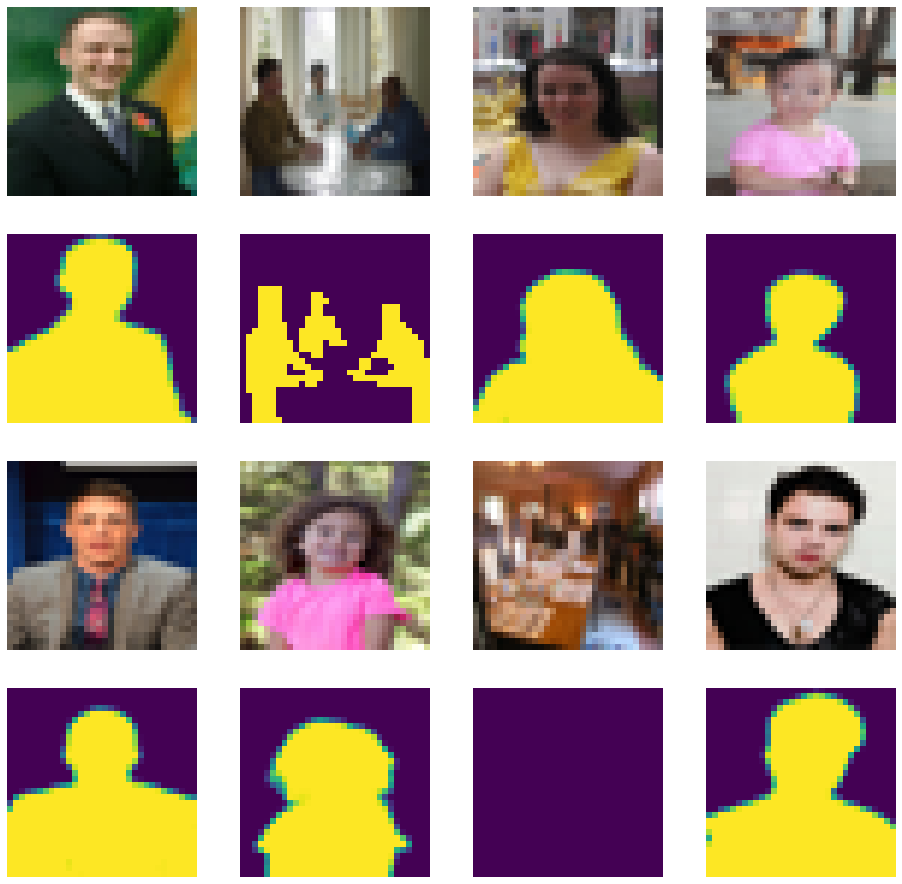

In [95]:
xsamples, ysamples = show_val_samples((x_val, y_val))

In [74]:
ysamples[0].mean()

0.493

In [75]:
ysamples.mean()

0.526

In [76]:
ysamples.reshape(len(ysamples),-1).mean(axis=1)

array([0.493 , 0.4636, 0.3796, 0.588 , 0.526 , 0.692 , 0.5044, 0.5615],
      dtype=float16)

In [96]:
yhatsamples = model.predict(xsamples)

[0 1 2 3 4 5 6 7]
1
5
2
6
3
7
4
8
9
13
10
14
11
15
12
16


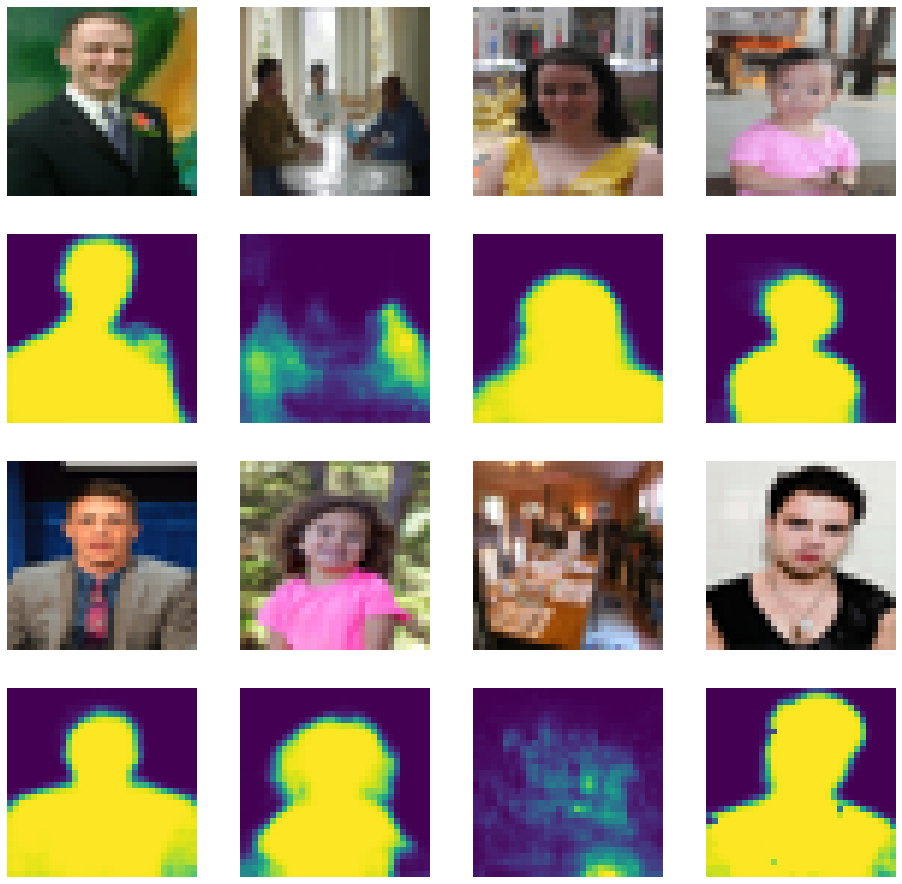

In [104]:
_ = show_val_samples((xsamples, yhatsamples), check_all=True)

In [100]:
np.arange(5)[3]

3

In [85]:
meanvalues = y_val.reshape(len(y_val),-1).mean(axis=1)

In [84]:
y_val.mean()

0.508

(array([ 603.,    0.,    0.,   25.,   22.,   17.,  154.,  562., 1157.,
        1661., 1552., 1490., 1381., 1065.,  739.,  379.,  151.,   63.,
          21.,    5.]),
 array([0.     , 0.04803, 0.09607, 0.144  , 0.1921 , 0.2401 , 0.288  ,
        0.3362 , 0.3843 , 0.4321 , 0.4802 , 0.5283 , 0.576  , 0.6245 ,
        0.6724 , 0.72   , 0.7686 , 0.8164 , 0.8643 , 0.9126 , 0.9604 ],
       dtype=float16),
 <BarContainer object of 20 artists>)

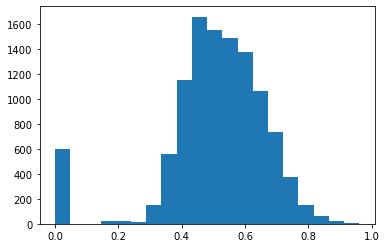

In [105]:
plt.hist(meanvalues, bins=20)

In [ ]:
old_model

In [107]:
2

2

In [111]:
meanpixels = y_val.reshape((len(y_val), -1)).mean(axis=0).reshape((32, 32))

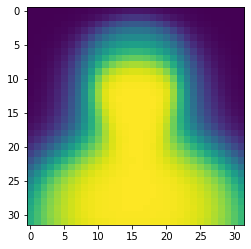

In [115]:
ax = plt.imshow(meanpixels.astype(float))

In [119]:
model

In [120]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_of8000 = converter.convert()
with open('semsegm_of8000.tflite', 'wb') as f:
    f.write(tflite_model_of8000)

In [122]:
def save_bunch_of_models(model, unique_name):
    optimizations = [
        (tf.lite.Optimize.DEFAULT, tf.float32, "default_32fp"),
        (tf.lite.Optimize.DEFAULT, tf.float16, "default_16fp"),
        (tf.lite.Optimize.OPTIMIZE_FOR_LATENCY, tf.float32, "latency_32fp"),
        (tf.lite.Optimize.OPTIMIZE_FOR_LATENCY, tf.float16, "latency_16fp")
    ]

    for optimization, tensor_type, name in optimizations:
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.post_training_quantize = True
        converter.optimizations = [optimization]
        converter.target_spec.supported_types = [tensor_type]
        tflite_model = converter.convert()
        open(os.path.join("tflite", "{}_{}.tflite".format(unique_name, name)), "wb").write(tflite_model)

In [124]:
save_bunch_of_models(model=model, unique_name='semsegm_of8000')

In [125]:
!ls tflite

segm_model_v5_0065_default_16fp.tflite	segm_model_v9_latency_16fp.tflite
segm_model_v5_0065_default_32fp.tflite	segm_model_v9_latency_32fp.tflite
segm_model_v5_0065_latency_16fp.tflite	semsegm_of8000_default_16fp.tflite
segm_model_v5_0065_latency_32fp.tflite	semsegm_of8000_default_32fp.tflite
segm_model_v9_default_16fp.tflite	semsegm_of8000_latency_16fp.tflite
segm_model_v9_default_32fp.tflite	semsegm_of8000_latency_32fp.tflite


In [118]:
def convert_model_from_name(model_args, model_kwargs):
    model = custom_unet(*model_args, **model_kwargs)
    del model
    gc.collect()

In [127]:
os.listdir('/home/aholdobin/supervise.ly')

['Supervisely Person Dataset', 'download', 'wget-log']

In [132]:
if 0:
    print('0')
elif -1:
    print(-1)

-1


In [135]:
def prepare_pascal_voc_dataset(pascal_voc_home='/home/aholdobin/pascalvoc2012/VOCdevkit/VOC2012/',
                               coco_home='/home/aholdobin/faces/',
                               shape=(32, 32),
                               verbose=False):
    gc.collect()
    # LOADING PASCAL_VOC DATA IF PROVIDED
    
    images = []
    masks = []
    
    if pascal_voc_home and os.path.exists(pascal_voc_home):
        segmentation_meta_path =  pascal_voc_home + 'ImageSets/Segmentation/trainval.txt'
        segmentation_folder = pascal_voc_home + 'SegmentationClass/'
        images_folder = pascal_voc_home + 'JPEGImages/'

        with open(segmentation_meta_path) as f:
            segmentation_files = f.read().split('\n')[:-1]

        for file in tqdm(segmentation_files):
            if os.path.exists(images_folder + file + '.jpg'):
                images.append(np.array(Image.open(images_folder + file + '.jpg').resize(shape)))
                masks.append(cv2.resize(np.array(Image.open(segmentation_folder + file + '.png')) == PASCAL_VOC_PERSON_CLASS_ID,dsize=shape)) 
                            

        X_pv = np.array(images)/255.
        y_pv = np.array(masks, dtype='float16')

        right = np.reshape(y_pv, [y_pv.shape[0], shape[0]*shape[1]]).mean(axis=1)
        right = (right >.15) | (right == .0)
        if verbose:
            print(sum(right))
        X_pv = X_pv[right]
        y_pv = y_pv[right]
        
        if verbose:
            print("x_pv: ", X_pv.shape)
            print("y_pv: ", y_pv.shape)
        
    del images
    del masks
    gc.collect()
    # LOADING COCO DATA IF PROVIDED
    images = []
    masks = []
    if coco_home and os.path.exists(coco_home):
        files = os.listdir(coco_home+'images/')
        if verbose: print('files len', len(files))
        files = list(map(lambda x: x[:-4] if x.endswith('jpg') else None, files))
        i=0
        for file in tqdm(files):
            i+=1
            if i<30: print(os.path.exists(coco_home + f'images/{file}.jpg'))
            if file and os.path.exists(coco_home + f'images/{file}.jpg'):
                
                images.append(np.array(Image.open(coco_home + f'images/{file}.jpg').resize(shape)))
                masks.append(np.array(Image.open(coco_home + f'masks/{file}.png').resize(shape))[:, :, -1])
        
        X_c = np.asarray(images, dtype=np.float32) / 255
        y_c = np.asarray(masks, dtype='float16') / 255
        
    X = np.concatenate([X_pv, X_c])
    y = np.concatenate([y_pv, y_c])
    y = np.reshape(y, (y.shape[0], y.shape[1], y.shape[2], 1))
    
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0)

    # del X
    # del y
    if verbose:
        print("x_train: ", x_train.shape)
        print("y_train: ", y_train.shape)
        print("x_val: ", x_val.shape)
        print("y_val: ", y_val.shape)
        
    return x_train, y_train, x_val, y_val
    
class AUnetBackgroundRemoval:
    
    def __init__(self, input_shape=(32, 32), filters=8, verbose=0, use_attention=True,
                checkpoint_folder='training_grid/'):
        self.__verbose = verbose
        self.__input_shape = (input_shape[0], input_shape[1], 3)
        self.__filters = filters
        self.__model = custom_unet(
            self.__input_shape,
            use_batch_norm=True,
            num_classes=1,
            filters=self.__filters,
            use_attention=use_attention,
            dropout=0.2,
            output_activation='sigmoid'
        )

        model.compile(
            optimizer=Adam(),
            loss='binary_crossentropy',
            metrics=[iou, iou_thresholded]
        )
        if verbose:
            model.summary()
            
    def train(self, x_train, y_train, x_val, y_val, epochs=1000, batch_size=1024, augm_args=dict(
                rotation_range=15.,
                width_shift_range=0.05,
                height_shift_range=0.05,
                shear_range=50,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=False,
                fill_mode='constant'
            )):
        
        train_gen = get_augmented(
            x_train, y_train, batch_size=batch_size,
            data_gen_args=augm_args)

        callback_checkpoint = ModelCheckpoint(
            filepath=self.__checkpoint_path,
            verbose=self.__verbose,
            monitor='val_loss',
            save_best_only=True,
        )

        self.__history = self.__model.fit(
            train_gen,
            steps_per_epoch=(len(X_train)+batch_size-1)//batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            callbacks=[callback_checkpoint]
        )
    
    def predict(self, x):
        if len(x.shape == 3):
            return self.__model.predict(x.reshape((1, * x.shape)))
    
    

In [1]:
(1,*(1,2,3))

(1, 1, 2, 3)

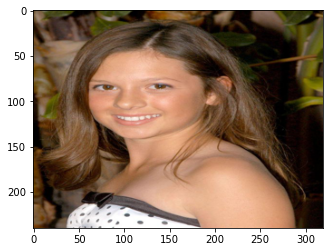

In [6]:
%matplotlib inline
plt.imshow(Image.open('/home/aholdobin/faces/images/1803151818-00000003.jpg').resize((320,240)))
plt.show()

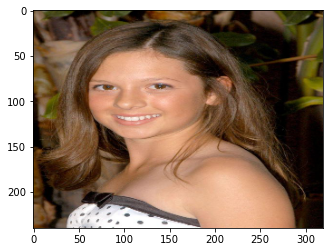

In [9]:
%matplotlib inline
plt.imshow(cv2.resize(np.array(Image.open('/home/aholdobin/faces/images/1803151818-00000003.jpg')), dsize=(320, 240)))
plt.show()

In [12]:
9

9

In [14]:
import argparse
parser = argparse.ArgumentParser(prog='AUnetBackgroundRemoval', description='Attention UNet parametrizable model trainer for background removal')
parser.add_argument('-p', '--pascal-voc-path', required=False, dest='pascal_voc_path')
parser.add_argument('-c', '--coco-portraints-path', required=False, dest='coco_portraits_path')
parser.add_argument('-s', '--supervisely-person-path', required=False, dest='supervisely_person_path')
parser.add_argument('-up', '--use_pascal-voc-path', action='store_true', required=False, dest='use_pascal_voc')
parser.add_argument('-uc', '--use-coco-portraints-path', action='store_true', required=False, dest='use_coco_portraits_voc')
parser.add_argument('-us', '--use-supervisely-person-path', action='store_true', required=False, dest='use_supervisely_person_voc')
parser.add_argument('-e', '--epochs', type=int, required=False, dest='epochs', default=1000)
parser.add_argument('-b', '--batch-size', type=int, required=False, dest='batch_size', default=8)
parser.add_argument('-v', '--verbose', type=int, required=False, dest='verbose', default=0)

_StoreAction(option_strings=['-v', '--verbose'], dest='verbose', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help=None, metavar=None)

In [16]:
args = parser.parse_args([])

In [17]:
if None and True:
    print('')

In [18]:
!python --version

Python 3.7.9


In [90]:
!python AUnetBackgroundRemoval.py -up -b 256 -e 5 -sd 128 -f 16 -v 1 --remove-previous-results

2020-09-15 18:31:55.287017: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-09-15 18:31:55.288074: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
2020-09-15 18:31:56.129873: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-09-15 18:31:56.148419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-15 18:31:56.148817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: GeForce RTX 2070 computeCapability:

  ...
    to  
  ['...']
Train for 7 steps, validate on 713 samples
Epoch 1/5
2020-09-15 18:32:18.994472: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-09-15 18:32:19.950492: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-09-15 18:32:21.769838: W tensorflow/core/common_runtime/bfc_allocator.cc:243] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2020-09-15 18:32:21.769864: W tensorflow/core/common_runtime/bfc_allocator.cc:243] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2020-09-15 18:32:21.810756: 

2020-09-15 18:32:47.851930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-15 18:32:47.852193: I tensorflow/core/grappler/devices.cc:55] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2020-09-15 18:32:47.852254: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2020-09-15 18:32:47.852888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-15 18:32:47.853090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.725GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2020-09-15 18:32:47.853123: 

2020-09-15 18:32:51.150683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-15 18:32:51.150938: I tensorflow/core/grappler/devices.cc:55] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2020-09-15 18:32:51.151042: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2020-09-15 18:32:51.151612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-15 18:32:51.151821: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.725GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2020-09-15 18:32:51.151857: 

2020-09-15 18:32:53.286688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-15 18:32:53.286961: I tensorflow/core/grappler/devices.cc:55] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2020-09-15 18:32:53.287035: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2020-09-15 18:32:53.287397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-15 18:32:53.287604: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.725GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2020-09-15 18:32:53.287642: 

In [77]:
python AUnetBackgroundRemoval.py -uc -up -b 1024 -e 10
python AUnetBackgroundRemoval.py -uc -up -b 1024 -e 10

SyntaxError: invalid syntax (<ipython-input-77-d0f840a2a3e8>, line 1)

In [80]:
os.listdir('training_grid/fil_8_shape_32x32/')

['history_fil_8_shape_32x32.json',
 'weights.0001-0.63.hdf5',
 'weights.0002-0.63.hdf5',
 'weights.0004-0.62.hdf5',
 'weights.0003-0.63.hdf5',
 'tflite']

In [81]:
!cat training_grid/fil_8_shape_32x32/history_fil_8_shape_32x32.json

{"loss": [0.8595703652030543, 0.8212387330794448, 0.795344514424721, 0.774553344010166, 0.7571181452445437], "iou": [0.045431021600961685, 0.04815731942653656, 0.04897861182689667, 0.04706428200006485, 0.04706677049398422], "iou_thresholded": [0.04534188657999039, 0.04898189753293991, 0.050028130412101746, 0.048407573252916336, 0.049409106373786926], "val_loss": [0.6338825225830078, 0.6301223039627075, 0.6252729892730713, 0.624085545539856, 0.625603973865509], "val_iou": [0.04222794622182846, 0.042097318917512894, 0.0419737882912159, 0.04195978865027428, 0.04205095022916794], "val_iou_thresholded": [0.03083406575024128, 0.030587557703256607, 0.031410373747348785, 0.0324016809463501, 0.030612992122769356]}

In [54]:
os.listdir('training_grid/fil_8_shape_32x32/tflite/')

['fil_8_shape_32x32_default_32fp.tflite',
 'fil_8_shape_32x32_default_16fp.tflite',
 'fil_8_shape_32x32_latency_16fp.tflite',
 'fil_8_shape_32x32_latency_32fp.tflite']

In [43]:
os.listdir('training_grid/fil_8_shape_32x32')[0][8:].split('-')[0]

'.03'

In [44]:
lambda x: x[8:].split('-')[0]

<function __main__.<lambda>(x)>

In [47]:
checkpoints = os.listdir('/home/aholdobin/ar-video-conf-mobile-demo/python/training_grid/fil_8_shape_32x32/')
checkpoints = list(map(lambda x: (x, int(x[8:].split('-')[0])), checkpoints))
checkpoints = sorted(checkpoints, key=lambda x:x[1])

In [48]:
checkpoints

[('weights.01-0.69.hdf5', 1),
 ('weights.02-0.69.hdf5', 2),
 ('weights.03-0.69.hdf5', 3),
 ('weights.04-0.68.hdf5', 4),
 ('weights.05-0.68.hdf5', 5),
 ('weights.06-0.67.hdf5', 6),
 ('weights.07-0.67.hdf5', 7),
 ('weights.08-0.67.hdf5', 8),
 ('weights.09-0.66.hdf5', 9),
 ('weights.10-0.65.hdf5', 10)]

In [49]:
checkpoints = os.listdir('/home/aholdobin/ar-video-conf-mobile-demo/python/training_grid/fil_8_shape_32x32/')
checkpoints = sorted(checkpoints)

In [50]:
checkpoints

['weights.01-0.69.hdf5',
 'weights.02-0.69.hdf5',
 'weights.03-0.69.hdf5',
 'weights.04-0.68.hdf5',
 'weights.05-0.68.hdf5',
 'weights.06-0.67.hdf5',
 'weights.07-0.67.hdf5',
 'weights.08-0.67.hdf5',
 'weights.09-0.66.hdf5',
 'weights.10-0.65.hdf5']

In [58]:
import json

with open('w.json', 'w') as f:
    json.dump({1:'22'}, f)

In [82]:
import json

with open('w.json', 'w') as f:
    json.dump({1:list(map(lambda x: float(x), [data,data,data,data]))}, f)

In [73]:
!cat w.json
!rm w.json

{"1": [0.0, 0.0, 0.0, 0.0]}

In [84]:
import json

with open('w.json') as f:
    print(json.load(f))

{'1': [0.0, 0.0, 0.0, 0.0]}


In [70]:
data = np.zeros([1])

In [92]:
import subprocess

In [94]:
'{r}, {d}'.format(r=2,d=3,c=4)

KeyError: 'add'

In [113]:
cmd = 'python AUnetBackgroundRemoval.py -uc -up -sd {side} -b {batch_size} -e {epochs} -f {filters}' # ' > {name}.log'
cmd_tst = 'python AUnetBackgroundRemoval.py -up -sd {side} -b {batch_size} -e 1 -f {filters}'



models_parameters = [
        {'name': 'side32_filters8',
        'side': 32,
        'batch_size': 1024,
        'filters': 8,
        'epochs': 500
    },
        {'name': 'side64_filters8',
        'side': 64,
        'batch_size': 512,
        'filters': 8,
        'epochs': 500
    },
        {'name': 'side128_filters8',
        'side': 128,
        'batch_size': 256,
        'filters': 8,
        'epochs': 500
    },
        {'name': 'side32_filters16',
        'side': 32,
        'batch_size': 1024,
        'filters': 16,
        'epochs': 500
    },
        {'name': 'side64_filters16',
        'side': 64,
        'batch_size': 512,
        'filters': 16,
        'epochs': 500
    },
        {'name': 'side128_filters16',
        'side': 128,
        'batch_size': 256,
        'filters': 16,
        'epochs': 500
    },
        {'name': 'side32_filters12',
        'side': 32,
        'batch_size': 1024,
        'filters': 12,
        'epochs': 500
    },
        {'name': 'side64_filters12' ,
        'side': 64,
        'batch_size': 512,
        'filters': 12,
        'epochs': 500
    },
        {'name': 'side128_filters12' ,
        'side': 128,
        'batch_size': 256,
        'filters': 12,
        'epochs': 500
    },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8', 
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
]

In [110]:
for value in models_parameters:
    #print(cmd.format(**value))
    #proc = subprocess.call(cmd.format(**value), stderr=subprocess.STDOUT, stdout='/dev/null')
    
    proc = subprocess.call(cmd_tst.format(**value).split(), stderr=subprocess.STDOUT)
    print(proc)

0
0
0
0
0
0
0
0
0


In [ ]:
for value in models_parameters:
    with open(value['name'] + '.log', 'w') as f:
        proc = subprocess.call(cmd.format(**value).split(), stdout=f, stderr=subprocess.STDOUT)
    print(proc)

0
0
1
0


In [117]:
cmd_tflite = 'python AUnetBackgroundRemoval.py -sd {side} -f {filters} -l'


models_parameters = [
        {'name': 'side32_filters8',
        'side': 32,
        'batch_size': 1024,
        'filters': 8,
        'epochs': 500
    },
        {'name': 'side64_filters8',
        'side': 64,
        'batch_size': 512,
        'filters': 8,
        'epochs': 500
    },
#         {'name': 'side128_filters8',
#         'side': 128,
#         'batch_size': 256,
#         'filters': 8,
#         'epochs': 500
#     },
        {'name': 'side32_filters16',
        'side': 32,
        'batch_size': 1024,
        'filters': 16,
        'epochs': 500
    },
        {'name': 'side64_filters16',
        'side': 64,
        'batch_size': 512,
        'filters': 16,
        'epochs': 500
    },
#         {'name': 'side128_filters16',
#         'side': 128,
#         'batch_size': 256,
#         'filters': 16,
#         'epochs': 500
#     },
        {'name': 'side32_filters12',
        'side': 32,
        'batch_size': 1024,
        'filters': 12,
        'epochs': 500
    },
        {'name': 'side64_filters12' ,
        'side': 64,
        'batch_size': 512,
        'filters': 12,
        'epochs': 500
    },
#         {'name': 'side128_filters12' ,
#         'side': 128,
#         'batch_size': 256,
#         'filters': 12,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8', 
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
]

for value in models_parameters:
    proc = subprocess.call(cmd_tflite.format(**value).split())
    print(value['name'], proc)

side32_filters8 0
side64_filters8 0
side32_filters16 0
side64_filters16 0
side32_filters12 0
side64_filters12 0


In [120]:
cmd = 'python AUnetBackgroundRemoval.py -l -uc -up -sd {side} -b {batch_size} -e {epochs} -f {filters}' # ' > {name}.log'
cmd_tst = 'python AUnetBackgroundRemoval.py -up -sd {side} -b {batch_size} -e 1 -f {filters}'

models_parameters128 = [
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side64_filters8',
#         'side': 64,
#         'batch_size': 512,
#         'filters': 8,
#         'epochs': 500
#     },
        {'name': 'side128_filters8',
        'side': 128,
        'batch_size': 256,
        'filters': 8,
        'epochs': 500
    },
#         {'name': 'side32_filters16',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 16,
#         'epochs': 500
#     },
#         {'name': 'side64_filters16',
#         'side': 64,
#         'batch_size': 512,
#         'filters': 16,
#         'epochs': 500
#     },
        {'name': 'side128_filters16',
        'side': 128,
        'batch_size': 256,
        'filters': 16,
        'epochs': 500
    },
#         {'name': 'side32_filters12',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 12,
#         'epochs': 500
#     },
#         {'name': 'side64_filters12' ,
#         'side': 64,
#         'batch_size': 512,
#         'filters': 12,
#         'epochs': 500
#     },
        {'name': 'side128_filters12' ,
        'side': 128,
        'batch_size': 256,
        'filters': 12,
        'epochs': 500
    },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8', 
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8' ,
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,
#         'epochs': 500
#     },
#         {'name': 'side32_filters8',
#         'side': 32,
#         'batch_size': 1024,
#         'filters': 8,htop
#         'epochs': 500
#     },
]

for value in models_parameters128:
    with open(value['name'] + '.log2', 'w') as f:
        proc = subprocess.call(cmd.format(**value).split(), stdout=f, stderr=subprocess.STDOUT)
    print(proc)

1
1
1
